In [1]:
%run base_functions.ipynb

In [2]:
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error,explained_variance_score,confusion_matrix,f1_score


In [3]:
class ModelPrediction:
    def __init__(self,ticker,predicted_column,prediction_date,time_frame,model_conext):
        self.ticker = ticker
        self.predicted_column = predicted_column
        self.prediction_date = prediction_date
        self.time_frame = time_frame
        self.model_conext = model_conext
    def get_json(self,include_chart_data=False):
        json_data =  {'SYMBOL':self.ticker
                   ,'prediction_date':self.prediction_date
                   ,'value': self.model_conext.predict_val[0]
                    ,'time_frame' : self.time_frame
                    ,'last_value':self.model_conext.input_data[self.predicted_column[2:]].values[0]
                    ,'column' : self.model_conext.prediction_column
                    }
        if(include_chart_data):
            json_data['y_predicted'] = self.model_conext.y_predicted
            json_data['y_test'] = self.model_conext.y_test
            json_data['coef'] = self.model_conext.coef
            json_data['feature_column'] = self.model_conext.feature_column
        
        json_data.update(self.model_conext.metrics)
        return json_data
    
class ModelConext:
    def __init__(self):
        self.metrics = {}
        self.model_object = None
        self.coef = None
        self.y_predicted = None
        self.y_test = None
        self.predict_val=None
        
    def train(self, data, model_object, feature_column, prediction_column, metric_functions, input_data):
        self.feature_column = feature_column
        self.input_data = input_data
        self.prediction_column = prediction_column
        # prepare columns
        X = data[feature_column]
        y = data[prediction_column]

         #train test split
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=101)
        
        model_object.fit(X_train,y_train)
        
        self.model_object = model_object
        self.coef = model_object.coef_
        
        # testing model 
        self.y_predicted = self.model_object.predict(X_test)
        self.y_test = y_test
        
        metric_functions(self)
        
        self.predict(input_data)
        
        return self
    
    def is_trained(self):
        if(self.model_object is None):
            raise Exception('Model is not trained')
    def predict(self,input_data):
        self.is_trained()
        self.predict_val = self.model_object.predict(input_data[self.feature_column])
        return self.predict_val
        
    def plot_test_result(self,title):
        self.is_trained()
        plt.scatter(self.y_test,self.y_predicted,s=2,ax=ax);
        plt.title(title)
        #plt.title(lm_df['SYMBOL'].unique()[0]  +  ' - ' + time_frame)
        plt.xlabel(' ( True Values)')
        plt.ylabel('Predicted value')
        #plt.show()

def apply_ml(historical_data,prediction_shifts,selected_time_dims,data_function,algo_function):
    output_data = []
    for prediction_shift in prediction_shifts:
        prediction_date = datetime.fromtimestamp( historical_data[0].data.tail(1)['t'].values[0] ) + timedelta(days=prediction_shift)
        while prediction_date.weekday() > 4:
            prediction_date = prediction_date + timedelta(days=1)
        prediction_date

        for ticker_data in historical_data: 
            ticker = ticker_data.name
            display(HTML('<center><b>PREDICTING Values for ticker '+ ticker +'</b></center>'))
            # prepare data for linear model
            raw_data,feature_column,prediction_columns,real_data = data_function(ticker_data.data,prediction_shift)
            for key_time in selected_time_dims:
                lm_df = time_filter(raw_data,key_time);
                for y_column in prediction_columns:
                    try:
                        #calling predict method  lm_df,feature_column,y_column,X_future
                        model_conext = algo_function(lm_df,feature_column,y_column,real_data)
                        output_data.append(ModelPrediction(ticker,y_column,prediction_date,key_time,model_conext))
                    except Exception as e:
                        display('error creating model - '+ ticker +'  '+ y_column + '  '+ key_time)
                        traceback.print_exc()
                        #raise e
    return output_data


def prediction_summary(ports,predicted_data):
    display(HTML('<h5> Report for: ' + predicted_data['prediction_date'].head(1)[0].strftime('%d %b %Y') +'</h5>'))
    display(ports)

    for ticker in predicted_data['SYMBOL'].unique():
        predicted_pivot = order_time_dims(ticker_filter(predicted_data,ticker),'time_frame').pivot(index=['SYMBOL','time_frame'], columns='column', values='value')
        display_full(predicted_pivot)

def display_info(coef_df,chart_df_array):
    display(coef_df)
    chart_rows = math.ceil(len(chart_df_array) / 2)
    chart_count = 0
    row_count = 0
    fig, axes = plt.subplots(nrows=chart_rows, ncols=2,figsize=(10,math.ceil(chart_rows * 3.5)))
    for chart_df in chart_df_array:
        p = sns.scatterplot(data=chart_df, x='test_value', y='pred_value', ax=axes[row_count][chart_count%2])
        p.set_title(chart_df['pred_column'].unique()[0])
        plt.setp(p.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
        chart_count = chart_count + 1
        if (chart_count%2 == 0):
            row_count = row_count + 1
    #plt.legend()
    plt.show()
    
def get_predicted_value(final_prediction_data):
    predicted_values = pd.DataFrame([x.get_json() for x in final_prediction_data]).set_index(['SYMBOL','prediction_date','column','value']).drop_duplicates()

    predicted_values = predicted_values.reset_index()
    predicted_values['change'] = predicted_values['value'] - predicted_values['last_value']
    return predicted_values    
#all_info = [x.get_json(True) for x in final_prediction_data]
def prediction_details(prediction_data):
    previous_time_frame = ''
    coef_df = None
    chart_df_array = []
    for item in prediction_data:
        #item = pred_data.get_json()
        if(previous_time_frame != item.time_frame):
            if coef_df is not None: 
                display_info(coef_df,chart_df_array)

            coef_df = pd.DataFrame({})
            chart_df_array = []
            previous_time_frame = item.time_frame
            display(HTML('Prediction for <b>{0}</b> - {1} - {2}'.format(item.ticker,item.time_frame,item.prediction_date.strftime('%d %b %Y'),item.model_conext.prediction_column)))


        #plt.plot(item['y_test'], item['y_predicted'],label=item['column'])
        #item.model_conext.plot_test_result('')
        coef_df = coef_df.append(pd.DataFrame({item.model_conext.prediction_column:item.model_conext.coef},index=item.model_conext.feature_column ).transpose())
        tmp_chart_df = pd.DataFrame({'test_value':item.model_conext.y_test,'pred_value':item.model_conext.y_predicted })
        tmp_chart_df['pred_column'] =  item.model_conext.prediction_column
        chart_df_array.append(tmp_chart_df)

    display_info(coef_df,chart_df_array)

In [4]:
default_val = None
source_file='20210105/nifty_next_50.csv'
target_file='lm_pred_nifty_next_50.csv'
target_pdf='nifty_next_50.pdf'

In [5]:
# file format must be SYMBOL,QTY,INVESTMENT,AVG
my_port = load_portfolio_file(source_file,False)  
my_port = my_port.append(load_portfolio_file('my_portfolio.txt'))

#my_port = pd.DataFrame({"SYMBOL":['HAL']})
my_port_index_symbol = my_port.set_index('SYMBOL')

my_port_index_symbol

,QTY,INVESTMENT,AVG
SYMBOL,,,
NAUKRI,NaN,NaN,NaN
LTI,NaN,NaN,NaN
INDUSTOWER,NaN,NaN,NaN
HINDZINC,NaN,NaN,NaN
DMART,NaN,NaN,NaN
MUTHOOTFIN,NaN,NaN,NaN
SBICARD,NaN,NaN,NaN
HDFCAMC,NaN,NaN,NaN
IGL,NaN,NaN,NaN


In [6]:
%%capture --no-stderr
market_data_1 = load_price_history(my_port['SYMBOL'],365*5)

In [4]:

def prepare_lm_data(raw_data,prediction_shift):
    # preparing data
    #raw_data = ticker_data.data
    len_df = len(raw_data)
    
    X_future = raw_data.iloc[[len_df - 1]]
    
    columns = ['o','h','l','c','v']
    
    for c in columns:
        raw_data['f_'+c] = raw_data[c].shift(-prediction_shift)

    display_full(raw_data.tail(prediction_shift+3))
    drop_index = np.arange(start=len_df - prediction_shift, stop=len_df)
    # prepare data
    raw_data = raw_data.drop(drop_index)
    
    display_full(raw_data.tail(prediction_shift+3))
    return raw_data,columns,['f_o','f_h','f_l','f_c'], X_future

def lm_metric_function(lm_context):
    lm_context.metrics['MAE'] = mean_absolute_error(lm_context.y_test,lm_context.y_predicted)
    lm_context.metrics['MSE'] = mean_squared_error(lm_context.y_test,lm_context.y_predicted)
    lm_context.metrics['RMSE'] = np.sqrt(mean_squared_error(lm_context.y_test,lm_context.y_predicted))
    lm_context.metrics['explained_variance_score'] = explained_variance_score(lm_context.y_test,lm_context.y_predicted)
    
def predict_lm_values(lm_df,feature_column,y_column,X_future):
    lm_context = ModelConext().train(lm_df,LinearRegression(),feature_column,y_column,lm_metric_function,X_future)
    return lm_context




In [8]:
final_prediction_data = apply_ml(market_data_1,[1],time_dims,prepare_lm_data,predict_lm_values)
predicted_values = get_predicted_value(final_prediction_data)

# updated
update_portfolio_file(predicted_values,'lm_pred_'+target_file,False)
display(predicted_values)

,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"5,359.00","5,419.95","5,235.15","5,311.25",956013,2021-01-07 05:30:00,NAUKRI,"5,344.00","5,450.00","5,288.55","5,412.20","728,189.00"
1232,1610064000,"5,344.00","5,450.00","5,288.55","5,412.20",728189,2021-01-08 05:30:00,NAUKRI,"5,434.00","5,518.90","5,336.00","5,478.90","551,748.00"
1233,1610323200,"5,434.00","5,518.90","5,336.00","5,478.90",551748,2021-01-11 05:30:00,NAUKRI,"5,426.00","5,532.75","5,334.55","5,369.70","348,712.00"
1234,1610409600,"5,426.00","5,532.75","5,334.55","5,369.70",348712,2021-01-12 05:30:00,NAUKRI,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"5,500.00","5,880.00","5,181.05","5,259.80",4159539,2021-01-06 05:30:00,NAUKRI,"5,359.00","5,419.95","5,235.15","5,311.25","956,013.00"
1231,1609977600,"5,359.00","5,419.95","5,235.15","5,311.25",956013,2021-01-07 05:30:00,NAUKRI,"5,344.00","5,450.00","5,288.55","5,412.20","728,189.00"
1232,1610064000,"5,344.00","5,450.00","5,288.55","5,412.20",728189,2021-01-08 05:30:00,NAUKRI,"5,434.00","5,518.90","5,336.00","5,478.90","551,748.00"
1233,1610323200,"5,434.00","5,518.90","5,336.00","5,478.90",551748,2021-01-11 05:30:00,NAUKRI,"5,426.00","5,532.75","5,334.55","5,369.70","348,712.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1106,1609977600,"3,998.05","4,029.00","3,870.00","3,882.90",363617,2021-01-07 05:30:00,LTI,"3,920.85","4,114.00","3,920.00","4,092.20","582,258.00"
1107,1610064000,"3,920.85","4,114.00","3,920.00","4,092.20",582258,2021-01-08 05:30:00,LTI,"4,150.00","4,280.00","4,065.00","4,245.15","426,541.00"
1108,1610323200,"4,150.00","4,280.00","4,065.00","4,245.15",426541,2021-01-11 05:30:00,LTI,"4,225.25","4,444.00","4,170.00","4,285.15","559,357.00"
1109,1610409600,"4,225.25","4,444.00","4,170.00","4,285.15",559357,2021-01-12 05:30:00,LTI,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1105,1609891200,"4,147.00","4,159.00","3,935.00","3,956.90",597076,2021-01-06 05:30:00,LTI,"3,998.05","4,029.00","3,870.00","3,882.90","363,617.00"
1106,1609977600,"3,998.05","4,029.00","3,870.00","3,882.90",363617,2021-01-07 05:30:00,LTI,"3,920.85","4,114.00","3,920.00","4,092.20","582,258.00"
1107,1610064000,"3,920.85","4,114.00","3,920.00","4,092.20",582258,2021-01-08 05:30:00,LTI,"4,150.00","4,280.00","4,065.00","4,245.15","426,541.00"
1108,1610323200,"4,150.00","4,280.00","4,065.00","4,245.15",426541,2021-01-11 05:30:00,LTI,"4,225.25","4,444.00","4,170.00","4,285.15","559,357.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,264.40,275.00,261.00,266.15,7916157,2021-01-07 05:30:00,INDUSTOWER,267.45,273.00,266.25,270.45,"4,047,880.00"
1233,1610064000,267.45,273.00,266.25,270.45,4047880,2021-01-08 05:30:00,INDUSTOWER,271.90,271.90,260.50,262.25,"3,453,837.00"
1234,1610323200,271.90,271.90,260.50,262.25,3453837,2021-01-11 05:30:00,INDUSTOWER,262.25,268.35,257.45,261.35,"6,351,455.00"
1235,1610409600,262.25,268.35,257.45,261.35,6351455,2021-01-12 05:30:00,INDUSTOWER,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,256.50,270.75,255.15,261.35,9036353,2021-01-06 05:30:00,INDUSTOWER,264.40,275.00,261.00,266.15,"7,916,157.00"
1232,1609977600,264.40,275.00,261.00,266.15,7916157,2021-01-07 05:30:00,INDUSTOWER,267.45,273.00,266.25,270.45,"4,047,880.00"
1233,1610064000,267.45,273.00,266.25,270.45,4047880,2021-01-08 05:30:00,INDUSTOWER,271.90,271.90,260.50,262.25,"3,453,837.00"
1234,1610323200,271.90,271.90,260.50,262.25,3453837,2021-01-11 05:30:00,INDUSTOWER,262.25,268.35,257.45,261.35,"6,351,455.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,281.00,328.40,280.05,308.15,5200956,2021-01-07 05:30:00,HINDZINC,312.00,324.90,298.20,304.00,"9,070,406.00"
1233,1610064000,312.00,324.90,298.20,304.00,9070406,2021-01-08 05:30:00,HINDZINC,300.70,301.00,286.50,292.25,"2,359,429.00"
1234,1610323200,300.70,301.00,286.50,292.25,2359429,2021-01-11 05:30:00,HINDZINC,293.65,303.00,286.00,290.65,"1,455,335.00"
1235,1610409600,293.65,303.00,286.00,290.65,1455335,2021-01-12 05:30:00,HINDZINC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,257.25,279.90,256.95,275.10,8436991,2021-01-06 05:30:00,HINDZINC,281.00,328.40,280.05,308.15,"5,200,956.00"
1232,1609977600,281.00,328.40,280.05,308.15,5200956,2021-01-07 05:30:00,HINDZINC,312.00,324.90,298.20,304.00,"9,070,406.00"
1233,1610064000,312.00,324.90,298.20,304.00,9070406,2021-01-08 05:30:00,HINDZINC,300.70,301.00,286.50,292.25,"2,359,429.00"
1234,1610323200,300.70,301.00,286.50,292.25,2359429,2021-01-11 05:30:00,HINDZINC,293.65,303.00,286.00,290.65,"1,455,335.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
942,1609977600,"2,971.70","3,008.00","2,880.00","2,921.45",872261,2021-01-07 05:30:00,DMART,"2,949.90","2,999.00","2,932.25","2,967.50","742,344.00"
943,1610064000,"2,949.90","2,999.00","2,932.25","2,967.50",742344,2021-01-08 05:30:00,DMART,"3,137.00","3,137.00","2,940.00","2,984.85","1,845,898.00"
944,1610323200,"3,137.00","3,137.00","2,940.00","2,984.85",1845898,2021-01-11 05:30:00,DMART,"2,959.00","3,009.50","2,939.45","2,998.20","1,081,702.00"
945,1610409600,"2,959.00","3,009.50","2,939.45","2,998.20",1081702,2021-01-12 05:30:00,DMART,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
941,1609891200,"3,006.45","3,100.00","2,832.80","2,914.95",1112886,2021-01-06 05:30:00,DMART,"2,971.70","3,008.00","2,880.00","2,921.45","872,261.00"
942,1609977600,"2,971.70","3,008.00","2,880.00","2,921.45",872261,2021-01-07 05:30:00,DMART,"2,949.90","2,999.00","2,932.25","2,967.50","742,344.00"
943,1610064000,"2,949.90","2,999.00","2,932.25","2,967.50",742344,2021-01-08 05:30:00,DMART,"3,137.00","3,137.00","2,940.00","2,984.85","1,845,898.00"
944,1610323200,"3,137.00","3,137.00","2,940.00","2,984.85",1845898,2021-01-11 05:30:00,DMART,"2,959.00","3,009.50","2,939.45","2,998.20","1,081,702.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609977600,"1,284.00","1,294.00","1,272.00","1,277.45",1049691,2021-01-07 05:30:00,MUTHOOTFIN,"1,280.00","1,294.00","1,267.35","1,283.30","1,382,458.00"
1231,1610064000,"1,280.00","1,294.00","1,267.35","1,283.30",1382458,2021-01-08 05:30:00,MUTHOOTFIN,"1,276.00","1,280.00","1,243.00","1,270.50","1,462,153.00"
1232,1610323200,"1,276.00","1,280.00","1,243.00","1,270.50",1462153,2021-01-11 05:30:00,MUTHOOTFIN,"1,270.50","1,283.75","1,260.20","1,276.65","1,268,659.00"
1233,1610409600,"1,270.50","1,283.75","1,260.20","1,276.65",1268659,2021-01-12 05:30:00,MUTHOOTFIN,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1229,1609891200,"1,299.80","1,311.05","1,258.05","1,280.90",2359748,2021-01-06 05:30:00,MUTHOOTFIN,"1,284.00","1,294.00","1,272.00","1,277.45","1,049,691.00"
1230,1609977600,"1,284.00","1,294.00","1,272.00","1,277.45",1049691,2021-01-07 05:30:00,MUTHOOTFIN,"1,280.00","1,294.00","1,267.35","1,283.30","1,382,458.00"
1231,1610064000,"1,280.00","1,294.00","1,267.35","1,283.30",1382458,2021-01-08 05:30:00,MUTHOOTFIN,"1,276.00","1,280.00","1,243.00","1,270.50","1,462,153.00"
1232,1610323200,"1,276.00","1,280.00","1,243.00","1,270.50",1462153,2021-01-11 05:30:00,MUTHOOTFIN,"1,270.50","1,283.75","1,260.20","1,276.65","1,268,659.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
204,1609977600,985.20,"1,002.05",956.35,977.50,3734212,2021-01-07 05:30:00,SBICARD,980.00,989.00,958.00,965.15,"1,525,747.00"
205,1610064000,980.00,989.00,958.00,965.15,1525747,2021-01-08 05:30:00,SBICARD,968.45,970.45,941.15,964.90,"1,639,562.00"
206,1610323200,968.45,970.45,941.15,964.90,1639562,2021-01-11 05:30:00,SBICARD,965.10,979.00,952.00,961.75,"1,026,418.00"
207,1610409600,965.10,979.00,952.00,961.75,1026418,2021-01-12 05:30:00,SBICARD,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
203,1609891200,918.20,975.00,918.20,969.00,7456425,2021-01-06 05:30:00,SBICARD,985.20,"1,002.05",956.35,977.50,"3,734,212.00"
204,1609977600,985.20,"1,002.05",956.35,977.50,3734212,2021-01-07 05:30:00,SBICARD,980.00,989.00,958.00,965.15,"1,525,747.00"
205,1610064000,980.00,989.00,958.00,965.15,1525747,2021-01-08 05:30:00,SBICARD,968.45,970.45,941.15,964.90,"1,639,562.00"
206,1610323200,968.45,970.45,941.15,964.90,1639562,2021-01-11 05:30:00,SBICARD,965.10,979.00,952.00,961.75,"1,026,418.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
598,1609977600,"3,119.75","3,122.90","3,028.20","3,063.15",334927,2021-01-07 05:30:00,HDFCAMC,"3,063.00","3,145.00","3,053.15","3,137.85","468,406.00"
599,1610064000,"3,063.00","3,145.00","3,053.15","3,137.85",468406,2021-01-08 05:30:00,HDFCAMC,"3,150.00","3,195.95","3,137.85","3,182.45","338,546.00"
600,1610323200,"3,150.00","3,195.95","3,137.85","3,182.45",338546,2021-01-11 05:30:00,HDFCAMC,"3,182.45","3,235.00","3,162.10","3,212.60","274,537.00"
601,1610409600,"3,182.45","3,235.00","3,162.10","3,212.60",274537,2021-01-12 05:30:00,HDFCAMC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
597,1609891200,"3,119.10","3,138.95","3,052.50","3,099.80",366690,2021-01-06 05:30:00,HDFCAMC,"3,119.75","3,122.90","3,028.20","3,063.15","334,927.00"
598,1609977600,"3,119.75","3,122.90","3,028.20","3,063.15",334927,2021-01-07 05:30:00,HDFCAMC,"3,063.00","3,145.00","3,053.15","3,137.85","468,406.00"
599,1610064000,"3,063.00","3,145.00","3,053.15","3,137.85",468406,2021-01-08 05:30:00,HDFCAMC,"3,150.00","3,195.95","3,137.85","3,182.45","338,546.00"
600,1610323200,"3,150.00","3,195.95","3,137.85","3,182.45",338546,2021-01-11 05:30:00,HDFCAMC,"3,182.45","3,235.00","3,162.10","3,212.60","274,537.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,546.65,549.65,537.85,540.00,4185940,2021-01-07 05:30:00,IGL,543.55,553.75,541.05,550.70,"3,552,973.00"
1233,1610064000,543.55,553.75,541.05,550.70,3552973,2021-01-08 05:30:00,IGL,550.00,560.00,547.10,557.50,"2,257,669.00"
1234,1610323200,550.00,560.00,547.10,557.50,2257669,2021-01-11 05:30:00,IGL,555.00,572.95,554.65,567.20,"3,682,728.00"
1235,1610409600,555.00,572.95,554.65,567.20,3682728,2021-01-12 05:30:00,IGL,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,522.85,545.30,521.00,542.40,7179407,2021-01-06 05:30:00,IGL,546.65,549.65,537.85,540.00,"4,185,940.00"
1232,1609977600,546.65,549.65,537.85,540.00,4185940,2021-01-07 05:30:00,IGL,543.55,553.75,541.05,550.70,"3,552,973.00"
1233,1610064000,543.55,553.75,541.05,550.70,3552973,2021-01-08 05:30:00,IGL,550.00,560.00,547.10,557.50,"2,257,669.00"
1234,1610323200,550.00,560.00,547.10,557.50,2257669,2021-01-11 05:30:00,IGL,555.00,572.95,554.65,567.20,"3,682,728.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,788.90,797.90,782.20,792.00,873088,2021-01-07 05:30:00,BERGEPAINT,793.45,812.95,792.65,810.60,"967,826.00"
1232,1610064000,793.45,812.95,792.65,810.60,967826,2021-01-08 05:30:00,BERGEPAINT,813.00,819.85,803.20,810.80,"1,083,106.00"
1233,1610323200,813.00,819.85,803.20,810.80,1083106,2021-01-11 05:30:00,BERGEPAINT,810.90,814.65,798.60,803.15,"596,031.00"
1234,1610409600,810.90,814.65,798.60,803.15,596031,2021-01-12 05:30:00,BERGEPAINT,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,791.50,794.35,775.60,783.00,1007682,2021-01-06 05:30:00,BERGEPAINT,788.90,797.90,782.20,792.00,"873,088.00"
1231,1609977600,788.90,797.90,782.20,792.00,873088,2021-01-07 05:30:00,BERGEPAINT,793.45,812.95,792.65,810.60,"967,826.00"
1232,1610064000,793.45,812.95,792.65,810.60,967826,2021-01-08 05:30:00,BERGEPAINT,813.00,819.85,803.20,810.80,"1,083,106.00"
1233,1610323200,813.00,819.85,803.20,810.80,1083106,2021-01-11 05:30:00,BERGEPAINT,810.90,814.65,798.60,803.15,"596,031.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
812,1609977600,"1,618.80","1,622.90","1,561.00","1,571.20",588805,2021-01-07 05:30:00,ICICIGI,"1,583.90","1,617.95","1,562.00","1,605.15","719,490.00"
813,1610064000,"1,583.90","1,617.95","1,562.00","1,605.15",719490,2021-01-08 05:30:00,ICICIGI,"1,616.10","1,621.00","1,586.40","1,609.70","543,087.00"
814,1610323200,"1,616.10","1,621.00","1,586.40","1,609.70",543087,2021-01-11 05:30:00,ICICIGI,"1,607.40","1,616.90","1,556.80","1,565.95","451,933.00"
815,1610409600,"1,607.40","1,616.90","1,556.80","1,565.95",451933,2021-01-12 05:30:00,ICICIGI,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
811,1609891200,"1,589.00","1,626.45","1,575.55","1,611.70",1321608,2021-01-06 05:30:00,ICICIGI,"1,618.80","1,622.90","1,561.00","1,571.20","588,805.00"
812,1609977600,"1,618.80","1,622.90","1,561.00","1,571.20",588805,2021-01-07 05:30:00,ICICIGI,"1,583.90","1,617.95","1,562.00","1,605.15","719,490.00"
813,1610064000,"1,583.90","1,617.95","1,562.00","1,605.15",719490,2021-01-08 05:30:00,ICICIGI,"1,616.10","1,621.00","1,586.40","1,609.70","543,087.00"
814,1610323200,"1,616.10","1,621.00","1,586.40","1,609.70",543087,2021-01-11 05:30:00,ICICIGI,"1,607.40","1,616.90","1,556.80","1,565.95","451,933.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"3,398.25","3,420.00","3,310.00","3,325.15",54859,2021-01-07 05:30:00,OFSS,"3,368.45","3,368.45","3,305.55","3,342.40","103,532.00"
1233,1610064000,"3,368.45","3,368.45","3,305.55","3,342.40",103532,2021-01-08 05:30:00,OFSS,"3,410.00","3,429.90","3,330.05","3,353.00","120,399.00"
1234,1610323200,"3,410.00","3,429.90","3,330.05","3,353.00",120399,2021-01-11 05:30:00,OFSS,"3,369.00","3,535.00","3,333.00","3,464.65","236,200.00"
1235,1610409600,"3,369.00","3,535.00","3,333.00","3,464.65",236200,2021-01-12 05:30:00,OFSS,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"3,448.50","3,480.00","3,333.30","3,364.95",65935,2021-01-06 05:30:00,OFSS,"3,398.25","3,420.00","3,310.00","3,325.15","54,859.00"
1232,1609977600,"3,398.25","3,420.00","3,310.00","3,325.15",54859,2021-01-07 05:30:00,OFSS,"3,368.45","3,368.45","3,305.55","3,342.40","103,532.00"
1233,1610064000,"3,368.45","3,368.45","3,305.55","3,342.40",103532,2021-01-08 05:30:00,OFSS,"3,410.00","3,429.90","3,330.05","3,353.00","120,399.00"
1234,1610323200,"3,410.00","3,429.90","3,330.05","3,353.00",120399,2021-01-11 05:30:00,OFSS,"3,369.00","3,535.00","3,333.00","3,464.65","236,200.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,955.80,977.95,946.00,971.25,2124734,2021-01-07 05:30:00,HAVELLS,976.10,"1,012.55",974.10,"1,007.50","3,536,689.00"
1233,1610064000,976.10,"1,012.55",974.10,"1,007.50",3536689,2021-01-08 05:30:00,HAVELLS,"1,015.50","1,026.75","1,002.05","1,013.80","1,773,737.00"
1234,1610323200,"1,015.50","1,026.75","1,002.05","1,013.80",1773737,2021-01-11 05:30:00,HAVELLS,"1,012.65","1,026.00","1,003.40","1,018.80","1,799,936.00"
1235,1610409600,"1,012.65","1,026.00","1,003.40","1,018.80",1799936,2021-01-12 05:30:00,HAVELLS,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,945.00,953.65,934.05,945.90,2633011,2021-01-06 05:30:00,HAVELLS,955.80,977.95,946.00,971.25,"2,124,734.00"
1232,1609977600,955.80,977.95,946.00,971.25,2124734,2021-01-07 05:30:00,HAVELLS,976.10,"1,012.55",974.10,"1,007.50","3,536,689.00"
1233,1610064000,976.10,"1,012.55",974.10,"1,007.50",3536689,2021-01-08 05:30:00,HAVELLS,"1,015.50","1,026.75","1,002.05","1,013.80","1,773,737.00"
1234,1610323200,"1,015.50","1,026.75","1,002.05","1,013.80",1773737,2021-01-11 05:30:00,HAVELLS,"1,012.65","1,026.00","1,003.40","1,018.80","1,799,936.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,259.00,263.60,257.00,259.75,6625807,2021-01-07 05:30:00,PETRONET,260.70,271.80,260.50,268.40,"9,051,914.00"
1233,1610064000,260.70,271.80,260.50,268.40,9051914,2021-01-08 05:30:00,PETRONET,270.10,271.80,265.50,269.85,"3,457,260.00"
1234,1610323200,270.10,271.80,265.50,269.85,3457260,2021-01-11 05:30:00,PETRONET,268.80,275.35,267.10,270.55,"6,031,127.00"
1235,1610409600,268.80,275.35,267.10,270.55,6031127,2021-01-12 05:30:00,PETRONET,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,258.95,259.40,252.55,256.10,3053234,2021-01-06 05:30:00,PETRONET,259.00,263.60,257.00,259.75,"6,625,807.00"
1232,1609977600,259.00,263.60,257.00,259.75,6625807,2021-01-07 05:30:00,PETRONET,260.70,271.80,260.50,268.40,"9,051,914.00"
1233,1610064000,260.70,271.80,260.50,268.40,9051914,2021-01-08 05:30:00,PETRONET,270.10,271.80,265.50,269.85,"3,457,260.00"
1234,1610323200,270.10,271.80,265.50,269.85,3457260,2021-01-11 05:30:00,PETRONET,268.80,275.35,267.10,270.55,"6,031,127.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"1,601.35","1,615.00","1,587.30","1,592.10",379964,2021-01-07 05:30:00,COLPAL,"1,599.00","1,625.00","1,599.00","1,614.75","738,807.00"
1232,1610064000,"1,599.00","1,625.00","1,599.00","1,614.75",738807,2021-01-08 05:30:00,COLPAL,"1,621.40","1,676.00","1,615.70","1,639.95","1,796,997.00"
1233,1610323200,"1,621.40","1,676.00","1,615.70","1,639.95",1796997,2021-01-11 05:30:00,COLPAL,"1,648.20","1,648.90","1,597.35","1,613.60","591,661.00"
1234,1610409600,"1,648.20","1,648.90","1,597.35","1,613.60",591661,2021-01-12 05:30:00,COLPAL,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"1,605.00","1,615.00","1,585.30","1,597.60",498253,2021-01-06 05:30:00,COLPAL,"1,601.35","1,615.00","1,587.30","1,592.10","379,964.00"
1231,1609977600,"1,601.35","1,615.00","1,587.30","1,592.10",379964,2021-01-07 05:30:00,COLPAL,"1,599.00","1,625.00","1,599.00","1,614.75","738,807.00"
1232,1610064000,"1,599.00","1,625.00","1,599.00","1,614.75",738807,2021-01-08 05:30:00,COLPAL,"1,621.40","1,676.00","1,615.70","1,639.95","1,796,997.00"
1233,1610323200,"1,621.40","1,676.00","1,615.70","1,639.95",1796997,2021-01-11 05:30:00,COLPAL,"1,648.20","1,648.90","1,597.35","1,613.60","591,661.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"1,015.00","1,029.70",993.15,"1,022.25",4840991,2021-01-07 05:30:00,LUPIN,"1,023.50","1,047.35","1,022.60","1,038.80","3,927,080.00"
1232,1610064000,"1,023.50","1,047.35","1,022.60","1,038.80",3927080,2021-01-08 05:30:00,LUPIN,"1,040.00","1,081.55","1,040.00","1,075.50","4,505,994.00"
1233,1610323200,"1,040.00","1,081.55","1,040.00","1,075.50",4505994,2021-01-11 05:30:00,LUPIN,"1,078.90","1,084.00","1,055.20","1,060.30","2,300,671.00"
1234,1610409600,"1,078.90","1,084.00","1,055.20","1,060.30",2300671,2021-01-12 05:30:00,LUPIN,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"1,039.95","1,039.95",991.00,"1,000.60",5558602,2021-01-06 05:30:00,LUPIN,"1,015.00","1,029.70",993.15,"1,022.25","4,840,991.00"
1231,1609977600,"1,015.00","1,029.70",993.15,"1,022.25",4840991,2021-01-07 05:30:00,LUPIN,"1,023.50","1,047.35","1,022.60","1,038.80","3,927,080.00"
1232,1610064000,"1,023.50","1,047.35","1,022.60","1,038.80",3927080,2021-01-08 05:30:00,LUPIN,"1,040.00","1,081.55","1,040.00","1,075.50","4,505,994.00"
1233,1610323200,"1,040.00","1,081.55","1,040.00","1,075.50",4505994,2021-01-11 05:30:00,LUPIN,"1,078.90","1,084.00","1,055.20","1,060.30","2,300,671.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,168.00,170.15,166.05,167.60,10069104,2021-01-07 05:30:00,MOTHERSUMI,168.80,168.80,166.60,168.00,"9,095,229.00"
1232,1610064000,168.80,168.80,166.60,168.00,9095229,2021-01-08 05:30:00,MOTHERSUMI,169.00,171.00,167.45,169.30,"12,716,854.00"
1233,1610323200,169.00,171.00,167.45,169.30,12716854,2021-01-11 05:30:00,MOTHERSUMI,169.00,174.85,168.10,169.15,"16,069,076.00"
1234,1610409600,169.00,174.85,168.10,169.15,16069076,2021-01-12 05:30:00,MOTHERSUMI,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,168.25,170.35,163.80,166.40,8255109,2021-01-06 05:30:00,MOTHERSUMI,168.00,170.15,166.05,167.60,"10,069,104.00"
1231,1609977600,168.00,170.15,166.05,167.60,10069104,2021-01-07 05:30:00,MOTHERSUMI,168.80,168.80,166.60,168.00,"9,095,229.00"
1232,1610064000,168.80,168.80,166.60,168.00,9095229,2021-01-08 05:30:00,MOTHERSUMI,169.00,171.00,167.45,169.30,"12,716,854.00"
1233,1610323200,169.00,171.00,167.45,169.30,12716854,2021-01-11 05:30:00,MOTHERSUMI,169.00,174.85,168.10,169.15,"16,069,076.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,970.70,977.55,954.50,957.45,1797121,2021-01-07 05:30:00,AUROPHARMA,957.00,967.00,940.60,945.45,"2,685,467.00"
1232,1610064000,957.00,967.00,940.60,945.45,2685467,2021-01-08 05:30:00,AUROPHARMA,950.20,967.00,940.15,965.20,"2,676,919.00"
1233,1610323200,950.20,967.00,940.15,965.20,2676919,2021-01-11 05:30:00,AUROPHARMA,969.50,975.00,952.70,958.25,"2,219,387.00"
1234,1610409600,969.50,975.00,952.70,958.25,2219387,2021-01-12 05:30:00,AUROPHARMA,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,979.90,983.60,954.45,968.85,2720088,2021-01-06 05:30:00,AUROPHARMA,970.70,977.55,954.50,957.45,"1,797,121.00"
1231,1609977600,970.70,977.55,954.50,957.45,1797121,2021-01-07 05:30:00,AUROPHARMA,957.00,967.00,940.60,945.45,"2,685,467.00"
1232,1610064000,957.00,967.00,940.60,945.45,2685467,2021-01-08 05:30:00,AUROPHARMA,950.20,967.00,940.15,965.20,"2,676,919.00"
1233,1610323200,950.20,967.00,940.15,965.20,2676919,2021-01-11 05:30:00,AUROPHARMA,969.50,975.00,952.70,958.25,"2,219,387.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
689,1609977600,406.55,411.00,401.40,405.80,12540078,2021-01-07 05:30:00,BANDHANBNK,411.05,424.00,409.40,419.40,"16,763,434.00"
690,1610064000,411.05,424.00,409.40,419.40,16763434,2021-01-08 05:30:00,BANDHANBNK,424.90,424.90,404.50,408.40,"9,559,472.00"
691,1610323200,424.90,424.90,404.50,408.40,9559472,2021-01-11 05:30:00,BANDHANBNK,406.50,406.50,388.30,391.45,"20,267,358.00"
692,1610409600,406.50,406.50,388.30,391.45,20267358,2021-01-12 05:30:00,BANDHANBNK,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
688,1609891200,403.95,409.25,394.60,396.00,9455430,2021-01-06 05:30:00,BANDHANBNK,406.55,411.00,401.40,405.80,"12,540,078.00"
689,1609977600,406.55,411.00,401.40,405.80,12540078,2021-01-07 05:30:00,BANDHANBNK,411.05,424.00,409.40,419.40,"16,763,434.00"
690,1610064000,411.05,424.00,409.40,419.40,16763434,2021-01-08 05:30:00,BANDHANBNK,424.90,424.90,404.50,408.40,"9,559,472.00"
691,1610323200,424.90,424.90,404.50,408.40,9559472,2021-01-11 05:30:00,BANDHANBNK,406.50,406.50,388.30,391.45,"20,267,358.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"1,623.00","1,664.95","1,622.75","1,632.80",537632,2021-01-07 05:30:00,SIEMENS,"1,639.40","1,665.00","1,633.00","1,654.90","480,120.00"
1233,1610064000,"1,639.40","1,665.00","1,633.00","1,654.90",480120,2021-01-08 05:30:00,SIEMENS,"1,654.90","1,673.00","1,636.90","1,659.20","248,708.00"
1234,1610323200,"1,654.90","1,673.00","1,636.90","1,659.20",248708,2021-01-11 05:30:00,SIEMENS,"1,656.00","1,665.05","1,639.25","1,642.55","145,996.00"
1235,1610409600,"1,656.00","1,665.05","1,639.25","1,642.55",145996,2021-01-12 05:30:00,SIEMENS,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"1,617.70","1,635.45","1,602.15","1,618.55",399518,2021-01-06 05:30:00,SIEMENS,"1,623.00","1,664.95","1,622.75","1,632.80","537,632.00"
1232,1609977600,"1,623.00","1,664.95","1,622.75","1,632.80",537632,2021-01-07 05:30:00,SIEMENS,"1,639.40","1,665.00","1,633.00","1,654.90","480,120.00"
1233,1610064000,"1,639.40","1,665.00","1,633.00","1,654.90",480120,2021-01-08 05:30:00,SIEMENS,"1,654.90","1,673.00","1,636.90","1,659.20","248,708.00"
1234,1610323200,"1,654.90","1,673.00","1,636.90","1,659.20",248708,2021-01-11 05:30:00,SIEMENS,"1,656.00","1,665.05","1,639.25","1,642.55","145,996.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,420.50,423.35,417.00,417.80,1588219,2021-01-07 05:30:00,MARICO,418.80,425.80,418.80,424.70,"2,514,098.00"
1233,1610064000,418.80,425.80,418.80,424.70,2514098,2021-01-08 05:30:00,MARICO,427.00,432.50,424.80,430.35,"3,179,547.00"
1234,1610323200,427.00,432.50,424.80,430.35,3179547,2021-01-11 05:30:00,MARICO,431.95,431.95,421.95,423.05,"1,821,912.00"
1235,1610409600,431.95,431.95,421.95,423.05,1821912,2021-01-12 05:30:00,MARICO,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,423.00,424.90,415.05,418.65,3156306,2021-01-06 05:30:00,MARICO,420.50,423.35,417.00,417.80,"1,588,219.00"
1232,1609977600,420.50,423.35,417.00,417.80,1588219,2021-01-07 05:30:00,MARICO,418.80,425.80,418.80,424.70,"2,514,098.00"
1233,1610064000,418.80,425.80,418.80,424.70,2514098,2021-01-08 05:30:00,MARICO,427.00,432.50,424.80,430.35,"3,179,547.00"
1234,1610323200,427.00,432.50,424.80,430.35,3179547,2021-01-11 05:30:00,MARICO,431.95,431.95,421.95,423.05,"1,821,912.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"11,290.00","11,350.00","11,202.90","11,229.30",5398,2021-01-07 05:30:00,PGHH,"11,291.40","11,320.00","11,089.55","11,257.05","4,725.00"
1232,1610064000,"11,291.40","11,320.00","11,089.55","11,257.05",4725,2021-01-08 05:30:00,PGHH,"11,260.00","11,350.00","11,130.00","11,256.30","12,010.00"
1233,1610323200,"11,260.00","11,350.00","11,130.00","11,256.30",12010,2021-01-11 05:30:00,PGHH,"11,201.05","11,350.00","11,201.05","11,315.85","6,451.00"
1234,1610409600,"11,201.05","11,350.00","11,201.05","11,315.85",6451,2021-01-12 05:30:00,PGHH,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"11,042.00","11,266.05","11,042.00","11,236.50",9145,2021-01-06 05:30:00,PGHH,"11,290.00","11,350.00","11,202.90","11,229.30","5,398.00"
1231,1609977600,"11,290.00","11,350.00","11,202.90","11,229.30",5398,2021-01-07 05:30:00,PGHH,"11,291.40","11,320.00","11,089.55","11,257.05","4,725.00"
1232,1610064000,"11,291.40","11,320.00","11,089.55","11,257.05",4725,2021-01-08 05:30:00,PGHH,"11,260.00","11,350.00","11,130.00","11,256.30","12,010.00"
1233,1610323200,"11,260.00","11,350.00","11,130.00","11,256.30",12010,2021-01-11 05:30:00,PGHH,"11,201.05","11,350.00","11,201.05","11,315.85","6,451.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
632,1609977600,"1,113.70","1,114.00","1,051.90","1,063.10",1285732,2021-01-07 05:30:00,ADANIGREEN,"1,071.00","1,076.00","1,009.95","1,014.90","1,646,213.00"
633,1610064000,"1,071.00","1,076.00","1,009.95","1,014.90",1646213,2021-01-08 05:30:00,ADANIGREEN,"1,020.95","1,025.95",964.20,968.30,"1,303,510.00"
634,1610323200,"1,020.95","1,025.95",964.20,968.30,1303510,2021-01-11 05:30:00,ADANIGREEN,980.00,990.20,921.00,924.15,"1,578,700.00"
635,1610409600,980.00,990.20,921.00,924.15,1578700,2021-01-12 05:30:00,ADANIGREEN,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
631,1609891200,"1,100.00","1,111.00","1,080.00","1,107.25",427847,2021-01-06 05:30:00,ADANIGREEN,"1,113.70","1,114.00","1,051.90","1,063.10","1,285,732.00"
632,1609977600,"1,113.70","1,114.00","1,051.90","1,063.10",1285732,2021-01-07 05:30:00,ADANIGREEN,"1,071.00","1,076.00","1,009.95","1,014.90","1,646,213.00"
633,1610064000,"1,071.00","1,076.00","1,009.95","1,014.90",1646213,2021-01-08 05:30:00,ADANIGREEN,"1,020.95","1,025.95",964.20,968.30,"1,303,510.00"
634,1610323200,"1,020.95","1,025.95",964.20,968.30,1303510,2021-01-11 05:30:00,ADANIGREEN,980.00,990.20,921.00,924.15,"1,578,700.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"1,798.00","1,819.10","1,760.00","1,768.95",972924,2021-01-07 05:30:00,PIDILITIND,"1,782.30","1,823.90","1,771.65","1,819.05","803,362.00"
1233,1610064000,"1,782.30","1,823.90","1,771.65","1,819.05",803362,2021-01-08 05:30:00,PIDILITIND,"1,819.05","1,842.00","1,808.00","1,833.15","632,157.00"
1234,1610323200,"1,819.05","1,842.00","1,808.00","1,833.15",632157,2021-01-11 05:30:00,PIDILITIND,"1,832.90","1,832.90","1,796.70","1,800.10","579,402.00"
1235,1610409600,"1,832.90","1,832.90","1,796.70","1,800.10",579402,2021-01-12 05:30:00,PIDILITIND,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"1,800.55","1,800.55","1,770.00","1,795.40",588130,2021-01-06 05:30:00,PIDILITIND,"1,798.00","1,819.10","1,760.00","1,768.95","972,924.00"
1232,1609977600,"1,798.00","1,819.10","1,760.00","1,768.95",972924,2021-01-07 05:30:00,PIDILITIND,"1,782.30","1,823.90","1,771.65","1,819.05","803,362.00"
1233,1610064000,"1,782.30","1,823.90","1,771.65","1,819.05",803362,2021-01-08 05:30:00,PIDILITIND,"1,819.05","1,842.00","1,808.00","1,833.15","632,157.00"
1234,1610323200,"1,819.05","1,842.00","1,808.00","1,833.15",632157,2021-01-11 05:30:00,PIDILITIND,"1,832.90","1,832.90","1,796.70","1,800.10","579,402.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1059,1609977600,512.95,517.50,506.05,509.70,1291499,2021-01-07 05:30:00,ICICIPRULI,512.95,534.50,512.95,525.90,"3,319,428.00"
1060,1610064000,512.95,534.50,512.95,525.90,3319428,2021-01-08 05:30:00,ICICIPRULI,529.45,537.90,521.90,526.15,"2,618,209.00"
1061,1610323200,529.45,537.90,521.90,526.15,2618209,2021-01-11 05:30:00,ICICIPRULI,526.00,526.00,518.30,521.65,"723,061.00"
1062,1610409600,526.00,526.00,518.30,521.65,723061,2021-01-12 05:30:00,ICICIPRULI,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1058,1609891200,512.00,518.85,504.15,510.40,2500109,2021-01-06 05:30:00,ICICIPRULI,512.95,517.50,506.05,509.70,"1,291,499.00"
1059,1609977600,512.95,517.50,506.05,509.70,1291499,2021-01-07 05:30:00,ICICIPRULI,512.95,534.50,512.95,525.90,"3,319,428.00"
1060,1610064000,512.95,534.50,512.95,525.90,3319428,2021-01-08 05:30:00,ICICIPRULI,529.45,537.90,521.90,526.15,"2,618,209.00"
1061,1610323200,529.45,537.90,521.90,526.15,2618209,2021-01-11 05:30:00,ICICIPRULI,526.00,526.00,518.30,521.65,"723,061.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1228,1609977600,609.70,610.30,598.55,600.85,2195640,2021-01-07 05:30:00,TATACONSUM,606.80,612.50,602.60,609.55,"3,458,752.00"
1229,1610064000,606.80,612.50,602.60,609.55,3458752,2021-01-08 05:30:00,TATACONSUM,613.00,632.80,609.50,629.00,"6,360,644.00"
1230,1610323200,613.00,632.80,609.50,629.00,6360644,2021-01-11 05:30:00,TATACONSUM,632.60,634.90,620.00,624.30,"4,562,628.00"
1231,1610409600,632.60,634.90,620.00,624.30,4562628,2021-01-12 05:30:00,TATACONSUM,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1227,1609891200,613.00,613.80,595.40,604.95,2167700,2021-01-06 05:30:00,TATACONSUM,609.70,610.30,598.55,600.85,"2,195,640.00"
1228,1609977600,609.70,610.30,598.55,600.85,2195640,2021-01-07 05:30:00,TATACONSUM,606.80,612.50,602.60,609.55,"3,458,752.00"
1229,1610064000,606.80,612.50,602.60,609.55,3458752,2021-01-08 05:30:00,TATACONSUM,613.00,632.80,609.50,629.00,"6,360,644.00"
1230,1610323200,613.00,632.80,609.50,629.00,6360644,2021-01-11 05:30:00,TATACONSUM,632.60,634.90,620.00,624.30,"4,562,628.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"2,797.00","2,811.00","2,765.00","2,775.95",351746,2021-01-07 05:30:00,TORNTPHARM,"2,789.00","2,872.00","2,775.50","2,851.90","521,368.00"
1233,1610064000,"2,789.00","2,872.00","2,775.50","2,851.90",521368,2021-01-08 05:30:00,TORNTPHARM,"2,880.00","2,881.40","2,834.70","2,851.45","275,998.00"
1234,1610323200,"2,880.00","2,881.40","2,834.70","2,851.45",275998,2021-01-11 05:30:00,TORNTPHARM,"2,865.00","2,905.00","2,825.00","2,833.50","439,543.00"
1235,1610409600,"2,865.00","2,905.00","2,825.00","2,833.50",439543,2021-01-12 05:30:00,TORNTPHARM,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"2,825.00","2,855.95","2,768.40","2,790.70",261496,2021-01-06 05:30:00,TORNTPHARM,"2,797.00","2,811.00","2,765.00","2,775.95","351,746.00"
1232,1609977600,"2,797.00","2,811.00","2,765.00","2,775.95",351746,2021-01-07 05:30:00,TORNTPHARM,"2,789.00","2,872.00","2,775.50","2,851.90","521,368.00"
1233,1610064000,"2,789.00","2,872.00","2,775.50","2,851.90",521368,2021-01-08 05:30:00,TORNTPHARM,"2,880.00","2,881.40","2,834.70","2,851.45","275,998.00"
1234,1610323200,"2,880.00","2,881.40","2,834.70","2,851.45",275998,2021-01-11 05:30:00,TORNTPHARM,"2,865.00","2,905.00","2,825.00","2,833.50","439,543.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,265.00,267.10,261.20,263.00,7685276,2021-01-07 05:30:00,AMBUJACEM,265.00,271.40,264.30,269.95,"8,135,272.00"
1233,1610064000,265.00,271.40,264.30,269.95,8135272,2021-01-08 05:30:00,AMBUJACEM,268.80,271.80,266.00,270.35,"6,276,642.00"
1234,1610323200,268.80,271.80,266.00,270.35,6276642,2021-01-11 05:30:00,AMBUJACEM,270.00,274.60,266.70,268.10,"5,997,355.00"
1235,1610409600,270.00,274.60,266.70,268.10,5997355,2021-01-12 05:30:00,AMBUJACEM,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,255.40,262.00,253.25,261.10,8653520,2021-01-06 05:30:00,AMBUJACEM,265.00,267.10,261.20,263.00,"7,685,276.00"
1232,1609977600,265.00,267.10,261.20,263.00,7685276,2021-01-07 05:30:00,AMBUJACEM,265.00,271.40,264.30,269.95,"8,135,272.00"
1233,1610064000,265.00,271.40,264.30,269.95,8135272,2021-01-08 05:30:00,AMBUJACEM,268.80,271.80,266.00,270.35,"6,276,642.00"
1234,1610323200,268.80,271.80,266.00,270.35,6276642,2021-01-11 05:30:00,AMBUJACEM,270.00,274.60,266.70,268.10,"5,997,355.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"2,999.00","3,020.00","2,982.50","3,007.55",110616,2021-01-07 05:30:00,ALKEM,"3,020.00","3,068.80","3,000.00","3,041.25","98,299.00"
1233,1610064000,"3,020.00","3,068.80","3,000.00","3,041.25",98299,2021-01-08 05:30:00,ALKEM,"3,060.00","3,124.95","3,007.00","3,094.35","180,771.00"
1234,1610323200,"3,060.00","3,124.95","3,007.00","3,094.35",180771,2021-01-11 05:30:00,ALKEM,"3,099.00","3,149.00","3,008.15","3,062.35","258,711.00"
1235,1610409600,"3,099.00","3,149.00","3,008.15","3,062.35",258711,2021-01-12 05:30:00,ALKEM,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"2,999.95","3,017.95","2,972.00","2,984.50",110942,2021-01-06 05:30:00,ALKEM,"2,999.00","3,020.00","2,982.50","3,007.55","110,616.00"
1232,1609977600,"2,999.00","3,020.00","2,982.50","3,007.55",110616,2021-01-07 05:30:00,ALKEM,"3,020.00","3,068.80","3,000.00","3,041.25","98,299.00"
1233,1610064000,"3,020.00","3,068.80","3,000.00","3,041.25",98299,2021-01-08 05:30:00,ALKEM,"3,060.00","3,124.95","3,007.00","3,094.35","180,771.00"
1234,1610323200,"3,060.00","3,124.95","3,007.00","3,094.35",180771,2021-01-11 05:30:00,ALKEM,"3,099.00","3,149.00","3,008.15","3,062.35","258,711.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"13,422.00","13,999.00","13,300.00","13,863.65",142981,2021-01-07 05:30:00,BOSCHLTD,"14,000.00","14,181.75","13,801.05","13,856.55","91,160.00"
1232,1610064000,"14,000.00","14,181.75","13,801.05","13,856.55",91160,2021-01-08 05:30:00,BOSCHLTD,"13,930.00","14,080.00","13,667.60","13,919.65","47,341.00"
1233,1610323200,"13,930.00","14,080.00","13,667.60","13,919.65",47341,2021-01-11 05:30:00,BOSCHLTD,"13,875.25","14,949.45","13,822.90","14,626.10","196,125.00"
1234,1610409600,"13,875.25","14,949.45","13,822.90","14,626.10",196125,2021-01-12 05:30:00,BOSCHLTD,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"13,400.00","13,620.00","13,173.35","13,302.90",65687,2021-01-06 05:30:00,BOSCHLTD,"13,422.00","13,999.00","13,300.00","13,863.65","142,981.00"
1231,1609977600,"13,422.00","13,999.00","13,300.00","13,863.65",142981,2021-01-07 05:30:00,BOSCHLTD,"14,000.00","14,181.75","13,801.05","13,856.55","91,160.00"
1232,1610064000,"14,000.00","14,181.75","13,801.05","13,856.55",91160,2021-01-08 05:30:00,BOSCHLTD,"13,930.00","14,080.00","13,667.60","13,919.65","47,341.00"
1233,1610323200,"13,930.00","14,080.00","13,667.60","13,919.65",47341,2021-01-11 05:30:00,BOSCHLTD,"13,875.25","14,949.45","13,822.90","14,626.10","196,125.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,752.00,753.15,731.25,733.35,1504697,2021-01-07 05:30:00,GODREJCP,738.90,752.30,735.40,750.35,"2,097,317.00"
1232,1610064000,738.90,752.30,735.40,750.35,2097317,2021-01-08 05:30:00,GODREJCP,754.70,786.00,753.00,769.60,"5,754,681.00"
1233,1610323200,754.70,786.00,753.00,769.60,5754681,2021-01-11 05:30:00,GODREJCP,773.80,778.00,760.30,762.20,"1,713,731.00"
1234,1610409600,773.80,778.00,760.30,762.20,1713731,2021-01-12 05:30:00,GODREJCP,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,763.00,763.00,738.55,744.70,2741990,2021-01-06 05:30:00,GODREJCP,752.00,753.15,731.25,733.35,"1,504,697.00"
1231,1609977600,752.00,753.15,731.25,733.35,1504697,2021-01-07 05:30:00,GODREJCP,738.90,752.30,735.40,750.35,"2,097,317.00"
1232,1610064000,738.90,752.30,735.40,750.35,2097317,2021-01-08 05:30:00,GODREJCP,754.70,786.00,753.00,769.60,"5,754,681.00"
1233,1610323200,754.70,786.00,753.00,769.60,5754681,2021-01-11 05:30:00,GODREJCP,773.80,778.00,760.30,762.20,"1,713,731.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609977600,"1,691.25","1,720.00","1,683.20","1,704.35",2052711,2021-01-07 05:30:00,ACC,"1,720.00","1,769.55","1,713.05","1,761.25","2,133,816.00"
1231,1610064000,"1,720.00","1,769.55","1,713.05","1,761.25",2133816,2021-01-08 05:30:00,ACC,"1,743.95","1,799.00","1,743.50","1,787.05","1,677,994.00"
1232,1610323200,"1,743.95","1,799.00","1,743.50","1,787.05",1677994,2021-01-11 05:30:00,ACC,"1,783.00","1,814.00","1,775.10","1,795.10","1,505,259.00"
1233,1610409600,"1,783.00","1,814.00","1,775.10","1,795.10",1505259,2021-01-12 05:30:00,ACC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1229,1609891200,"1,658.00","1,679.00","1,641.00","1,674.45",1755315,2021-01-06 05:30:00,ACC,"1,691.25","1,720.00","1,683.20","1,704.35","2,052,711.00"
1230,1609977600,"1,691.25","1,720.00","1,683.20","1,704.35",2052711,2021-01-07 05:30:00,ACC,"1,720.00","1,769.55","1,713.05","1,761.25","2,133,816.00"
1231,1610064000,"1,720.00","1,769.55","1,713.05","1,761.25",2133816,2021-01-08 05:30:00,ACC,"1,743.95","1,799.00","1,743.50","1,787.05","1,677,994.00"
1232,1610323200,"1,743.95","1,799.00","1,743.50","1,787.05",1677994,2021-01-11 05:30:00,ACC,"1,783.00","1,814.00","1,775.10","1,795.10","1,505,259.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,438.15,442.00,429.30,431.30,3263640,2021-01-07 05:30:00,CONCOR,436.95,446.95,433.80,442.55,"5,146,410.00"
1233,1610064000,436.95,446.95,433.80,442.55,5146410,2021-01-08 05:30:00,CONCOR,445.00,445.55,433.00,439.55,"2,661,411.00"
1234,1610323200,445.00,445.55,433.00,439.55,2661411,2021-01-11 05:30:00,CONCOR,441.95,449.80,435.55,445.60,"4,222,486.00"
1235,1610409600,441.95,449.80,435.55,445.60,4222486,2021-01-12 05:30:00,CONCOR,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,420.00,444.90,417.00,433.95,11715662,2021-01-06 05:30:00,CONCOR,438.15,442.00,429.30,431.30,"3,263,640.00"
1232,1609977600,438.15,442.00,429.30,431.30,3263640,2021-01-07 05:30:00,CONCOR,436.95,446.95,433.80,442.55,"5,146,410.00"
1233,1610064000,436.95,446.95,433.80,442.55,5146410,2021-01-08 05:30:00,CONCOR,445.00,445.55,433.00,439.55,"2,661,411.00"
1234,1610323200,445.00,445.55,433.00,439.55,2661411,2021-01-11 05:30:00,CONCOR,441.95,449.80,435.55,445.60,"4,222,486.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,120.00,121.10,118.70,119.30,5381657,2021-01-07 05:30:00,PFC,120.70,121.85,119.75,120.95,"6,738,729.00"
1233,1610064000,120.70,121.85,119.75,120.95,6738729,2021-01-08 05:30:00,PFC,121.75,121.90,118.40,119.75,"4,198,241.00"
1234,1610323200,121.75,121.90,118.40,119.75,4198241,2021-01-11 05:30:00,PFC,119.65,122.20,119.00,121.45,"5,873,583.00"
1235,1610409600,119.65,122.20,119.00,121.45,5873583,2021-01-12 05:30:00,PFC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,119.70,120.30,117.20,118.75,5847952,2021-01-06 05:30:00,PFC,120.00,121.10,118.70,119.30,"5,381,657.00"
1232,1609977600,120.00,121.10,118.70,119.30,5381657,2021-01-07 05:30:00,PFC,120.70,121.85,119.75,120.95,"6,738,729.00"
1233,1610064000,120.70,121.85,119.75,120.95,6738729,2021-01-08 05:30:00,PFC,121.75,121.90,118.40,119.75,"4,198,241.00"
1234,1610323200,121.75,121.90,118.40,119.75,4198241,2021-01-11 05:30:00,PFC,119.65,122.20,119.00,121.45,"5,873,583.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,222.00,224.00,220.50,222.80,4913282,2021-01-07 05:30:00,HINDPETRO,224.75,230.15,224.25,225.50,"8,764,169.00"
1233,1610064000,224.75,230.15,224.25,225.50,8764169,2021-01-08 05:30:00,HINDPETRO,226.00,226.65,220.70,224.35,"5,242,672.00"
1234,1610323200,226.00,226.65,220.70,224.35,5242672,2021-01-11 05:30:00,HINDPETRO,224.05,228.50,222.20,224.90,"4,511,653.00"
1235,1610409600,224.05,228.50,222.20,224.90,4511653,2021-01-12 05:30:00,HINDPETRO,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,224.00,226.00,217.25,220.95,7500657,2021-01-06 05:30:00,HINDPETRO,222.00,224.00,220.50,222.80,"4,913,282.00"
1232,1609977600,222.00,224.00,220.50,222.80,4913282,2021-01-07 05:30:00,HINDPETRO,224.75,230.15,224.25,225.50,"8,764,169.00"
1233,1610064000,224.75,230.15,224.25,225.50,8764169,2021-01-08 05:30:00,HINDPETRO,226.00,226.65,220.70,224.35,"5,242,672.00"
1234,1610323200,226.00,226.65,220.70,224.35,5242672,2021-01-11 05:30:00,HINDPETRO,224.05,228.50,222.20,224.90,"4,511,653.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00"
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00"
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00"
1234,1610409600,34.70,36.95,34.30,36.50,183664727,2021-01-12 05:30:00,PNB,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,35.80,36.40,34.75,35.20,202327890,2021-01-06 05:30:00,PNB,35.80,36.00,35.35,35.45,"94,883,129.00"
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00"
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00"
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,484.50,485.95,478.55,482.20,2064672,2021-01-07 05:30:00,CADILAHC,485.00,489.40,483.50,485.15,"2,216,314.00"
1233,1610064000,485.00,489.40,483.50,485.15,2216314,2021-01-08 05:30:00,CADILAHC,487.00,495.95,482.75,493.70,"5,043,283.00"
1234,1610323200,487.00,495.95,482.75,493.70,5043283,2021-01-11 05:30:00,CADILAHC,496.00,497.25,489.45,490.35,"2,534,905.00"
1235,1610409600,496.00,497.25,489.45,490.35,2534905,2021-01-12 05:30:00,CADILAHC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,486.00,487.70,475.35,481.60,1926225,2021-01-06 05:30:00,CADILAHC,484.50,485.95,478.55,482.20,"2,064,672.00"
1232,1609977600,484.50,485.95,478.55,482.20,2064672,2021-01-07 05:30:00,CADILAHC,485.00,489.40,483.50,485.15,"2,216,314.00"
1233,1610064000,485.00,489.40,483.50,485.15,2216314,2021-01-08 05:30:00,CADILAHC,487.00,495.95,482.75,493.70,"5,043,283.00"
1234,1610323200,487.00,495.95,482.75,493.70,5043283,2021-01-11 05:30:00,CADILAHC,496.00,497.25,489.45,490.35,"2,534,905.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"1,229.95","1,256.00","1,213.15","1,247.50",828650,2021-01-07 05:30:00,UBL,"1,253.00","1,267.15","1,240.15","1,249.95","547,218.00"
1233,1610064000,"1,253.00","1,267.15","1,240.15","1,249.95",547218,2021-01-08 05:30:00,UBL,"1,253.40","1,262.35","1,229.25","1,239.80","333,389.00"
1234,1610323200,"1,253.40","1,262.35","1,229.25","1,239.80",333389,2021-01-11 05:30:00,UBL,"1,238.00","1,266.80","1,238.00","1,255.85","523,444.00"
1235,1610409600,"1,238.00","1,266.80","1,238.00","1,255.85",523444,2021-01-12 05:30:00,UBL,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"1,193.00","1,237.45","1,180.95","1,221.05",1205283,2021-01-06 05:30:00,UBL,"1,229.95","1,256.00","1,213.15","1,247.50","828,650.00"
1232,1609977600,"1,229.95","1,256.00","1,213.15","1,247.50",828650,2021-01-07 05:30:00,UBL,"1,253.00","1,267.15","1,240.15","1,249.95","547,218.00"
1233,1610064000,"1,253.00","1,267.15","1,240.15","1,249.95",547218,2021-01-08 05:30:00,UBL,"1,253.40","1,262.35","1,229.25","1,239.80","333,389.00"
1234,1610323200,"1,253.40","1,262.35","1,229.25","1,239.80",333389,2021-01-11 05:30:00,UBL,"1,238.00","1,266.80","1,238.00","1,255.85","523,444.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,461.50,464.10,453.85,454.80,3183329,2021-01-07 05:30:00,BIOCON,466.15,467.95,461.25,465.65,"5,550,289.00"
1233,1610064000,466.15,467.95,461.25,465.65,5550289,2021-01-08 05:30:00,BIOCON,464.65,472.90,457.20,471.25,"3,550,553.00"
1234,1610323200,464.65,472.90,457.20,471.25,3550553,2021-01-11 05:30:00,BIOCON,472.00,474.35,466.10,471.75,"3,014,910.00"
1235,1610409600,472.00,474.35,466.10,471.75,3014910,2021-01-12 05:30:00,BIOCON,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,467.35,469.25,453.80,459.75,2960254,2021-01-06 05:30:00,BIOCON,461.50,464.10,453.85,454.80,"3,183,329.00"
1232,1609977600,461.50,464.10,453.85,454.80,3183329,2021-01-07 05:30:00,BIOCON,466.15,467.95,461.25,465.65,"5,550,289.00"
1233,1610064000,466.15,467.95,461.25,465.65,5550289,2021-01-08 05:30:00,BIOCON,464.65,472.90,457.20,471.25,"3,550,553.00"
1234,1610323200,464.65,472.90,457.20,471.25,3550553,2021-01-11 05:30:00,BIOCON,472.00,474.35,466.10,471.75,"3,014,910.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,"15,664.30","15,700.00","15,400.00","15,435.95",19630,2021-01-07 05:30:00,ABBOTINDIA,"15,549.90","15,699.95","15,445.05","15,496.05","13,199.00"
1232,1610064000,"15,549.90","15,699.95","15,445.05","15,496.05",13199,2021-01-08 05:30:00,ABBOTINDIA,"15,520.00","15,650.00","15,415.00","15,483.15","32,292.00"
1233,1610323200,"15,520.00","15,650.00","15,415.00","15,483.15",32292,2021-01-11 05:30:00,ABBOTINDIA,"15,566.85","15,566.85","15,383.00","15,405.40","21,062.00"
1234,1610409600,"15,566.85","15,566.85","15,383.00","15,405.40",21062,2021-01-12 05:30:00,ABBOTINDIA,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,"15,689.25","15,800.00","15,483.55","15,550.95",15681,2021-01-06 05:30:00,ABBOTINDIA,"15,664.30","15,700.00","15,400.00","15,435.95","19,630.00"
1231,1609977600,"15,664.30","15,700.00","15,400.00","15,435.95",19630,2021-01-07 05:30:00,ABBOTINDIA,"15,549.90","15,699.95","15,445.05","15,496.05","13,199.00"
1232,1610064000,"15,549.90","15,699.95","15,445.05","15,496.05",13199,2021-01-08 05:30:00,ABBOTINDIA,"15,520.00","15,650.00","15,415.00","15,483.15","32,292.00"
1233,1610323200,"15,520.00","15,650.00","15,415.00","15,483.15",32292,2021-01-11 05:30:00,ABBOTINDIA,"15,566.85","15,566.85","15,383.00","15,405.40","21,062.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
794,1609977600,140.15,142.80,140.15,141.30,346006,2021-01-07 05:30:00,GICRE,141.30,147.20,141.30,144.65,"1,802,161.00"
795,1610064000,141.30,147.20,141.30,144.65,1802161,2021-01-08 05:30:00,GICRE,145.60,151.75,145.15,147.30,"3,576,813.00"
796,1610323200,145.60,151.75,145.15,147.30,3576813,2021-01-11 05:30:00,GICRE,148.20,149.50,147.00,148.20,"738,251.00"
797,1610409600,148.20,149.50,147.00,148.20,738251,2021-01-12 05:30:00,GICRE,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
793,1609891200,142.50,143.10,138.60,139.85,418932,2021-01-06 05:30:00,GICRE,140.15,142.80,140.15,141.30,"346,006.00"
794,1609977600,140.15,142.80,140.15,141.30,346006,2021-01-07 05:30:00,GICRE,141.30,147.20,141.30,144.65,"1,802,161.00"
795,1610064000,141.30,147.20,141.30,144.65,1802161,2021-01-08 05:30:00,GICRE,145.60,151.75,145.15,147.30,"3,576,813.00"
796,1610323200,145.60,151.75,145.15,147.30,3576813,2021-01-11 05:30:00,GICRE,148.20,149.50,147.00,148.20,"738,251.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,589.00,620.00,584.10,613.90,6427840,2021-01-07 05:30:00,MCDOWELL-N,622.00,637.60,613.85,630.90,"7,907,269.00"
1233,1610064000,622.00,637.60,613.85,630.90,7907269,2021-01-08 05:30:00,MCDOWELL-N,634.45,644.90,628.10,641.90,"3,289,035.00"
1234,1610323200,634.45,644.90,628.10,641.90,3289035,2021-01-11 05:30:00,MCDOWELL-N,641.95,661.65,640.10,644.00,"4,088,271.00"
1235,1610409600,641.95,661.65,640.10,644.00,4088271,2021-01-12 05:30:00,MCDOWELL-N,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,584.00,595.80,577.80,586.15,2493024,2021-01-06 05:30:00,MCDOWELL-N,589.00,620.00,584.10,613.90,"6,427,840.00"
1232,1609977600,589.00,620.00,584.10,613.90,6427840,2021-01-07 05:30:00,MCDOWELL-N,622.00,637.60,613.85,630.90,"7,907,269.00"
1233,1610064000,622.00,637.60,613.85,630.90,7907269,2021-01-08 05:30:00,MCDOWELL-N,634.45,644.90,628.10,641.90,"3,289,035.00"
1234,1610323200,634.45,644.90,628.10,641.90,3289035,2021-01-11 05:30:00,MCDOWELL-N,641.95,661.65,640.10,644.00,"4,088,271.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,66.50,67.00,65.75,66.15,27985323,2021-01-07 05:30:00,BANKBARODA,67.00,67.15,65.30,65.55,"22,794,827.00"
1233,1610064000,67.00,67.15,65.30,65.55,22794827,2021-01-08 05:30:00,BANKBARODA,66.00,66.15,63.75,64.25,"23,307,584.00"
1234,1610323200,66.00,66.15,63.75,64.25,23307584,2021-01-11 05:30:00,BANKBARODA,63.90,71.70,63.10,70.75,"81,300,070.00"
1235,1610409600,63.90,71.70,63.10,70.75,81300070,2021-01-12 05:30:00,BANKBARODA,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,66.00,67.70,64.70,65.50,47643226,2021-01-06 05:30:00,BANKBARODA,66.50,67.00,65.75,66.15,"27,985,323.00"
1232,1609977600,66.50,67.00,65.75,66.15,27985323,2021-01-07 05:30:00,BANKBARODA,67.00,67.15,65.30,65.55,"22,794,827.00"
1233,1610064000,67.00,67.15,65.30,65.55,22794827,2021-01-08 05:30:00,BANKBARODA,66.00,66.15,63.75,64.25,"23,307,584.00"
1234,1610323200,66.00,66.15,63.75,64.25,23307584,2021-01-11 05:30:00,BANKBARODA,63.90,71.70,63.10,70.75,"81,300,070.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,457.00,462.30,451.60,454.65,1368304,2021-01-07 05:30:00,ADANITRANS,456.70,460.00,452.50,454.75,"354,700.00"
1233,1610064000,456.70,460.00,452.50,454.75,354700,2021-01-08 05:30:00,ADANITRANS,458.60,464.40,441.00,448.30,"528,940.00"
1234,1610323200,458.60,464.40,441.00,448.30,528940,2021-01-11 05:30:00,ADANITRANS,449.70,457.90,447.15,450.00,"322,823.00"
1235,1610409600,449.70,457.90,447.15,450.00,322823,2021-01-12 05:30:00,ADANITRANS,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,441.00,459.80,437.70,454.25,1594908,2021-01-06 05:30:00,ADANITRANS,457.00,462.30,451.60,454.65,"1,368,304.00"
1232,1609977600,457.00,462.30,451.60,454.65,1368304,2021-01-07 05:30:00,ADANITRANS,456.70,460.00,452.50,454.75,"354,700.00"
1233,1610064000,456.70,460.00,452.50,454.75,354700,2021-01-08 05:30:00,ADANITRANS,458.60,464.40,441.00,448.30,"528,940.00"
1234,1610323200,458.60,464.40,441.00,448.30,528940,2021-01-11 05:30:00,ADANITRANS,449.70,457.90,447.15,450.00,"322,823.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,537.40,539.30,533.40,535.20,1850927,2021-01-07 05:30:00,DABUR,537.00,542.45,534.00,540.10,"3,665,938.00"
1233,1610064000,537.00,542.45,534.00,540.10,3665938,2021-01-08 05:30:00,DABUR,543.00,549.00,540.00,546.50,"2,812,154.00"
1234,1610323200,543.00,549.00,540.00,546.50,2812154,2021-01-11 05:30:00,DABUR,549.00,550.95,538.25,541.00,"3,857,637.00"
1235,1610409600,549.00,550.95,538.25,541.00,3857637,2021-01-12 05:30:00,DABUR,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,539.00,541.70,529.60,534.10,4825471,2021-01-06 05:30:00,DABUR,537.40,539.30,533.40,535.20,"1,850,927.00"
1232,1609977600,537.40,539.30,533.40,535.20,1850927,2021-01-07 05:30:00,DABUR,537.00,542.45,534.00,540.10,"3,665,938.00"
1233,1610064000,537.00,542.45,534.00,540.10,3665938,2021-01-08 05:30:00,DABUR,543.00,549.00,540.00,546.50,"2,812,154.00"
1234,1610323200,543.00,549.00,540.00,546.50,2812154,2021-01-11 05:30:00,DABUR,549.00,550.95,538.25,541.00,"3,857,637.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"3,129.95","3,140.00","3,114.90","3,128.05",17953,2021-01-07 05:30:00,BAJAJHLDNG,"3,150.00","3,150.00","3,124.00","3,131.30","44,992.00"
1233,1610064000,"3,150.00","3,150.00","3,124.00","3,131.30",44992,2021-01-08 05:30:00,BAJAJHLDNG,"3,135.00","3,150.00","3,124.00","3,140.35","28,259.00"
1234,1610323200,"3,135.00","3,150.00","3,124.00","3,140.35",28259,2021-01-11 05:30:00,BAJAJHLDNG,"3,150.00","3,240.00","3,141.15","3,187.65","121,286.00"
1235,1610409600,"3,150.00","3,240.00","3,141.15","3,187.65",121286,2021-01-12 05:30:00,BAJAJHLDNG,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"3,067.00","3,137.00","3,067.00","3,108.75",31359,2021-01-06 05:30:00,BAJAJHLDNG,"3,129.95","3,140.00","3,114.90","3,128.05","17,953.00"
1232,1609977600,"3,129.95","3,140.00","3,114.90","3,128.05",17953,2021-01-07 05:30:00,BAJAJHLDNG,"3,150.00","3,150.00","3,124.00","3,131.30","44,992.00"
1233,1610064000,"3,150.00","3,150.00","3,124.00","3,131.30",44992,2021-01-08 05:30:00,BAJAJHLDNG,"3,135.00","3,150.00","3,124.00","3,140.35","28,259.00"
1234,1610323200,"3,135.00","3,150.00","3,124.00","3,140.35",28259,2021-01-11 05:30:00,BAJAJHLDNG,"3,150.00","3,240.00","3,141.15","3,187.65","121,286.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,126.00,128.70,125.30,127.95,18971512,2021-01-07 05:30:00,NMDC,129.50,129.50,125.00,125.50,"11,402,276.00"
1232,1610064000,129.50,129.50,125.00,125.50,11402276,2021-01-08 05:30:00,NMDC,126.20,130.20,123.60,128.80,"13,216,052.00"
1233,1610323200,126.20,130.20,123.60,128.80,13216052,2021-01-11 05:30:00,NMDC,128.30,130.50,126.85,127.45,"8,516,515.00"
1234,1610409600,128.30,130.50,126.85,127.45,8516515,2021-01-12 05:30:00,NMDC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,122.00,126.40,121.25,123.25,19998927,2021-01-06 05:30:00,NMDC,126.00,128.70,125.30,127.95,"18,971,512.00"
1231,1609977600,126.00,128.70,125.30,127.95,18971512,2021-01-07 05:30:00,NMDC,129.50,129.50,125.00,125.50,"11,402,276.00"
1232,1610064000,129.50,129.50,125.00,125.50,11402276,2021-01-08 05:30:00,NMDC,126.20,130.20,123.60,128.80,"13,216,052.00"
1233,1610323200,126.20,130.20,123.60,128.80,13216052,2021-01-11 05:30:00,NMDC,128.30,130.50,126.85,127.45,"8,516,515.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,244.90,249.30,242.60,245.40,16159966,2021-01-07 05:30:00,DLF,247.90,252.45,245.90,248.30,"15,045,597.00"
1233,1610064000,247.90,252.45,245.90,248.30,15045597,2021-01-08 05:30:00,DLF,249.00,251.00,243.50,246.95,"13,389,039.00"
1234,1610323200,249.00,251.00,243.50,246.95,13389039,2021-01-11 05:30:00,DLF,245.20,278.35,245.00,267.55,"55,656,650.00"
1235,1610409600,245.20,278.35,245.00,267.55,55656650,2021-01-12 05:30:00,DLF,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,241.70,244.40,234.65,241.05,12995777,2021-01-06 05:30:00,DLF,244.90,249.30,242.60,245.40,"16,159,966.00"
1232,1609977600,244.90,249.30,242.60,245.40,16159966,2021-01-07 05:30:00,DLF,247.90,252.45,245.90,248.30,"15,045,597.00"
1233,1610064000,247.90,252.45,245.90,248.30,15045597,2021-01-08 05:30:00,DLF,249.00,251.00,243.50,246.95,"13,389,039.00"
1234,1610323200,249.00,251.00,243.50,246.95,13389039,2021-01-11 05:30:00,DLF,245.20,278.35,245.00,267.55,"55,656,650.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"1,739.00","1,779.00","1,731.50","1,761.05",1507671,2021-01-07 05:30:00,INDIGO,"1,770.00","1,774.90","1,723.00","1,732.30","946,898.00"
1233,1610064000,"1,770.00","1,774.90","1,723.00","1,732.30",946898,2021-01-08 05:30:00,INDIGO,"1,742.75","1,751.00","1,693.00","1,702.65","808,125.00"
1234,1610323200,"1,742.75","1,751.00","1,693.00","1,702.65",808125,2021-01-11 05:30:00,INDIGO,"1,702.00","1,727.00","1,676.55","1,680.00","1,039,105.00"
1235,1610409600,"1,702.00","1,727.00","1,676.55","1,680.00",1039105,2021-01-12 05:30:00,INDIGO,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"1,731.45","1,743.00","1,708.85","1,732.50",1039152,2021-01-06 05:30:00,INDIGO,"1,739.00","1,779.00","1,731.50","1,761.05","1,507,671.00"
1232,1609977600,"1,739.00","1,779.00","1,731.50","1,761.05",1507671,2021-01-07 05:30:00,INDIGO,"1,770.00","1,774.90","1,723.00","1,732.30","946,898.00"
1233,1610064000,"1,770.00","1,774.90","1,723.00","1,732.30",946898,2021-01-08 05:30:00,INDIGO,"1,742.75","1,751.00","1,693.00","1,702.65","808,125.00"
1234,1610323200,"1,742.75","1,751.00","1,693.00","1,702.65",808125,2021-01-11 05:30:00,INDIGO,"1,702.00","1,727.00","1,676.55","1,680.00","1,039,105.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,"1,441.00","1,515.15","1,425.35","1,496.85",3899946,2021-01-07 05:30:00,PEL,"1,503.00","1,569.85","1,500.10","1,524.55","4,843,627.00"
1233,1610064000,"1,503.00","1,569.85","1,500.10","1,524.55",4843627,2021-01-08 05:30:00,PEL,"1,534.50","1,534.50","1,465.90","1,507.85","2,013,092.00"
1234,1610323200,"1,534.50","1,534.50","1,465.90","1,507.85",2013092,2021-01-11 05:30:00,PEL,"1,507.85","1,587.90","1,490.10","1,564.50","3,831,203.00"
1235,1610409600,"1,507.85","1,587.90","1,490.10","1,564.50",3831203,2021-01-12 05:30:00,PEL,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,"1,449.40","1,454.50","1,382.00","1,415.45",1789303,2021-01-06 05:30:00,PEL,"1,441.00","1,515.15","1,425.35","1,496.85","3,899,946.00"
1232,1609977600,"1,441.00","1,515.15","1,425.35","1,496.85",3899946,2021-01-07 05:30:00,PEL,"1,503.00","1,569.85","1,500.10","1,524.55","4,843,627.00"
1233,1610064000,"1,503.00","1,569.85","1,500.10","1,524.55",4843627,2021-01-08 05:30:00,PEL,"1,534.50","1,534.50","1,465.90","1,507.85","2,013,092.00"
1234,1610323200,"1,534.50","1,534.50","1,465.90","1,507.85",2013092,2021-01-11 05:30:00,PEL,"1,507.85","1,587.90","1,490.10","1,564.50","3,831,203.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,768.00,775.15,758.90,775.05,756507,2021-01-07 05:30:00,TANLA,785.00,797.80,746.00,766.10,"626,190.00"
1232,1610064000,785.00,797.80,746.00,766.10,626190,2021-01-08 05:30:00,TANLA,786.00,790.00,750.00,758.30,"290,002.00"
1233,1610323200,786.00,790.00,750.00,758.30,290002,2021-01-11 05:30:00,TANLA,754.00,765.65,741.00,747.85,"266,479.00"
1234,1610409600,754.00,765.65,741.00,747.85,266479,2021-01-12 05:30:00,TANLA,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,706.95,738.25,689.00,738.25,1164684,2021-01-06 05:30:00,TANLA,768.00,775.15,758.90,775.05,"756,507.00"
1231,1609977600,768.00,775.15,758.90,775.05,756507,2021-01-07 05:30:00,TANLA,785.00,797.80,746.00,766.10,"626,190.00"
1232,1610064000,785.00,797.80,746.00,766.10,626190,2021-01-08 05:30:00,TANLA,786.00,790.00,750.00,758.30,"290,002.00"
1233,1610323200,786.00,790.00,750.00,758.30,290002,2021-01-11 05:30:00,TANLA,754.00,765.65,741.00,747.85,"266,479.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,35.35,36.20,34.50,34.85,157741,2021-01-07 05:30:00,CEREBRAINT,35.70,36.70,34.75,36.30,"156,969.00"
1232,1610064000,35.70,36.70,34.75,36.30,156969,2021-01-08 05:30:00,CEREBRAINT,36.95,38.25,34.65,35.00,"1,611,318.00"
1233,1610323200,36.95,38.25,34.65,35.00,1611318,2021-01-11 05:30:00,CEREBRAINT,36.00,36.00,34.30,34.85,"1,136,453.00"
1234,1610409600,36.00,36.00,34.30,34.85,1136453,2021-01-12 05:30:00,CEREBRAINT,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,35.90,37.35,34.80,35.35,284476,2021-01-06 05:30:00,CEREBRAINT,35.35,36.20,34.50,34.85,"157,741.00"
1231,1609977600,35.35,36.20,34.50,34.85,157741,2021-01-07 05:30:00,CEREBRAINT,35.70,36.70,34.75,36.30,"156,969.00"
1232,1610064000,35.70,36.70,34.75,36.30,156969,2021-01-08 05:30:00,CEREBRAINT,36.95,38.25,34.65,35.00,"1,611,318.00"
1233,1610323200,36.95,38.25,34.65,35.00,1611318,2021-01-11 05:30:00,CEREBRAINT,36.00,36.00,34.30,34.85,"1,136,453.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00"
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00"
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00"
1234,1610409600,34.70,36.95,34.30,36.50,183664727,2021-01-12 05:30:00,PNB,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,35.80,36.40,34.75,35.20,202327890,2021-01-06 05:30:00,PNB,35.80,36.00,35.35,35.45,"94,883,129.00"
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00"
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00"
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,412.25,413.00,403.85,406.75,12344755,2021-01-07 05:30:00,WIPRO,407.50,432.65,407.25,430.20,"40,993,230.00"
1233,1610064000,407.50,432.65,407.25,430.20,40993230,2021-01-08 05:30:00,WIPRO,436.00,451.00,435.00,446.80,"47,334,018.00"
1234,1610323200,436.00,451.00,435.00,446.80,47334018,2021-01-11 05:30:00,WIPRO,447.95,460.75,442.40,457.70,"22,134,465.00"
1235,1610409600,447.95,460.75,442.40,457.70,22134465,2021-01-12 05:30:00,WIPRO,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,405.00,417.40,403.30,406.40,22486300,2021-01-06 05:30:00,WIPRO,412.25,413.00,403.85,406.75,"12,344,755.00"
1232,1609977600,412.25,413.00,403.85,406.75,12344755,2021-01-07 05:30:00,WIPRO,407.50,432.65,407.25,430.20,"40,993,230.00"
1233,1610064000,407.50,432.65,407.25,430.20,40993230,2021-01-08 05:30:00,WIPRO,436.00,451.00,435.00,446.80,"47,334,018.00"
1234,1610323200,436.00,451.00,435.00,446.80,47334018,2021-01-11 05:30:00,WIPRO,447.95,460.75,442.40,457.70,"22,134,465.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609977600,2.05,2.10,2.00,2.10,3551049,2021-01-07 05:30:00,UNITECH,2.20,2.20,2.15,2.15,"4,452,786.00"
1232,1610064000,2.20,2.20,2.15,2.15,4452786,2021-01-08 05:30:00,UNITECH,2.20,2.20,2.05,2.05,"2,829,374.00"
1233,1610323200,2.20,2.20,2.05,2.05,2829374,2021-01-11 05:30:00,UNITECH,1.95,2.00,1.95,1.95,"2,161,254.00"
1234,1610409600,1.95,2.00,1.95,1.95,2161254,2021-01-12 05:30:00,UNITECH,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609891200,2.00,2.00,1.95,2.00,4779159,2021-01-06 05:30:00,UNITECH,2.05,2.10,2.00,2.10,"3,551,049.00"
1231,1609977600,2.05,2.10,2.00,2.10,3551049,2021-01-07 05:30:00,UNITECH,2.20,2.20,2.15,2.15,"4,452,786.00"
1232,1610064000,2.20,2.20,2.15,2.15,4452786,2021-01-08 05:30:00,UNITECH,2.20,2.20,2.05,2.05,"2,829,374.00"
1233,1610323200,2.20,2.20,2.05,2.05,2829374,2021-01-11 05:30:00,UNITECH,1.95,2.00,1.95,1.95,"2,161,254.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1232,1609977600,125.10,125.85,122.00,122.60,1641004,2021-01-07 05:30:00,DCBBANK,124.10,124.55,120.00,120.85,"1,433,589.00"
1233,1610064000,124.10,124.55,120.00,120.85,1433589,2021-01-08 05:30:00,DCBBANK,122.10,122.95,118.90,119.60,"1,382,955.00"
1234,1610323200,122.10,122.95,118.90,119.60,1382955,2021-01-11 05:30:00,DCBBANK,119.00,123.45,116.65,121.80,"1,719,254.00"
1235,1610409600,119.00,123.45,116.65,121.80,1719254,2021-01-12 05:30:00,DCBBANK,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1231,1609891200,125.50,126.50,122.00,124.00,1954098,2021-01-06 05:30:00,DCBBANK,125.10,125.85,122.00,122.60,"1,641,004.00"
1232,1609977600,125.10,125.85,122.00,122.60,1641004,2021-01-07 05:30:00,DCBBANK,124.10,124.55,120.00,120.85,"1,433,589.00"
1233,1610064000,124.10,124.55,120.00,120.85,1433589,2021-01-08 05:30:00,DCBBANK,122.10,122.95,118.90,119.60,"1,382,955.00"
1234,1610323200,122.10,122.95,118.90,119.60,1382955,2021-01-11 05:30:00,DCBBANK,119.00,123.45,116.65,121.80,"1,719,254.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1223,1609977600,24.75,24.85,24.55,24.80,5761708,2021-01-07 05:30:00,NHPC,25.10,25.45,25.00,25.10,"12,496,609.00"
1224,1610064000,25.10,25.45,25.00,25.10,12496609,2021-01-08 05:30:00,NHPC,25.40,25.50,24.90,25.10,"11,767,595.00"
1225,1610323200,25.40,25.50,24.90,25.10,11767595,2021-01-11 05:30:00,NHPC,25.00,25.10,24.85,24.95,"5,104,689.00"
1226,1610409600,25.00,25.10,24.85,24.95,5104689,2021-01-12 05:30:00,NHPC,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1222,1609891200,24.75,25.00,24.10,24.40,9786844,2021-01-06 05:30:00,NHPC,24.75,24.85,24.55,24.80,"5,761,708.00"
1223,1609977600,24.75,24.85,24.55,24.80,5761708,2021-01-07 05:30:00,NHPC,25.10,25.45,25.00,25.10,"12,496,609.00"
1224,1610064000,25.10,25.45,25.00,25.10,12496609,2021-01-08 05:30:00,NHPC,25.40,25.50,24.90,25.10,"11,767,595.00"
1225,1610323200,25.40,25.50,24.90,25.10,11767595,2021-01-11 05:30:00,NHPC,25.00,25.10,24.85,24.95,"5,104,689.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609977600,354.50,355.70,348.75,350.00,873002,2021-01-07 05:30:00,RAYMOND,351.75,353.75,347.00,348.20,"606,329.00"
1231,1610064000,351.75,353.75,347.00,348.20,606329,2021-01-08 05:30:00,RAYMOND,350.90,352.65,342.10,347.25,"788,492.00"
1232,1610323200,350.90,352.65,342.10,347.25,788492,2021-01-11 05:30:00,RAYMOND,344.00,347.50,337.85,344.25,"500,570.00"
1233,1610409600,344.00,347.50,337.85,344.25,500570,2021-01-12 05:30:00,RAYMOND,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1229,1609891200,349.50,355.55,342.30,346.90,1323326,2021-01-06 05:30:00,RAYMOND,354.50,355.70,348.75,350.00,"873,002.00"
1230,1609977600,354.50,355.70,348.75,350.00,873002,2021-01-07 05:30:00,RAYMOND,351.75,353.75,347.00,348.20,"606,329.00"
1231,1610064000,351.75,353.75,347.00,348.20,606329,2021-01-08 05:30:00,RAYMOND,350.90,352.65,342.10,347.25,"788,492.00"
1232,1610323200,350.90,352.65,342.10,347.25,788492,2021-01-11 05:30:00,RAYMOND,344.00,347.50,337.85,344.25,"500,570.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1230,1609977600,25.90,26.00,25.75,25.85,1445428,2021-01-07 05:30:00,SJVN,25.95,27.25,25.85,26.75,"5,189,758.00"
1231,1610064000,25.95,27.25,25.85,26.75,5189758,2021-01-08 05:30:00,SJVN,27.50,27.70,26.50,26.80,"4,575,938.00"
1232,1610323200,27.50,27.70,26.50,26.80,4575938,2021-01-11 05:30:00,SJVN,26.75,27.45,26.50,27.05,"4,028,256.00"
1233,1610409600,26.75,27.45,26.50,27.05,4028256,2021-01-12 05:30:00,SJVN,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
1229,1609891200,25.90,26.15,25.50,25.65,2603559,2021-01-06 05:30:00,SJVN,25.90,26.00,25.75,25.85,"1,445,428.00"
1230,1609977600,25.90,26.00,25.75,25.85,1445428,2021-01-07 05:30:00,SJVN,25.95,27.25,25.85,26.75,"5,189,758.00"
1231,1610064000,25.95,27.25,25.85,26.75,5189758,2021-01-08 05:30:00,SJVN,27.50,27.70,26.50,26.80,"4,575,938.00"
1232,1610323200,27.50,27.70,26.50,26.80,4575938,2021-01-11 05:30:00,SJVN,26.75,27.45,26.50,27.05,"4,028,256.00"


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
688,1609977600,960.00,963.95,925.50,930.50,506239,2021-01-07 05:30:00,HAL,932.10,940.45,910.00,912.50,"355,307.00"
689,1610064000,932.10,940.45,910.00,912.50,355307,2021-01-08 05:30:00,HAL,936.00,936.00,904.50,907.95,"449,386.00"
690,1610323200,936.00,936.00,904.50,907.95,449386,2021-01-11 05:30:00,HAL,912.00,914.85,897.00,901.60,"292,230.00"
691,1610409600,912.00,914.85,897.00,901.60,292230,2021-01-12 05:30:00,HAL,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v
687,1609891200,934.00,960.45,930.00,943.80,1650561,2021-01-06 05:30:00,HAL,960.00,963.95,925.50,930.50,"506,239.00"
688,1609977600,960.00,963.95,925.50,930.50,506239,2021-01-07 05:30:00,HAL,932.10,940.45,910.00,912.50,"355,307.00"
689,1610064000,932.10,940.45,910.00,912.50,355307,2021-01-08 05:30:00,HAL,936.00,936.00,904.50,907.95,"449,386.00"
690,1610323200,936.00,936.00,904.50,907.95,449386,2021-01-11 05:30:00,HAL,912.00,914.85,897.00,901.60,"292,230.00"


,SYMBOL,prediction_date,column,value,time_frame,last_value,MAE,MSE,RMSE,explained_variance_score,change
0,NAUKRI,2021-01-13 05:30:00,f_o,"5,467.18",1 week,"5,426.00",354.29,"221,934.37",471.10,-67.56,41.18
1,NAUKRI,2021-01-13 05:30:00,f_h,"5,574.31",1 week,"5,532.75",323.98,"195,990.25",442.71,-36.19,41.56
2,NAUKRI,2021-01-13 05:30:00,f_l,"5,357.65",1 week,"5,334.55",166.32,"48,629.11",220.52,-7.25,23.10
3,NAUKRI,2021-01-13 05:30:00,f_c,"5,348.36",1 week,"5,369.70",264.19,"99,914.13",316.09,-8.93,-21.34
4,NAUKRI,2021-01-13 05:30:00,f_o,"5,349.43",1 month,"5,426.00",61.32,"10,225.47",101.12,0.90,-76.57
...,...,...,...,...,...,...,...,...,...,...,...
1175,HAL,2021-01-13 05:30:00,f_c,901.30,1 year,901.60,20.83,"1,146.88",33.87,0.96,-0.30
1176,HAL,2021-01-13 05:30:00,f_o,902.66,5 year,912.00,5.80,153.37,12.38,0.99,-9.34
1177,HAL,2021-01-13 05:30:00,f_h,915.62,5 year,914.85,13.40,588.65,24.26,0.98,0.77
1178,HAL,2021-01-13 05:30:00,f_l,889.75,5 year,897.00,7.46,197.78,14.06,0.99,-7.25


In [9]:
%%capture --no-stderr final_predictions_output
    
prediction_summary(my_port,predicted_values)


In [10]:
output_to_pdf([final_predictions_output],'summary_'+target_pdf)

writing to file now
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        


In [11]:
%%capture --no-stderr predictions_detail_output



    
prediction_details(final_prediction_data)



In [12]:
output_to_pdf([predictions_detail_output],'detail_'+target_pdf)

writing to file now
Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                          


In [13]:
len(market_data_1)

60

In [7]:

def prepare_lg_data(raw_data,prediction_shift):
    # preparing data
    #raw_data = ticker_data.data
    len_df = len(raw_data)
    
   
    columns = ['h','l','v']
    
    raw_data['UP'] = raw_data['c'] > raw_data['o']
    
    raw_data['UP'] = raw_data['UP'].astype(int)

    X_future = raw_data.iloc[[len_df - 1]]
    
    raw_data['f_UP'] = raw_data['UP'].shift(-prediction_shift)

    display_full(raw_data.tail(prediction_shift+3))
    
    drop_index = np.arange(start=len_df - prediction_shift, stop=len_df)
    # prepare data
    raw_data = raw_data.drop(drop_index)
    
    display_full(raw_data.tail(prediction_shift+3))
    return raw_data,columns,['f_UP'], X_future

def lg_metric_function(lm_context):
    lm_context.metrics['f1_score'] = f1_score(lm_context.y_test,lm_context.y_predicted)
    lm_context.metrics['confusion_metrix'] = confusion_matrix(lm_context.y_test,lm_context.y_predicted)
    
def predict_lg_values(lm_df,feature_column,y_column,X_future):
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
    return lm_context



In [15]:

lg_prediction_data = apply_ml(market_data_1,[1],time_dims,prepare_lg_data,predict_lg_values)

,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"5,359.00","5,419.95","5,235.15","5,311.25",956013,2021-01-07 05:30:00,NAUKRI,"5,344.00","5,450.00","5,288.55","5,412.20","728,189.00",0,1.00
1232,1610064000,"5,344.00","5,450.00","5,288.55","5,412.20",728189,2021-01-08 05:30:00,NAUKRI,"5,434.00","5,518.90","5,336.00","5,478.90","551,748.00",1,1.00
1233,1610323200,"5,434.00","5,518.90","5,336.00","5,478.90",551748,2021-01-11 05:30:00,NAUKRI,"5,426.00","5,532.75","5,334.55","5,369.70","348,712.00",1,0.00
1234,1610409600,"5,426.00","5,532.75","5,334.55","5,369.70",348712,2021-01-12 05:30:00,NAUKRI,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"5,500.00","5,880.00","5,181.05","5,259.80",4159539,2021-01-06 05:30:00,NAUKRI,"5,359.00","5,419.95","5,235.15","5,311.25","956,013.00",0,0.00
1231,1609977600,"5,359.00","5,419.95","5,235.15","5,311.25",956013,2021-01-07 05:30:00,NAUKRI,"5,344.00","5,450.00","5,288.55","5,412.20","728,189.00",0,1.00
1232,1610064000,"5,344.00","5,450.00","5,288.55","5,412.20",728189,2021-01-08 05:30:00,NAUKRI,"5,434.00","5,518.90","5,336.00","5,478.90","551,748.00",1,1.00
1233,1610323200,"5,434.00","5,518.90","5,336.00","5,478.90",551748,2021-01-11 05:30:00,NAUKRI,"5,426.00","5,532.75","5,334.55","5,369.70","348,712.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1106,1609977600,"3,998.05","4,029.00","3,870.00","3,882.90",363617,2021-01-07 05:30:00,LTI,"3,920.85","4,114.00","3,920.00","4,092.20","582,258.00",0,1.00
1107,1610064000,"3,920.85","4,114.00","3,920.00","4,092.20",582258,2021-01-08 05:30:00,LTI,"4,150.00","4,280.00","4,065.00","4,245.15","426,541.00",1,1.00
1108,1610323200,"4,150.00","4,280.00","4,065.00","4,245.15",426541,2021-01-11 05:30:00,LTI,"4,225.25","4,444.00","4,170.00","4,285.15","559,357.00",1,1.00
1109,1610409600,"4,225.25","4,444.00","4,170.00","4,285.15",559357,2021-01-12 05:30:00,LTI,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1105,1609891200,"4,147.00","4,159.00","3,935.00","3,956.90",597076,2021-01-06 05:30:00,LTI,"3,998.05","4,029.00","3,870.00","3,882.90","363,617.00",0,0.00
1106,1609977600,"3,998.05","4,029.00","3,870.00","3,882.90",363617,2021-01-07 05:30:00,LTI,"3,920.85","4,114.00","3,920.00","4,092.20","582,258.00",0,1.00
1107,1610064000,"3,920.85","4,114.00","3,920.00","4,092.20",582258,2021-01-08 05:30:00,LTI,"4,150.00","4,280.00","4,065.00","4,245.15","426,541.00",1,1.00
1108,1610323200,"4,150.00","4,280.00","4,065.00","4,245.15",426541,2021-01-11 05:30:00,LTI,"4,225.25","4,444.00","4,170.00","4,285.15","559,357.00",1,1.00


'error creating model - LTI  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,264.40,275.00,261.00,266.15,7916157,2021-01-07 05:30:00,INDUSTOWER,267.45,273.00,266.25,270.45,"4,047,880.00",1,1.00
1233,1610064000,267.45,273.00,266.25,270.45,4047880,2021-01-08 05:30:00,INDUSTOWER,271.90,271.90,260.50,262.25,"3,453,837.00",1,0.00
1234,1610323200,271.90,271.90,260.50,262.25,3453837,2021-01-11 05:30:00,INDUSTOWER,262.25,268.35,257.45,261.35,"6,351,455.00",0,0.00
1235,1610409600,262.25,268.35,257.45,261.35,6351455,2021-01-12 05:30:00,INDUSTOWER,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,256.50,270.75,255.15,261.35,9036353,2021-01-06 05:30:00,INDUSTOWER,264.40,275.00,261.00,266.15,"7,916,157.00",1,1.00
1232,1609977600,264.40,275.00,261.00,266.15,7916157,2021-01-07 05:30:00,INDUSTOWER,267.45,273.00,266.25,270.45,"4,047,880.00",1,1.00
1233,1610064000,267.45,273.00,266.25,270.45,4047880,2021-01-08 05:30:00,INDUSTOWER,271.90,271.90,260.50,262.25,"3,453,837.00",1,0.00
1234,1610323200,271.90,271.90,260.50,262.25,3453837,2021-01-11 05:30:00,INDUSTOWER,262.25,268.35,257.45,261.35,"6,351,455.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,281.00,328.40,280.05,308.15,5200956,2021-01-07 05:30:00,HINDZINC,312.00,324.90,298.20,304.00,"9,070,406.00",1,0.00
1233,1610064000,312.00,324.90,298.20,304.00,9070406,2021-01-08 05:30:00,HINDZINC,300.70,301.00,286.50,292.25,"2,359,429.00",0,0.00
1234,1610323200,300.70,301.00,286.50,292.25,2359429,2021-01-11 05:30:00,HINDZINC,293.65,303.00,286.00,290.65,"1,455,335.00",0,0.00
1235,1610409600,293.65,303.00,286.00,290.65,1455335,2021-01-12 05:30:00,HINDZINC,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,257.25,279.90,256.95,275.10,8436991,2021-01-06 05:30:00,HINDZINC,281.00,328.40,280.05,308.15,"5,200,956.00",1,1.00
1232,1609977600,281.00,328.40,280.05,308.15,5200956,2021-01-07 05:30:00,HINDZINC,312.00,324.90,298.20,304.00,"9,070,406.00",1,0.00
1233,1610064000,312.00,324.90,298.20,304.00,9070406,2021-01-08 05:30:00,HINDZINC,300.70,301.00,286.50,292.25,"2,359,429.00",0,0.00
1234,1610323200,300.70,301.00,286.50,292.25,2359429,2021-01-11 05:30:00,HINDZINC,293.65,303.00,286.00,290.65,"1,455,335.00",0,0.00


'error creating model - HINDZINC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
942,1609977600,"2,971.70","3,008.00","2,880.00","2,921.45",872261,2021-01-07 05:30:00,DMART,"2,949.90","2,999.00","2,932.25","2,967.50","742,344.00",0,1.00
943,1610064000,"2,949.90","2,999.00","2,932.25","2,967.50",742344,2021-01-08 05:30:00,DMART,"3,137.00","3,137.00","2,940.00","2,984.85","1,845,898.00",1,0.00
944,1610323200,"3,137.00","3,137.00","2,940.00","2,984.85",1845898,2021-01-11 05:30:00,DMART,"2,959.00","3,009.50","2,939.45","2,998.20","1,081,702.00",0,1.00
945,1610409600,"2,959.00","3,009.50","2,939.45","2,998.20",1081702,2021-01-12 05:30:00,DMART,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
941,1609891200,"3,006.45","3,100.00","2,832.80","2,914.95",1112886,2021-01-06 05:30:00,DMART,"2,971.70","3,008.00","2,880.00","2,921.45","872,261.00",0,0.00
942,1609977600,"2,971.70","3,008.00","2,880.00","2,921.45",872261,2021-01-07 05:30:00,DMART,"2,949.90","2,999.00","2,932.25","2,967.50","742,344.00",0,1.00
943,1610064000,"2,949.90","2,999.00","2,932.25","2,967.50",742344,2021-01-08 05:30:00,DMART,"3,137.00","3,137.00","2,940.00","2,984.85","1,845,898.00",1,0.00
944,1610323200,"3,137.00","3,137.00","2,940.00","2,984.85",1845898,2021-01-11 05:30:00,DMART,"2,959.00","3,009.50","2,939.45","2,998.20","1,081,702.00",0,1.00


'error creating model - DMART  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609977600,"1,284.00","1,294.00","1,272.00","1,277.45",1049691,2021-01-07 05:30:00,MUTHOOTFIN,"1,280.00","1,294.00","1,267.35","1,283.30","1,382,458.00",0,1.00
1231,1610064000,"1,280.00","1,294.00","1,267.35","1,283.30",1382458,2021-01-08 05:30:00,MUTHOOTFIN,"1,276.00","1,280.00","1,243.00","1,270.50","1,462,153.00",1,0.00
1232,1610323200,"1,276.00","1,280.00","1,243.00","1,270.50",1462153,2021-01-11 05:30:00,MUTHOOTFIN,"1,270.50","1,283.75","1,260.20","1,276.65","1,268,659.00",0,1.00
1233,1610409600,"1,270.50","1,283.75","1,260.20","1,276.65",1268659,2021-01-12 05:30:00,MUTHOOTFIN,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1229,1609891200,"1,299.80","1,311.05","1,258.05","1,280.90",2359748,2021-01-06 05:30:00,MUTHOOTFIN,"1,284.00","1,294.00","1,272.00","1,277.45","1,049,691.00",0,0.00
1230,1609977600,"1,284.00","1,294.00","1,272.00","1,277.45",1049691,2021-01-07 05:30:00,MUTHOOTFIN,"1,280.00","1,294.00","1,267.35","1,283.30","1,382,458.00",0,1.00
1231,1610064000,"1,280.00","1,294.00","1,267.35","1,283.30",1382458,2021-01-08 05:30:00,MUTHOOTFIN,"1,276.00","1,280.00","1,243.00","1,270.50","1,462,153.00",1,0.00
1232,1610323200,"1,276.00","1,280.00","1,243.00","1,270.50",1462153,2021-01-11 05:30:00,MUTHOOTFIN,"1,270.50","1,283.75","1,260.20","1,276.65","1,268,659.00",0,1.00


'error creating model - MUTHOOTFIN  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
204,1609977600,985.20,"1,002.05",956.35,977.50,3734212,2021-01-07 05:30:00,SBICARD,980.00,989.00,958.00,965.15,"1,525,747.00",0,0.00
205,1610064000,980.00,989.00,958.00,965.15,1525747,2021-01-08 05:30:00,SBICARD,968.45,970.45,941.15,964.90,"1,639,562.00",0,0.00
206,1610323200,968.45,970.45,941.15,964.90,1639562,2021-01-11 05:30:00,SBICARD,965.10,979.00,952.00,961.75,"1,026,418.00",0,0.00
207,1610409600,965.10,979.00,952.00,961.75,1026418,2021-01-12 05:30:00,SBICARD,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
203,1609891200,918.20,975.00,918.20,969.00,7456425,2021-01-06 05:30:00,SBICARD,985.20,"1,002.05",956.35,977.50,"3,734,212.00",1,0.00
204,1609977600,985.20,"1,002.05",956.35,977.50,3734212,2021-01-07 05:30:00,SBICARD,980.00,989.00,958.00,965.15,"1,525,747.00",0,0.00
205,1610064000,980.00,989.00,958.00,965.15,1525747,2021-01-08 05:30:00,SBICARD,968.45,970.45,941.15,964.90,"1,639,562.00",0,0.00
206,1610323200,968.45,970.45,941.15,964.90,1639562,2021-01-11 05:30:00,SBICARD,965.10,979.00,952.00,961.75,"1,026,418.00",0,0.00


'error creating model - SBICARD  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
598,1609977600,"3,119.75","3,122.90","3,028.20","3,063.15",334927,2021-01-07 05:30:00,HDFCAMC,"3,063.00","3,145.00","3,053.15","3,137.85","468,406.00",0,1.00
599,1610064000,"3,063.00","3,145.00","3,053.15","3,137.85",468406,2021-01-08 05:30:00,HDFCAMC,"3,150.00","3,195.95","3,137.85","3,182.45","338,546.00",1,1.00
600,1610323200,"3,150.00","3,195.95","3,137.85","3,182.45",338546,2021-01-11 05:30:00,HDFCAMC,"3,182.45","3,235.00","3,162.10","3,212.60","274,537.00",1,1.00
601,1610409600,"3,182.45","3,235.00","3,162.10","3,212.60",274537,2021-01-12 05:30:00,HDFCAMC,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
597,1609891200,"3,119.10","3,138.95","3,052.50","3,099.80",366690,2021-01-06 05:30:00,HDFCAMC,"3,119.75","3,122.90","3,028.20","3,063.15","334,927.00",0,0.00
598,1609977600,"3,119.75","3,122.90","3,028.20","3,063.15",334927,2021-01-07 05:30:00,HDFCAMC,"3,063.00","3,145.00","3,053.15","3,137.85","468,406.00",0,1.00
599,1610064000,"3,063.00","3,145.00","3,053.15","3,137.85",468406,2021-01-08 05:30:00,HDFCAMC,"3,150.00","3,195.95","3,137.85","3,182.45","338,546.00",1,1.00
600,1610323200,"3,150.00","3,195.95","3,137.85","3,182.45",338546,2021-01-11 05:30:00,HDFCAMC,"3,182.45","3,235.00","3,162.10","3,212.60","274,537.00",1,1.00


'error creating model - HDFCAMC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,546.65,549.65,537.85,540.00,4185940,2021-01-07 05:30:00,IGL,543.55,553.75,541.05,550.70,"3,552,973.00",0,1.00
1233,1610064000,543.55,553.75,541.05,550.70,3552973,2021-01-08 05:30:00,IGL,550.00,560.00,547.10,557.50,"2,257,669.00",1,1.00
1234,1610323200,550.00,560.00,547.10,557.50,2257669,2021-01-11 05:30:00,IGL,555.00,572.95,554.65,567.20,"3,682,728.00",1,1.00
1235,1610409600,555.00,572.95,554.65,567.20,3682728,2021-01-12 05:30:00,IGL,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,522.85,545.30,521.00,542.40,7179407,2021-01-06 05:30:00,IGL,546.65,549.65,537.85,540.00,"4,185,940.00",1,0.00
1232,1609977600,546.65,549.65,537.85,540.00,4185940,2021-01-07 05:30:00,IGL,543.55,553.75,541.05,550.70,"3,552,973.00",0,1.00
1233,1610064000,543.55,553.75,541.05,550.70,3552973,2021-01-08 05:30:00,IGL,550.00,560.00,547.10,557.50,"2,257,669.00",1,1.00
1234,1610323200,550.00,560.00,547.10,557.50,2257669,2021-01-11 05:30:00,IGL,555.00,572.95,554.65,567.20,"3,682,728.00",1,1.00


'error creating model - IGL  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,788.90,797.90,782.20,792.00,873088,2021-01-07 05:30:00,BERGEPAINT,793.45,812.95,792.65,810.60,"967,826.00",1,1.00
1232,1610064000,793.45,812.95,792.65,810.60,967826,2021-01-08 05:30:00,BERGEPAINT,813.00,819.85,803.20,810.80,"1,083,106.00",1,0.00
1233,1610323200,813.00,819.85,803.20,810.80,1083106,2021-01-11 05:30:00,BERGEPAINT,810.90,814.65,798.60,803.15,"596,031.00",0,0.00
1234,1610409600,810.90,814.65,798.60,803.15,596031,2021-01-12 05:30:00,BERGEPAINT,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,791.50,794.35,775.60,783.00,1007682,2021-01-06 05:30:00,BERGEPAINT,788.90,797.90,782.20,792.00,"873,088.00",0,1.00
1231,1609977600,788.90,797.90,782.20,792.00,873088,2021-01-07 05:30:00,BERGEPAINT,793.45,812.95,792.65,810.60,"967,826.00",1,1.00
1232,1610064000,793.45,812.95,792.65,810.60,967826,2021-01-08 05:30:00,BERGEPAINT,813.00,819.85,803.20,810.80,"1,083,106.00",1,0.00
1233,1610323200,813.00,819.85,803.20,810.80,1083106,2021-01-11 05:30:00,BERGEPAINT,810.90,814.65,798.60,803.15,"596,031.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
812,1609977600,"1,618.80","1,622.90","1,561.00","1,571.20",588805,2021-01-07 05:30:00,ICICIGI,"1,583.90","1,617.95","1,562.00","1,605.15","719,490.00",0,1.00
813,1610064000,"1,583.90","1,617.95","1,562.00","1,605.15",719490,2021-01-08 05:30:00,ICICIGI,"1,616.10","1,621.00","1,586.40","1,609.70","543,087.00",1,0.00
814,1610323200,"1,616.10","1,621.00","1,586.40","1,609.70",543087,2021-01-11 05:30:00,ICICIGI,"1,607.40","1,616.90","1,556.80","1,565.95","451,933.00",0,0.00
815,1610409600,"1,607.40","1,616.90","1,556.80","1,565.95",451933,2021-01-12 05:30:00,ICICIGI,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
811,1609891200,"1,589.00","1,626.45","1,575.55","1,611.70",1321608,2021-01-06 05:30:00,ICICIGI,"1,618.80","1,622.90","1,561.00","1,571.20","588,805.00",1,0.00
812,1609977600,"1,618.80","1,622.90","1,561.00","1,571.20",588805,2021-01-07 05:30:00,ICICIGI,"1,583.90","1,617.95","1,562.00","1,605.15","719,490.00",0,1.00
813,1610064000,"1,583.90","1,617.95","1,562.00","1,605.15",719490,2021-01-08 05:30:00,ICICIGI,"1,616.10","1,621.00","1,586.40","1,609.70","543,087.00",1,0.00
814,1610323200,"1,616.10","1,621.00","1,586.40","1,609.70",543087,2021-01-11 05:30:00,ICICIGI,"1,607.40","1,616.90","1,556.80","1,565.95","451,933.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"3,398.25","3,420.00","3,310.00","3,325.15",54859,2021-01-07 05:30:00,OFSS,"3,368.45","3,368.45","3,305.55","3,342.40","103,532.00",0,0.00
1233,1610064000,"3,368.45","3,368.45","3,305.55","3,342.40",103532,2021-01-08 05:30:00,OFSS,"3,410.00","3,429.90","3,330.05","3,353.00","120,399.00",0,0.00
1234,1610323200,"3,410.00","3,429.90","3,330.05","3,353.00",120399,2021-01-11 05:30:00,OFSS,"3,369.00","3,535.00","3,333.00","3,464.65","236,200.00",0,1.00
1235,1610409600,"3,369.00","3,535.00","3,333.00","3,464.65",236200,2021-01-12 05:30:00,OFSS,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"3,448.50","3,480.00","3,333.30","3,364.95",65935,2021-01-06 05:30:00,OFSS,"3,398.25","3,420.00","3,310.00","3,325.15","54,859.00",0,0.00
1232,1609977600,"3,398.25","3,420.00","3,310.00","3,325.15",54859,2021-01-07 05:30:00,OFSS,"3,368.45","3,368.45","3,305.55","3,342.40","103,532.00",0,0.00
1233,1610064000,"3,368.45","3,368.45","3,305.55","3,342.40",103532,2021-01-08 05:30:00,OFSS,"3,410.00","3,429.90","3,330.05","3,353.00","120,399.00",0,0.00
1234,1610323200,"3,410.00","3,429.90","3,330.05","3,353.00",120399,2021-01-11 05:30:00,OFSS,"3,369.00","3,535.00","3,333.00","3,464.65","236,200.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,955.80,977.95,946.00,971.25,2124734,2021-01-07 05:30:00,HAVELLS,976.10,"1,012.55",974.10,"1,007.50","3,536,689.00",1,1.00
1233,1610064000,976.10,"1,012.55",974.10,"1,007.50",3536689,2021-01-08 05:30:00,HAVELLS,"1,015.50","1,026.75","1,002.05","1,013.80","1,773,737.00",1,0.00
1234,1610323200,"1,015.50","1,026.75","1,002.05","1,013.80",1773737,2021-01-11 05:30:00,HAVELLS,"1,012.65","1,026.00","1,003.40","1,018.80","1,799,936.00",0,1.00
1235,1610409600,"1,012.65","1,026.00","1,003.40","1,018.80",1799936,2021-01-12 05:30:00,HAVELLS,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,945.00,953.65,934.05,945.90,2633011,2021-01-06 05:30:00,HAVELLS,955.80,977.95,946.00,971.25,"2,124,734.00",1,1.00
1232,1609977600,955.80,977.95,946.00,971.25,2124734,2021-01-07 05:30:00,HAVELLS,976.10,"1,012.55",974.10,"1,007.50","3,536,689.00",1,1.00
1233,1610064000,976.10,"1,012.55",974.10,"1,007.50",3536689,2021-01-08 05:30:00,HAVELLS,"1,015.50","1,026.75","1,002.05","1,013.80","1,773,737.00",1,0.00
1234,1610323200,"1,015.50","1,026.75","1,002.05","1,013.80",1773737,2021-01-11 05:30:00,HAVELLS,"1,012.65","1,026.00","1,003.40","1,018.80","1,799,936.00",0,1.00


'error creating model - HAVELLS  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,259.00,263.60,257.00,259.75,6625807,2021-01-07 05:30:00,PETRONET,260.70,271.80,260.50,268.40,"9,051,914.00",1,1.00
1233,1610064000,260.70,271.80,260.50,268.40,9051914,2021-01-08 05:30:00,PETRONET,270.10,271.80,265.50,269.85,"3,457,260.00",1,0.00
1234,1610323200,270.10,271.80,265.50,269.85,3457260,2021-01-11 05:30:00,PETRONET,268.80,275.35,267.10,270.55,"6,031,127.00",0,1.00
1235,1610409600,268.80,275.35,267.10,270.55,6031127,2021-01-12 05:30:00,PETRONET,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,258.95,259.40,252.55,256.10,3053234,2021-01-06 05:30:00,PETRONET,259.00,263.60,257.00,259.75,"6,625,807.00",0,1.00
1232,1609977600,259.00,263.60,257.00,259.75,6625807,2021-01-07 05:30:00,PETRONET,260.70,271.80,260.50,268.40,"9,051,914.00",1,1.00
1233,1610064000,260.70,271.80,260.50,268.40,9051914,2021-01-08 05:30:00,PETRONET,270.10,271.80,265.50,269.85,"3,457,260.00",1,0.00
1234,1610323200,270.10,271.80,265.50,269.85,3457260,2021-01-11 05:30:00,PETRONET,268.80,275.35,267.10,270.55,"6,031,127.00",0,1.00


'error creating model - PETRONET  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"1,601.35","1,615.00","1,587.30","1,592.10",379964,2021-01-07 05:30:00,COLPAL,"1,599.00","1,625.00","1,599.00","1,614.75","738,807.00",0,1.00
1232,1610064000,"1,599.00","1,625.00","1,599.00","1,614.75",738807,2021-01-08 05:30:00,COLPAL,"1,621.40","1,676.00","1,615.70","1,639.95","1,796,997.00",1,1.00
1233,1610323200,"1,621.40","1,676.00","1,615.70","1,639.95",1796997,2021-01-11 05:30:00,COLPAL,"1,648.20","1,648.90","1,597.35","1,613.60","591,661.00",1,0.00
1234,1610409600,"1,648.20","1,648.90","1,597.35","1,613.60",591661,2021-01-12 05:30:00,COLPAL,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"1,605.00","1,615.00","1,585.30","1,597.60",498253,2021-01-06 05:30:00,COLPAL,"1,601.35","1,615.00","1,587.30","1,592.10","379,964.00",0,0.00
1231,1609977600,"1,601.35","1,615.00","1,587.30","1,592.10",379964,2021-01-07 05:30:00,COLPAL,"1,599.00","1,625.00","1,599.00","1,614.75","738,807.00",0,1.00
1232,1610064000,"1,599.00","1,625.00","1,599.00","1,614.75",738807,2021-01-08 05:30:00,COLPAL,"1,621.40","1,676.00","1,615.70","1,639.95","1,796,997.00",1,1.00
1233,1610323200,"1,621.40","1,676.00","1,615.70","1,639.95",1796997,2021-01-11 05:30:00,COLPAL,"1,648.20","1,648.90","1,597.35","1,613.60","591,661.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"1,015.00","1,029.70",993.15,"1,022.25",4840991,2021-01-07 05:30:00,LUPIN,"1,023.50","1,047.35","1,022.60","1,038.80","3,927,080.00",1,1.00
1232,1610064000,"1,023.50","1,047.35","1,022.60","1,038.80",3927080,2021-01-08 05:30:00,LUPIN,"1,040.00","1,081.55","1,040.00","1,075.50","4,505,994.00",1,1.00
1233,1610323200,"1,040.00","1,081.55","1,040.00","1,075.50",4505994,2021-01-11 05:30:00,LUPIN,"1,078.90","1,084.00","1,055.20","1,060.30","2,300,671.00",1,0.00
1234,1610409600,"1,078.90","1,084.00","1,055.20","1,060.30",2300671,2021-01-12 05:30:00,LUPIN,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"1,039.95","1,039.95",991.00,"1,000.60",5558602,2021-01-06 05:30:00,LUPIN,"1,015.00","1,029.70",993.15,"1,022.25","4,840,991.00",0,1.00
1231,1609977600,"1,015.00","1,029.70",993.15,"1,022.25",4840991,2021-01-07 05:30:00,LUPIN,"1,023.50","1,047.35","1,022.60","1,038.80","3,927,080.00",1,1.00
1232,1610064000,"1,023.50","1,047.35","1,022.60","1,038.80",3927080,2021-01-08 05:30:00,LUPIN,"1,040.00","1,081.55","1,040.00","1,075.50","4,505,994.00",1,1.00
1233,1610323200,"1,040.00","1,081.55","1,040.00","1,075.50",4505994,2021-01-11 05:30:00,LUPIN,"1,078.90","1,084.00","1,055.20","1,060.30","2,300,671.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,168.00,170.15,166.05,167.60,10069104,2021-01-07 05:30:00,MOTHERSUMI,168.80,168.80,166.60,168.00,"9,095,229.00",0,0.00
1232,1610064000,168.80,168.80,166.60,168.00,9095229,2021-01-08 05:30:00,MOTHERSUMI,169.00,171.00,167.45,169.30,"12,716,854.00",0,1.00
1233,1610323200,169.00,171.00,167.45,169.30,12716854,2021-01-11 05:30:00,MOTHERSUMI,169.00,174.85,168.10,169.15,"16,069,076.00",1,1.00
1234,1610409600,169.00,174.85,168.10,169.15,16069076,2021-01-12 05:30:00,MOTHERSUMI,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,168.25,170.35,163.80,166.40,8255109,2021-01-06 05:30:00,MOTHERSUMI,168.00,170.15,166.05,167.60,"10,069,104.00",0,0.00
1231,1609977600,168.00,170.15,166.05,167.60,10069104,2021-01-07 05:30:00,MOTHERSUMI,168.80,168.80,166.60,168.00,"9,095,229.00",0,0.00
1232,1610064000,168.80,168.80,166.60,168.00,9095229,2021-01-08 05:30:00,MOTHERSUMI,169.00,171.00,167.45,169.30,"12,716,854.00",0,1.00
1233,1610323200,169.00,171.00,167.45,169.30,12716854,2021-01-11 05:30:00,MOTHERSUMI,169.00,174.85,168.10,169.15,"16,069,076.00",1,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,970.70,977.55,954.50,957.45,1797121,2021-01-07 05:30:00,AUROPHARMA,957.00,967.00,940.60,945.45,"2,685,467.00",0,0.00
1232,1610064000,957.00,967.00,940.60,945.45,2685467,2021-01-08 05:30:00,AUROPHARMA,950.20,967.00,940.15,965.20,"2,676,919.00",0,1.00
1233,1610323200,950.20,967.00,940.15,965.20,2676919,2021-01-11 05:30:00,AUROPHARMA,969.50,975.00,952.70,958.25,"2,219,387.00",1,0.00
1234,1610409600,969.50,975.00,952.70,958.25,2219387,2021-01-12 05:30:00,AUROPHARMA,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,979.90,983.60,954.45,968.85,2720088,2021-01-06 05:30:00,AUROPHARMA,970.70,977.55,954.50,957.45,"1,797,121.00",0,0.00
1231,1609977600,970.70,977.55,954.50,957.45,1797121,2021-01-07 05:30:00,AUROPHARMA,957.00,967.00,940.60,945.45,"2,685,467.00",0,0.00
1232,1610064000,957.00,967.00,940.60,945.45,2685467,2021-01-08 05:30:00,AUROPHARMA,950.20,967.00,940.15,965.20,"2,676,919.00",0,1.00
1233,1610323200,950.20,967.00,940.15,965.20,2676919,2021-01-11 05:30:00,AUROPHARMA,969.50,975.00,952.70,958.25,"2,219,387.00",1,0.00


'error creating model - AUROPHARMA  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
689,1609977600,406.55,411.00,401.40,405.80,12540078,2021-01-07 05:30:00,BANDHANBNK,411.05,424.00,409.40,419.40,"16,763,434.00",0,1.00
690,1610064000,411.05,424.00,409.40,419.40,16763434,2021-01-08 05:30:00,BANDHANBNK,424.90,424.90,404.50,408.40,"9,559,472.00",1,0.00
691,1610323200,424.90,424.90,404.50,408.40,9559472,2021-01-11 05:30:00,BANDHANBNK,406.50,406.50,388.30,391.45,"20,267,358.00",0,0.00
692,1610409600,406.50,406.50,388.30,391.45,20267358,2021-01-12 05:30:00,BANDHANBNK,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
688,1609891200,403.95,409.25,394.60,396.00,9455430,2021-01-06 05:30:00,BANDHANBNK,406.55,411.00,401.40,405.80,"12,540,078.00",0,0.00
689,1609977600,406.55,411.00,401.40,405.80,12540078,2021-01-07 05:30:00,BANDHANBNK,411.05,424.00,409.40,419.40,"16,763,434.00",0,1.00
690,1610064000,411.05,424.00,409.40,419.40,16763434,2021-01-08 05:30:00,BANDHANBNK,424.90,424.90,404.50,408.40,"9,559,472.00",1,0.00
691,1610323200,424.90,424.90,404.50,408.40,9559472,2021-01-11 05:30:00,BANDHANBNK,406.50,406.50,388.30,391.45,"20,267,358.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"1,623.00","1,664.95","1,622.75","1,632.80",537632,2021-01-07 05:30:00,SIEMENS,"1,639.40","1,665.00","1,633.00","1,654.90","480,120.00",1,1.00
1233,1610064000,"1,639.40","1,665.00","1,633.00","1,654.90",480120,2021-01-08 05:30:00,SIEMENS,"1,654.90","1,673.00","1,636.90","1,659.20","248,708.00",1,1.00
1234,1610323200,"1,654.90","1,673.00","1,636.90","1,659.20",248708,2021-01-11 05:30:00,SIEMENS,"1,656.00","1,665.05","1,639.25","1,642.55","145,996.00",1,0.00
1235,1610409600,"1,656.00","1,665.05","1,639.25","1,642.55",145996,2021-01-12 05:30:00,SIEMENS,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"1,617.70","1,635.45","1,602.15","1,618.55",399518,2021-01-06 05:30:00,SIEMENS,"1,623.00","1,664.95","1,622.75","1,632.80","537,632.00",1,1.00
1232,1609977600,"1,623.00","1,664.95","1,622.75","1,632.80",537632,2021-01-07 05:30:00,SIEMENS,"1,639.40","1,665.00","1,633.00","1,654.90","480,120.00",1,1.00
1233,1610064000,"1,639.40","1,665.00","1,633.00","1,654.90",480120,2021-01-08 05:30:00,SIEMENS,"1,654.90","1,673.00","1,636.90","1,659.20","248,708.00",1,1.00
1234,1610323200,"1,654.90","1,673.00","1,636.90","1,659.20",248708,2021-01-11 05:30:00,SIEMENS,"1,656.00","1,665.05","1,639.25","1,642.55","145,996.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,420.50,423.35,417.00,417.80,1588219,2021-01-07 05:30:00,MARICO,418.80,425.80,418.80,424.70,"2,514,098.00",0,1.00
1233,1610064000,418.80,425.80,418.80,424.70,2514098,2021-01-08 05:30:00,MARICO,427.00,432.50,424.80,430.35,"3,179,547.00",1,1.00
1234,1610323200,427.00,432.50,424.80,430.35,3179547,2021-01-11 05:30:00,MARICO,431.95,431.95,421.95,423.05,"1,821,912.00",1,0.00
1235,1610409600,431.95,431.95,421.95,423.05,1821912,2021-01-12 05:30:00,MARICO,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,423.00,424.90,415.05,418.65,3156306,2021-01-06 05:30:00,MARICO,420.50,423.35,417.00,417.80,"1,588,219.00",0,0.00
1232,1609977600,420.50,423.35,417.00,417.80,1588219,2021-01-07 05:30:00,MARICO,418.80,425.80,418.80,424.70,"2,514,098.00",0,1.00
1233,1610064000,418.80,425.80,418.80,424.70,2514098,2021-01-08 05:30:00,MARICO,427.00,432.50,424.80,430.35,"3,179,547.00",1,1.00
1234,1610323200,427.00,432.50,424.80,430.35,3179547,2021-01-11 05:30:00,MARICO,431.95,431.95,421.95,423.05,"1,821,912.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"11,290.00","11,350.00","11,202.90","11,229.30",5398,2021-01-07 05:30:00,PGHH,"11,291.40","11,320.00","11,089.55","11,257.05","4,725.00",0,0.00
1232,1610064000,"11,291.40","11,320.00","11,089.55","11,257.05",4725,2021-01-08 05:30:00,PGHH,"11,260.00","11,350.00","11,130.00","11,256.30","12,010.00",0,0.00
1233,1610323200,"11,260.00","11,350.00","11,130.00","11,256.30",12010,2021-01-11 05:30:00,PGHH,"11,201.05","11,350.00","11,201.05","11,315.85","6,451.00",0,1.00
1234,1610409600,"11,201.05","11,350.00","11,201.05","11,315.85",6451,2021-01-12 05:30:00,PGHH,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"11,042.00","11,266.05","11,042.00","11,236.50",9145,2021-01-06 05:30:00,PGHH,"11,290.00","11,350.00","11,202.90","11,229.30","5,398.00",1,0.00
1231,1609977600,"11,290.00","11,350.00","11,202.90","11,229.30",5398,2021-01-07 05:30:00,PGHH,"11,291.40","11,320.00","11,089.55","11,257.05","4,725.00",0,0.00
1232,1610064000,"11,291.40","11,320.00","11,089.55","11,257.05",4725,2021-01-08 05:30:00,PGHH,"11,260.00","11,350.00","11,130.00","11,256.30","12,010.00",0,0.00
1233,1610323200,"11,260.00","11,350.00","11,130.00","11,256.30",12010,2021-01-11 05:30:00,PGHH,"11,201.05","11,350.00","11,201.05","11,315.85","6,451.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
632,1609977600,"1,113.70","1,114.00","1,051.90","1,063.10",1285732,2021-01-07 05:30:00,ADANIGREEN,"1,071.00","1,076.00","1,009.95","1,014.90","1,646,213.00",0,0.00
633,1610064000,"1,071.00","1,076.00","1,009.95","1,014.90",1646213,2021-01-08 05:30:00,ADANIGREEN,"1,020.95","1,025.95",964.20,968.30,"1,303,510.00",0,0.00
634,1610323200,"1,020.95","1,025.95",964.20,968.30,1303510,2021-01-11 05:30:00,ADANIGREEN,980.00,990.20,921.00,924.15,"1,578,700.00",0,0.00
635,1610409600,980.00,990.20,921.00,924.15,1578700,2021-01-12 05:30:00,ADANIGREEN,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
631,1609891200,"1,100.00","1,111.00","1,080.00","1,107.25",427847,2021-01-06 05:30:00,ADANIGREEN,"1,113.70","1,114.00","1,051.90","1,063.10","1,285,732.00",1,0.00
632,1609977600,"1,113.70","1,114.00","1,051.90","1,063.10",1285732,2021-01-07 05:30:00,ADANIGREEN,"1,071.00","1,076.00","1,009.95","1,014.90","1,646,213.00",0,0.00
633,1610064000,"1,071.00","1,076.00","1,009.95","1,014.90",1646213,2021-01-08 05:30:00,ADANIGREEN,"1,020.95","1,025.95",964.20,968.30,"1,303,510.00",0,0.00
634,1610323200,"1,020.95","1,025.95",964.20,968.30,1303510,2021-01-11 05:30:00,ADANIGREEN,980.00,990.20,921.00,924.15,"1,578,700.00",0,0.00


'error creating model - ADANIGREEN  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"1,798.00","1,819.10","1,760.00","1,768.95",972924,2021-01-07 05:30:00,PIDILITIND,"1,782.30","1,823.90","1,771.65","1,819.05","803,362.00",0,1.00
1233,1610064000,"1,782.30","1,823.90","1,771.65","1,819.05",803362,2021-01-08 05:30:00,PIDILITIND,"1,819.05","1,842.00","1,808.00","1,833.15","632,157.00",1,1.00
1234,1610323200,"1,819.05","1,842.00","1,808.00","1,833.15",632157,2021-01-11 05:30:00,PIDILITIND,"1,832.90","1,832.90","1,796.70","1,800.10","579,402.00",1,0.00
1235,1610409600,"1,832.90","1,832.90","1,796.70","1,800.10",579402,2021-01-12 05:30:00,PIDILITIND,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"1,800.55","1,800.55","1,770.00","1,795.40",588130,2021-01-06 05:30:00,PIDILITIND,"1,798.00","1,819.10","1,760.00","1,768.95","972,924.00",0,0.00
1232,1609977600,"1,798.00","1,819.10","1,760.00","1,768.95",972924,2021-01-07 05:30:00,PIDILITIND,"1,782.30","1,823.90","1,771.65","1,819.05","803,362.00",0,1.00
1233,1610064000,"1,782.30","1,823.90","1,771.65","1,819.05",803362,2021-01-08 05:30:00,PIDILITIND,"1,819.05","1,842.00","1,808.00","1,833.15","632,157.00",1,1.00
1234,1610323200,"1,819.05","1,842.00","1,808.00","1,833.15",632157,2021-01-11 05:30:00,PIDILITIND,"1,832.90","1,832.90","1,796.70","1,800.10","579,402.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1059,1609977600,512.95,517.50,506.05,509.70,1291499,2021-01-07 05:30:00,ICICIPRULI,512.95,534.50,512.95,525.90,"3,319,428.00",0,1.00
1060,1610064000,512.95,534.50,512.95,525.90,3319428,2021-01-08 05:30:00,ICICIPRULI,529.45,537.90,521.90,526.15,"2,618,209.00",1,0.00
1061,1610323200,529.45,537.90,521.90,526.15,2618209,2021-01-11 05:30:00,ICICIPRULI,526.00,526.00,518.30,521.65,"723,061.00",0,0.00
1062,1610409600,526.00,526.00,518.30,521.65,723061,2021-01-12 05:30:00,ICICIPRULI,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1058,1609891200,512.00,518.85,504.15,510.40,2500109,2021-01-06 05:30:00,ICICIPRULI,512.95,517.50,506.05,509.70,"1,291,499.00",0,0.00
1059,1609977600,512.95,517.50,506.05,509.70,1291499,2021-01-07 05:30:00,ICICIPRULI,512.95,534.50,512.95,525.90,"3,319,428.00",0,1.00
1060,1610064000,512.95,534.50,512.95,525.90,3319428,2021-01-08 05:30:00,ICICIPRULI,529.45,537.90,521.90,526.15,"2,618,209.00",1,0.00
1061,1610323200,529.45,537.90,521.90,526.15,2618209,2021-01-11 05:30:00,ICICIPRULI,526.00,526.00,518.30,521.65,"723,061.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1228,1609977600,609.70,610.30,598.55,600.85,2195640,2021-01-07 05:30:00,TATACONSUM,606.80,612.50,602.60,609.55,"3,458,752.00",0,1.00
1229,1610064000,606.80,612.50,602.60,609.55,3458752,2021-01-08 05:30:00,TATACONSUM,613.00,632.80,609.50,629.00,"6,360,644.00",1,1.00
1230,1610323200,613.00,632.80,609.50,629.00,6360644,2021-01-11 05:30:00,TATACONSUM,632.60,634.90,620.00,624.30,"4,562,628.00",1,0.00
1231,1610409600,632.60,634.90,620.00,624.30,4562628,2021-01-12 05:30:00,TATACONSUM,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1227,1609891200,613.00,613.80,595.40,604.95,2167700,2021-01-06 05:30:00,TATACONSUM,609.70,610.30,598.55,600.85,"2,195,640.00",0,0.00
1228,1609977600,609.70,610.30,598.55,600.85,2195640,2021-01-07 05:30:00,TATACONSUM,606.80,612.50,602.60,609.55,"3,458,752.00",0,1.00
1229,1610064000,606.80,612.50,602.60,609.55,3458752,2021-01-08 05:30:00,TATACONSUM,613.00,632.80,609.50,629.00,"6,360,644.00",1,1.00
1230,1610323200,613.00,632.80,609.50,629.00,6360644,2021-01-11 05:30:00,TATACONSUM,632.60,634.90,620.00,624.30,"4,562,628.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"2,797.00","2,811.00","2,765.00","2,775.95",351746,2021-01-07 05:30:00,TORNTPHARM,"2,789.00","2,872.00","2,775.50","2,851.90","521,368.00",0,1.00
1233,1610064000,"2,789.00","2,872.00","2,775.50","2,851.90",521368,2021-01-08 05:30:00,TORNTPHARM,"2,880.00","2,881.40","2,834.70","2,851.45","275,998.00",1,0.00
1234,1610323200,"2,880.00","2,881.40","2,834.70","2,851.45",275998,2021-01-11 05:30:00,TORNTPHARM,"2,865.00","2,905.00","2,825.00","2,833.50","439,543.00",0,0.00
1235,1610409600,"2,865.00","2,905.00","2,825.00","2,833.50",439543,2021-01-12 05:30:00,TORNTPHARM,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"2,825.00","2,855.95","2,768.40","2,790.70",261496,2021-01-06 05:30:00,TORNTPHARM,"2,797.00","2,811.00","2,765.00","2,775.95","351,746.00",0,0.00
1232,1609977600,"2,797.00","2,811.00","2,765.00","2,775.95",351746,2021-01-07 05:30:00,TORNTPHARM,"2,789.00","2,872.00","2,775.50","2,851.90","521,368.00",0,1.00
1233,1610064000,"2,789.00","2,872.00","2,775.50","2,851.90",521368,2021-01-08 05:30:00,TORNTPHARM,"2,880.00","2,881.40","2,834.70","2,851.45","275,998.00",1,0.00
1234,1610323200,"2,880.00","2,881.40","2,834.70","2,851.45",275998,2021-01-11 05:30:00,TORNTPHARM,"2,865.00","2,905.00","2,825.00","2,833.50","439,543.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,265.00,267.10,261.20,263.00,7685276,2021-01-07 05:30:00,AMBUJACEM,265.00,271.40,264.30,269.95,"8,135,272.00",0,1.00
1233,1610064000,265.00,271.40,264.30,269.95,8135272,2021-01-08 05:30:00,AMBUJACEM,268.80,271.80,266.00,270.35,"6,276,642.00",1,1.00
1234,1610323200,268.80,271.80,266.00,270.35,6276642,2021-01-11 05:30:00,AMBUJACEM,270.00,274.60,266.70,268.10,"5,997,355.00",1,0.00
1235,1610409600,270.00,274.60,266.70,268.10,5997355,2021-01-12 05:30:00,AMBUJACEM,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,255.40,262.00,253.25,261.10,8653520,2021-01-06 05:30:00,AMBUJACEM,265.00,267.10,261.20,263.00,"7,685,276.00",1,0.00
1232,1609977600,265.00,267.10,261.20,263.00,7685276,2021-01-07 05:30:00,AMBUJACEM,265.00,271.40,264.30,269.95,"8,135,272.00",0,1.00
1233,1610064000,265.00,271.40,264.30,269.95,8135272,2021-01-08 05:30:00,AMBUJACEM,268.80,271.80,266.00,270.35,"6,276,642.00",1,1.00
1234,1610323200,268.80,271.80,266.00,270.35,6276642,2021-01-11 05:30:00,AMBUJACEM,270.00,274.60,266.70,268.10,"5,997,355.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"2,999.00","3,020.00","2,982.50","3,007.55",110616,2021-01-07 05:30:00,ALKEM,"3,020.00","3,068.80","3,000.00","3,041.25","98,299.00",1,1.00
1233,1610064000,"3,020.00","3,068.80","3,000.00","3,041.25",98299,2021-01-08 05:30:00,ALKEM,"3,060.00","3,124.95","3,007.00","3,094.35","180,771.00",1,1.00
1234,1610323200,"3,060.00","3,124.95","3,007.00","3,094.35",180771,2021-01-11 05:30:00,ALKEM,"3,099.00","3,149.00","3,008.15","3,062.35","258,711.00",1,0.00
1235,1610409600,"3,099.00","3,149.00","3,008.15","3,062.35",258711,2021-01-12 05:30:00,ALKEM,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"2,999.95","3,017.95","2,972.00","2,984.50",110942,2021-01-06 05:30:00,ALKEM,"2,999.00","3,020.00","2,982.50","3,007.55","110,616.00",0,1.00
1232,1609977600,"2,999.00","3,020.00","2,982.50","3,007.55",110616,2021-01-07 05:30:00,ALKEM,"3,020.00","3,068.80","3,000.00","3,041.25","98,299.00",1,1.00
1233,1610064000,"3,020.00","3,068.80","3,000.00","3,041.25",98299,2021-01-08 05:30:00,ALKEM,"3,060.00","3,124.95","3,007.00","3,094.35","180,771.00",1,1.00
1234,1610323200,"3,060.00","3,124.95","3,007.00","3,094.35",180771,2021-01-11 05:30:00,ALKEM,"3,099.00","3,149.00","3,008.15","3,062.35","258,711.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"13,422.00","13,999.00","13,300.00","13,863.65",142981,2021-01-07 05:30:00,BOSCHLTD,"14,000.00","14,181.75","13,801.05","13,856.55","91,160.00",1,0.00
1232,1610064000,"14,000.00","14,181.75","13,801.05","13,856.55",91160,2021-01-08 05:30:00,BOSCHLTD,"13,930.00","14,080.00","13,667.60","13,919.65","47,341.00",0,0.00
1233,1610323200,"13,930.00","14,080.00","13,667.60","13,919.65",47341,2021-01-11 05:30:00,BOSCHLTD,"13,875.25","14,949.45","13,822.90","14,626.10","196,125.00",0,1.00
1234,1610409600,"13,875.25","14,949.45","13,822.90","14,626.10",196125,2021-01-12 05:30:00,BOSCHLTD,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"13,400.00","13,620.00","13,173.35","13,302.90",65687,2021-01-06 05:30:00,BOSCHLTD,"13,422.00","13,999.00","13,300.00","13,863.65","142,981.00",0,1.00
1231,1609977600,"13,422.00","13,999.00","13,300.00","13,863.65",142981,2021-01-07 05:30:00,BOSCHLTD,"14,000.00","14,181.75","13,801.05","13,856.55","91,160.00",1,0.00
1232,1610064000,"14,000.00","14,181.75","13,801.05","13,856.55",91160,2021-01-08 05:30:00,BOSCHLTD,"13,930.00","14,080.00","13,667.60","13,919.65","47,341.00",0,0.00
1233,1610323200,"13,930.00","14,080.00","13,667.60","13,919.65",47341,2021-01-11 05:30:00,BOSCHLTD,"13,875.25","14,949.45","13,822.90","14,626.10","196,125.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,752.00,753.15,731.25,733.35,1504697,2021-01-07 05:30:00,GODREJCP,738.90,752.30,735.40,750.35,"2,097,317.00",0,1.00
1232,1610064000,738.90,752.30,735.40,750.35,2097317,2021-01-08 05:30:00,GODREJCP,754.70,786.00,753.00,769.60,"5,754,681.00",1,1.00
1233,1610323200,754.70,786.00,753.00,769.60,5754681,2021-01-11 05:30:00,GODREJCP,773.80,778.00,760.30,762.20,"1,713,731.00",1,0.00
1234,1610409600,773.80,778.00,760.30,762.20,1713731,2021-01-12 05:30:00,GODREJCP,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,763.00,763.00,738.55,744.70,2741990,2021-01-06 05:30:00,GODREJCP,752.00,753.15,731.25,733.35,"1,504,697.00",0,0.00
1231,1609977600,752.00,753.15,731.25,733.35,1504697,2021-01-07 05:30:00,GODREJCP,738.90,752.30,735.40,750.35,"2,097,317.00",0,1.00
1232,1610064000,738.90,752.30,735.40,750.35,2097317,2021-01-08 05:30:00,GODREJCP,754.70,786.00,753.00,769.60,"5,754,681.00",1,1.00
1233,1610323200,754.70,786.00,753.00,769.60,5754681,2021-01-11 05:30:00,GODREJCP,773.80,778.00,760.30,762.20,"1,713,731.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609977600,"1,691.25","1,720.00","1,683.20","1,704.35",2052711,2021-01-07 05:30:00,ACC,"1,720.00","1,769.55","1,713.05","1,761.25","2,133,816.00",1,1.00
1231,1610064000,"1,720.00","1,769.55","1,713.05","1,761.25",2133816,2021-01-08 05:30:00,ACC,"1,743.95","1,799.00","1,743.50","1,787.05","1,677,994.00",1,1.00
1232,1610323200,"1,743.95","1,799.00","1,743.50","1,787.05",1677994,2021-01-11 05:30:00,ACC,"1,783.00","1,814.00","1,775.10","1,795.10","1,505,259.00",1,1.00
1233,1610409600,"1,783.00","1,814.00","1,775.10","1,795.10",1505259,2021-01-12 05:30:00,ACC,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1229,1609891200,"1,658.00","1,679.00","1,641.00","1,674.45",1755315,2021-01-06 05:30:00,ACC,"1,691.25","1,720.00","1,683.20","1,704.35","2,052,711.00",1,1.00
1230,1609977600,"1,691.25","1,720.00","1,683.20","1,704.35",2052711,2021-01-07 05:30:00,ACC,"1,720.00","1,769.55","1,713.05","1,761.25","2,133,816.00",1,1.00
1231,1610064000,"1,720.00","1,769.55","1,713.05","1,761.25",2133816,2021-01-08 05:30:00,ACC,"1,743.95","1,799.00","1,743.50","1,787.05","1,677,994.00",1,1.00
1232,1610323200,"1,743.95","1,799.00","1,743.50","1,787.05",1677994,2021-01-11 05:30:00,ACC,"1,783.00","1,814.00","1,775.10","1,795.10","1,505,259.00",1,1.00


'error creating model - ACC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,438.15,442.00,429.30,431.30,3263640,2021-01-07 05:30:00,CONCOR,436.95,446.95,433.80,442.55,"5,146,410.00",0,1.00
1233,1610064000,436.95,446.95,433.80,442.55,5146410,2021-01-08 05:30:00,CONCOR,445.00,445.55,433.00,439.55,"2,661,411.00",1,0.00
1234,1610323200,445.00,445.55,433.00,439.55,2661411,2021-01-11 05:30:00,CONCOR,441.95,449.80,435.55,445.60,"4,222,486.00",0,1.00
1235,1610409600,441.95,449.80,435.55,445.60,4222486,2021-01-12 05:30:00,CONCOR,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,420.00,444.90,417.00,433.95,11715662,2021-01-06 05:30:00,CONCOR,438.15,442.00,429.30,431.30,"3,263,640.00",1,0.00
1232,1609977600,438.15,442.00,429.30,431.30,3263640,2021-01-07 05:30:00,CONCOR,436.95,446.95,433.80,442.55,"5,146,410.00",0,1.00
1233,1610064000,436.95,446.95,433.80,442.55,5146410,2021-01-08 05:30:00,CONCOR,445.00,445.55,433.00,439.55,"2,661,411.00",1,0.00
1234,1610323200,445.00,445.55,433.00,439.55,2661411,2021-01-11 05:30:00,CONCOR,441.95,449.80,435.55,445.60,"4,222,486.00",0,1.00


'error creating model - CONCOR  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,120.00,121.10,118.70,119.30,5381657,2021-01-07 05:30:00,PFC,120.70,121.85,119.75,120.95,"6,738,729.00",0,1.00
1233,1610064000,120.70,121.85,119.75,120.95,6738729,2021-01-08 05:30:00,PFC,121.75,121.90,118.40,119.75,"4,198,241.00",1,0.00
1234,1610323200,121.75,121.90,118.40,119.75,4198241,2021-01-11 05:30:00,PFC,119.65,122.20,119.00,121.45,"5,873,583.00",0,1.00
1235,1610409600,119.65,122.20,119.00,121.45,5873583,2021-01-12 05:30:00,PFC,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,119.70,120.30,117.20,118.75,5847952,2021-01-06 05:30:00,PFC,120.00,121.10,118.70,119.30,"5,381,657.00",0,0.00
1232,1609977600,120.00,121.10,118.70,119.30,5381657,2021-01-07 05:30:00,PFC,120.70,121.85,119.75,120.95,"6,738,729.00",0,1.00
1233,1610064000,120.70,121.85,119.75,120.95,6738729,2021-01-08 05:30:00,PFC,121.75,121.90,118.40,119.75,"4,198,241.00",1,0.00
1234,1610323200,121.75,121.90,118.40,119.75,4198241,2021-01-11 05:30:00,PFC,119.65,122.20,119.00,121.45,"5,873,583.00",0,1.00


'error creating model - PFC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,222.00,224.00,220.50,222.80,4913282,2021-01-07 05:30:00,HINDPETRO,224.75,230.15,224.25,225.50,"8,764,169.00",1,1.00
1233,1610064000,224.75,230.15,224.25,225.50,8764169,2021-01-08 05:30:00,HINDPETRO,226.00,226.65,220.70,224.35,"5,242,672.00",1,0.00
1234,1610323200,226.00,226.65,220.70,224.35,5242672,2021-01-11 05:30:00,HINDPETRO,224.05,228.50,222.20,224.90,"4,511,653.00",0,1.00
1235,1610409600,224.05,228.50,222.20,224.90,4511653,2021-01-12 05:30:00,HINDPETRO,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,224.00,226.00,217.25,220.95,7500657,2021-01-06 05:30:00,HINDPETRO,222.00,224.00,220.50,222.80,"4,913,282.00",0,1.00
1232,1609977600,222.00,224.00,220.50,222.80,4913282,2021-01-07 05:30:00,HINDPETRO,224.75,230.15,224.25,225.50,"8,764,169.00",1,1.00
1233,1610064000,224.75,230.15,224.25,225.50,8764169,2021-01-08 05:30:00,HINDPETRO,226.00,226.65,220.70,224.35,"5,242,672.00",1,0.00
1234,1610323200,226.00,226.65,220.70,224.35,5242672,2021-01-11 05:30:00,HINDPETRO,224.05,228.50,222.20,224.90,"4,511,653.00",0,1.00


'error creating model - HINDPETRO  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00",0,0.00
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00",0,0.00
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00",0,1.00
1234,1610409600,34.70,36.95,34.30,36.50,183664727,2021-01-12 05:30:00,PNB,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,35.80,36.40,34.75,35.20,202327890,2021-01-06 05:30:00,PNB,35.80,36.00,35.35,35.45,"94,883,129.00",0,0.00
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00",0,0.00
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00",0,0.00
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,484.50,485.95,478.55,482.20,2064672,2021-01-07 05:30:00,CADILAHC,485.00,489.40,483.50,485.15,"2,216,314.00",0,1.00
1233,1610064000,485.00,489.40,483.50,485.15,2216314,2021-01-08 05:30:00,CADILAHC,487.00,495.95,482.75,493.70,"5,043,283.00",1,1.00
1234,1610323200,487.00,495.95,482.75,493.70,5043283,2021-01-11 05:30:00,CADILAHC,496.00,497.25,489.45,490.35,"2,534,905.00",1,0.00
1235,1610409600,496.00,497.25,489.45,490.35,2534905,2021-01-12 05:30:00,CADILAHC,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,486.00,487.70,475.35,481.60,1926225,2021-01-06 05:30:00,CADILAHC,484.50,485.95,478.55,482.20,"2,064,672.00",0,0.00
1232,1609977600,484.50,485.95,478.55,482.20,2064672,2021-01-07 05:30:00,CADILAHC,485.00,489.40,483.50,485.15,"2,216,314.00",0,1.00
1233,1610064000,485.00,489.40,483.50,485.15,2216314,2021-01-08 05:30:00,CADILAHC,487.00,495.95,482.75,493.70,"5,043,283.00",1,1.00
1234,1610323200,487.00,495.95,482.75,493.70,5043283,2021-01-11 05:30:00,CADILAHC,496.00,497.25,489.45,490.35,"2,534,905.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"1,229.95","1,256.00","1,213.15","1,247.50",828650,2021-01-07 05:30:00,UBL,"1,253.00","1,267.15","1,240.15","1,249.95","547,218.00",1,0.00
1233,1610064000,"1,253.00","1,267.15","1,240.15","1,249.95",547218,2021-01-08 05:30:00,UBL,"1,253.40","1,262.35","1,229.25","1,239.80","333,389.00",0,0.00
1234,1610323200,"1,253.40","1,262.35","1,229.25","1,239.80",333389,2021-01-11 05:30:00,UBL,"1,238.00","1,266.80","1,238.00","1,255.85","523,444.00",0,1.00
1235,1610409600,"1,238.00","1,266.80","1,238.00","1,255.85",523444,2021-01-12 05:30:00,UBL,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"1,193.00","1,237.45","1,180.95","1,221.05",1205283,2021-01-06 05:30:00,UBL,"1,229.95","1,256.00","1,213.15","1,247.50","828,650.00",1,1.00
1232,1609977600,"1,229.95","1,256.00","1,213.15","1,247.50",828650,2021-01-07 05:30:00,UBL,"1,253.00","1,267.15","1,240.15","1,249.95","547,218.00",1,0.00
1233,1610064000,"1,253.00","1,267.15","1,240.15","1,249.95",547218,2021-01-08 05:30:00,UBL,"1,253.40","1,262.35","1,229.25","1,239.80","333,389.00",0,0.00
1234,1610323200,"1,253.40","1,262.35","1,229.25","1,239.80",333389,2021-01-11 05:30:00,UBL,"1,238.00","1,266.80","1,238.00","1,255.85","523,444.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,461.50,464.10,453.85,454.80,3183329,2021-01-07 05:30:00,BIOCON,466.15,467.95,461.25,465.65,"5,550,289.00",0,0.00
1233,1610064000,466.15,467.95,461.25,465.65,5550289,2021-01-08 05:30:00,BIOCON,464.65,472.90,457.20,471.25,"3,550,553.00",0,1.00
1234,1610323200,464.65,472.90,457.20,471.25,3550553,2021-01-11 05:30:00,BIOCON,472.00,474.35,466.10,471.75,"3,014,910.00",1,0.00
1235,1610409600,472.00,474.35,466.10,471.75,3014910,2021-01-12 05:30:00,BIOCON,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,467.35,469.25,453.80,459.75,2960254,2021-01-06 05:30:00,BIOCON,461.50,464.10,453.85,454.80,"3,183,329.00",0,0.00
1232,1609977600,461.50,464.10,453.85,454.80,3183329,2021-01-07 05:30:00,BIOCON,466.15,467.95,461.25,465.65,"5,550,289.00",0,0.00
1233,1610064000,466.15,467.95,461.25,465.65,5550289,2021-01-08 05:30:00,BIOCON,464.65,472.90,457.20,471.25,"3,550,553.00",0,1.00
1234,1610323200,464.65,472.90,457.20,471.25,3550553,2021-01-11 05:30:00,BIOCON,472.00,474.35,466.10,471.75,"3,014,910.00",1,0.00


'error creating model - BIOCON  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,"15,664.30","15,700.00","15,400.00","15,435.95",19630,2021-01-07 05:30:00,ABBOTINDIA,"15,549.90","15,699.95","15,445.05","15,496.05","13,199.00",0,0.00
1232,1610064000,"15,549.90","15,699.95","15,445.05","15,496.05",13199,2021-01-08 05:30:00,ABBOTINDIA,"15,520.00","15,650.00","15,415.00","15,483.15","32,292.00",0,0.00
1233,1610323200,"15,520.00","15,650.00","15,415.00","15,483.15",32292,2021-01-11 05:30:00,ABBOTINDIA,"15,566.85","15,566.85","15,383.00","15,405.40","21,062.00",0,0.00
1234,1610409600,"15,566.85","15,566.85","15,383.00","15,405.40",21062,2021-01-12 05:30:00,ABBOTINDIA,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,"15,689.25","15,800.00","15,483.55","15,550.95",15681,2021-01-06 05:30:00,ABBOTINDIA,"15,664.30","15,700.00","15,400.00","15,435.95","19,630.00",0,0.00
1231,1609977600,"15,664.30","15,700.00","15,400.00","15,435.95",19630,2021-01-07 05:30:00,ABBOTINDIA,"15,549.90","15,699.95","15,445.05","15,496.05","13,199.00",0,0.00
1232,1610064000,"15,549.90","15,699.95","15,445.05","15,496.05",13199,2021-01-08 05:30:00,ABBOTINDIA,"15,520.00","15,650.00","15,415.00","15,483.15","32,292.00",0,0.00
1233,1610323200,"15,520.00","15,650.00","15,415.00","15,483.15",32292,2021-01-11 05:30:00,ABBOTINDIA,"15,566.85","15,566.85","15,383.00","15,405.40","21,062.00",0,0.00


'error creating model - ABBOTINDIA  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
794,1609977600,140.15,142.80,140.15,141.30,346006,2021-01-07 05:30:00,GICRE,141.30,147.20,141.30,144.65,"1,802,161.00",1,1.00
795,1610064000,141.30,147.20,141.30,144.65,1802161,2021-01-08 05:30:00,GICRE,145.60,151.75,145.15,147.30,"3,576,813.00",1,1.00
796,1610323200,145.60,151.75,145.15,147.30,3576813,2021-01-11 05:30:00,GICRE,148.20,149.50,147.00,148.20,"738,251.00",1,0.00
797,1610409600,148.20,149.50,147.00,148.20,738251,2021-01-12 05:30:00,GICRE,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
793,1609891200,142.50,143.10,138.60,139.85,418932,2021-01-06 05:30:00,GICRE,140.15,142.80,140.15,141.30,"346,006.00",0,1.00
794,1609977600,140.15,142.80,140.15,141.30,346006,2021-01-07 05:30:00,GICRE,141.30,147.20,141.30,144.65,"1,802,161.00",1,1.00
795,1610064000,141.30,147.20,141.30,144.65,1802161,2021-01-08 05:30:00,GICRE,145.60,151.75,145.15,147.30,"3,576,813.00",1,1.00
796,1610323200,145.60,151.75,145.15,147.30,3576813,2021-01-11 05:30:00,GICRE,148.20,149.50,147.00,148.20,"738,251.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,589.00,620.00,584.10,613.90,6427840,2021-01-07 05:30:00,MCDOWELL-N,622.00,637.60,613.85,630.90,"7,907,269.00",1,1.00
1233,1610064000,622.00,637.60,613.85,630.90,7907269,2021-01-08 05:30:00,MCDOWELL-N,634.45,644.90,628.10,641.90,"3,289,035.00",1,1.00
1234,1610323200,634.45,644.90,628.10,641.90,3289035,2021-01-11 05:30:00,MCDOWELL-N,641.95,661.65,640.10,644.00,"4,088,271.00",1,1.00
1235,1610409600,641.95,661.65,640.10,644.00,4088271,2021-01-12 05:30:00,MCDOWELL-N,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,584.00,595.80,577.80,586.15,2493024,2021-01-06 05:30:00,MCDOWELL-N,589.00,620.00,584.10,613.90,"6,427,840.00",1,1.00
1232,1609977600,589.00,620.00,584.10,613.90,6427840,2021-01-07 05:30:00,MCDOWELL-N,622.00,637.60,613.85,630.90,"7,907,269.00",1,1.00
1233,1610064000,622.00,637.60,613.85,630.90,7907269,2021-01-08 05:30:00,MCDOWELL-N,634.45,644.90,628.10,641.90,"3,289,035.00",1,1.00
1234,1610323200,634.45,644.90,628.10,641.90,3289035,2021-01-11 05:30:00,MCDOWELL-N,641.95,661.65,640.10,644.00,"4,088,271.00",1,1.00


'error creating model - MCDOWELL-N  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,66.50,67.00,65.75,66.15,27985323,2021-01-07 05:30:00,BANKBARODA,67.00,67.15,65.30,65.55,"22,794,827.00",0,0.00
1233,1610064000,67.00,67.15,65.30,65.55,22794827,2021-01-08 05:30:00,BANKBARODA,66.00,66.15,63.75,64.25,"23,307,584.00",0,0.00
1234,1610323200,66.00,66.15,63.75,64.25,23307584,2021-01-11 05:30:00,BANKBARODA,63.90,71.70,63.10,70.75,"81,300,070.00",0,1.00
1235,1610409600,63.90,71.70,63.10,70.75,81300070,2021-01-12 05:30:00,BANKBARODA,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,66.00,67.70,64.70,65.50,47643226,2021-01-06 05:30:00,BANKBARODA,66.50,67.00,65.75,66.15,"27,985,323.00",0,0.00
1232,1609977600,66.50,67.00,65.75,66.15,27985323,2021-01-07 05:30:00,BANKBARODA,67.00,67.15,65.30,65.55,"22,794,827.00",0,0.00
1233,1610064000,67.00,67.15,65.30,65.55,22794827,2021-01-08 05:30:00,BANKBARODA,66.00,66.15,63.75,64.25,"23,307,584.00",0,0.00
1234,1610323200,66.00,66.15,63.75,64.25,23307584,2021-01-11 05:30:00,BANKBARODA,63.90,71.70,63.10,70.75,"81,300,070.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,457.00,462.30,451.60,454.65,1368304,2021-01-07 05:30:00,ADANITRANS,456.70,460.00,452.50,454.75,"354,700.00",0,0.00
1233,1610064000,456.70,460.00,452.50,454.75,354700,2021-01-08 05:30:00,ADANITRANS,458.60,464.40,441.00,448.30,"528,940.00",0,0.00
1234,1610323200,458.60,464.40,441.00,448.30,528940,2021-01-11 05:30:00,ADANITRANS,449.70,457.90,447.15,450.00,"322,823.00",0,1.00
1235,1610409600,449.70,457.90,447.15,450.00,322823,2021-01-12 05:30:00,ADANITRANS,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,441.00,459.80,437.70,454.25,1594908,2021-01-06 05:30:00,ADANITRANS,457.00,462.30,451.60,454.65,"1,368,304.00",1,0.00
1232,1609977600,457.00,462.30,451.60,454.65,1368304,2021-01-07 05:30:00,ADANITRANS,456.70,460.00,452.50,454.75,"354,700.00",0,0.00
1233,1610064000,456.70,460.00,452.50,454.75,354700,2021-01-08 05:30:00,ADANITRANS,458.60,464.40,441.00,448.30,"528,940.00",0,0.00
1234,1610323200,458.60,464.40,441.00,448.30,528940,2021-01-11 05:30:00,ADANITRANS,449.70,457.90,447.15,450.00,"322,823.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,537.40,539.30,533.40,535.20,1850927,2021-01-07 05:30:00,DABUR,537.00,542.45,534.00,540.10,"3,665,938.00",0,1.00
1233,1610064000,537.00,542.45,534.00,540.10,3665938,2021-01-08 05:30:00,DABUR,543.00,549.00,540.00,546.50,"2,812,154.00",1,1.00
1234,1610323200,543.00,549.00,540.00,546.50,2812154,2021-01-11 05:30:00,DABUR,549.00,550.95,538.25,541.00,"3,857,637.00",1,0.00
1235,1610409600,549.00,550.95,538.25,541.00,3857637,2021-01-12 05:30:00,DABUR,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,539.00,541.70,529.60,534.10,4825471,2021-01-06 05:30:00,DABUR,537.40,539.30,533.40,535.20,"1,850,927.00",0,0.00
1232,1609977600,537.40,539.30,533.40,535.20,1850927,2021-01-07 05:30:00,DABUR,537.00,542.45,534.00,540.10,"3,665,938.00",0,1.00
1233,1610064000,537.00,542.45,534.00,540.10,3665938,2021-01-08 05:30:00,DABUR,543.00,549.00,540.00,546.50,"2,812,154.00",1,1.00
1234,1610323200,543.00,549.00,540.00,546.50,2812154,2021-01-11 05:30:00,DABUR,549.00,550.95,538.25,541.00,"3,857,637.00",1,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"3,129.95","3,140.00","3,114.90","3,128.05",17953,2021-01-07 05:30:00,BAJAJHLDNG,"3,150.00","3,150.00","3,124.00","3,131.30","44,992.00",0,0.00
1233,1610064000,"3,150.00","3,150.00","3,124.00","3,131.30",44992,2021-01-08 05:30:00,BAJAJHLDNG,"3,135.00","3,150.00","3,124.00","3,140.35","28,259.00",0,1.00
1234,1610323200,"3,135.00","3,150.00","3,124.00","3,140.35",28259,2021-01-11 05:30:00,BAJAJHLDNG,"3,150.00","3,240.00","3,141.15","3,187.65","121,286.00",1,1.00
1235,1610409600,"3,150.00","3,240.00","3,141.15","3,187.65",121286,2021-01-12 05:30:00,BAJAJHLDNG,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"3,067.00","3,137.00","3,067.00","3,108.75",31359,2021-01-06 05:30:00,BAJAJHLDNG,"3,129.95","3,140.00","3,114.90","3,128.05","17,953.00",1,0.00
1232,1609977600,"3,129.95","3,140.00","3,114.90","3,128.05",17953,2021-01-07 05:30:00,BAJAJHLDNG,"3,150.00","3,150.00","3,124.00","3,131.30","44,992.00",0,0.00
1233,1610064000,"3,150.00","3,150.00","3,124.00","3,131.30",44992,2021-01-08 05:30:00,BAJAJHLDNG,"3,135.00","3,150.00","3,124.00","3,140.35","28,259.00",0,1.00
1234,1610323200,"3,135.00","3,150.00","3,124.00","3,140.35",28259,2021-01-11 05:30:00,BAJAJHLDNG,"3,150.00","3,240.00","3,141.15","3,187.65","121,286.00",1,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,126.00,128.70,125.30,127.95,18971512,2021-01-07 05:30:00,NMDC,129.50,129.50,125.00,125.50,"11,402,276.00",1,0.00
1232,1610064000,129.50,129.50,125.00,125.50,11402276,2021-01-08 05:30:00,NMDC,126.20,130.20,123.60,128.80,"13,216,052.00",0,1.00
1233,1610323200,126.20,130.20,123.60,128.80,13216052,2021-01-11 05:30:00,NMDC,128.30,130.50,126.85,127.45,"8,516,515.00",1,0.00
1234,1610409600,128.30,130.50,126.85,127.45,8516515,2021-01-12 05:30:00,NMDC,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,122.00,126.40,121.25,123.25,19998927,2021-01-06 05:30:00,NMDC,126.00,128.70,125.30,127.95,"18,971,512.00",1,1.00
1231,1609977600,126.00,128.70,125.30,127.95,18971512,2021-01-07 05:30:00,NMDC,129.50,129.50,125.00,125.50,"11,402,276.00",1,0.00
1232,1610064000,129.50,129.50,125.00,125.50,11402276,2021-01-08 05:30:00,NMDC,126.20,130.20,123.60,128.80,"13,216,052.00",0,1.00
1233,1610323200,126.20,130.20,123.60,128.80,13216052,2021-01-11 05:30:00,NMDC,128.30,130.50,126.85,127.45,"8,516,515.00",1,0.00


'error creating model - NMDC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,244.90,249.30,242.60,245.40,16159966,2021-01-07 05:30:00,DLF,247.90,252.45,245.90,248.30,"15,045,597.00",1,1.00
1233,1610064000,247.90,252.45,245.90,248.30,15045597,2021-01-08 05:30:00,DLF,249.00,251.00,243.50,246.95,"13,389,039.00",1,0.00
1234,1610323200,249.00,251.00,243.50,246.95,13389039,2021-01-11 05:30:00,DLF,245.20,278.35,245.00,267.55,"55,656,650.00",0,1.00
1235,1610409600,245.20,278.35,245.00,267.55,55656650,2021-01-12 05:30:00,DLF,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,241.70,244.40,234.65,241.05,12995777,2021-01-06 05:30:00,DLF,244.90,249.30,242.60,245.40,"16,159,966.00",0,1.00
1232,1609977600,244.90,249.30,242.60,245.40,16159966,2021-01-07 05:30:00,DLF,247.90,252.45,245.90,248.30,"15,045,597.00",1,1.00
1233,1610064000,247.90,252.45,245.90,248.30,15045597,2021-01-08 05:30:00,DLF,249.00,251.00,243.50,246.95,"13,389,039.00",1,0.00
1234,1610323200,249.00,251.00,243.50,246.95,13389039,2021-01-11 05:30:00,DLF,245.20,278.35,245.00,267.55,"55,656,650.00",0,1.00


'error creating model - DLF  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"1,739.00","1,779.00","1,731.50","1,761.05",1507671,2021-01-07 05:30:00,INDIGO,"1,770.00","1,774.90","1,723.00","1,732.30","946,898.00",1,0.00
1233,1610064000,"1,770.00","1,774.90","1,723.00","1,732.30",946898,2021-01-08 05:30:00,INDIGO,"1,742.75","1,751.00","1,693.00","1,702.65","808,125.00",0,0.00
1234,1610323200,"1,742.75","1,751.00","1,693.00","1,702.65",808125,2021-01-11 05:30:00,INDIGO,"1,702.00","1,727.00","1,676.55","1,680.00","1,039,105.00",0,0.00
1235,1610409600,"1,702.00","1,727.00","1,676.55","1,680.00",1039105,2021-01-12 05:30:00,INDIGO,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"1,731.45","1,743.00","1,708.85","1,732.50",1039152,2021-01-06 05:30:00,INDIGO,"1,739.00","1,779.00","1,731.50","1,761.05","1,507,671.00",1,1.00
1232,1609977600,"1,739.00","1,779.00","1,731.50","1,761.05",1507671,2021-01-07 05:30:00,INDIGO,"1,770.00","1,774.90","1,723.00","1,732.30","946,898.00",1,0.00
1233,1610064000,"1,770.00","1,774.90","1,723.00","1,732.30",946898,2021-01-08 05:30:00,INDIGO,"1,742.75","1,751.00","1,693.00","1,702.65","808,125.00",0,0.00
1234,1610323200,"1,742.75","1,751.00","1,693.00","1,702.65",808125,2021-01-11 05:30:00,INDIGO,"1,702.00","1,727.00","1,676.55","1,680.00","1,039,105.00",0,0.00


'error creating model - INDIGO  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,"1,441.00","1,515.15","1,425.35","1,496.85",3899946,2021-01-07 05:30:00,PEL,"1,503.00","1,569.85","1,500.10","1,524.55","4,843,627.00",1,1.00
1233,1610064000,"1,503.00","1,569.85","1,500.10","1,524.55",4843627,2021-01-08 05:30:00,PEL,"1,534.50","1,534.50","1,465.90","1,507.85","2,013,092.00",1,0.00
1234,1610323200,"1,534.50","1,534.50","1,465.90","1,507.85",2013092,2021-01-11 05:30:00,PEL,"1,507.85","1,587.90","1,490.10","1,564.50","3,831,203.00",0,1.00
1235,1610409600,"1,507.85","1,587.90","1,490.10","1,564.50",3831203,2021-01-12 05:30:00,PEL,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,"1,449.40","1,454.50","1,382.00","1,415.45",1789303,2021-01-06 05:30:00,PEL,"1,441.00","1,515.15","1,425.35","1,496.85","3,899,946.00",0,1.00
1232,1609977600,"1,441.00","1,515.15","1,425.35","1,496.85",3899946,2021-01-07 05:30:00,PEL,"1,503.00","1,569.85","1,500.10","1,524.55","4,843,627.00",1,1.00
1233,1610064000,"1,503.00","1,569.85","1,500.10","1,524.55",4843627,2021-01-08 05:30:00,PEL,"1,534.50","1,534.50","1,465.90","1,507.85","2,013,092.00",1,0.00
1234,1610323200,"1,534.50","1,534.50","1,465.90","1,507.85",2013092,2021-01-11 05:30:00,PEL,"1,507.85","1,587.90","1,490.10","1,564.50","3,831,203.00",0,1.00


'error creating model - PEL  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,768.00,775.15,758.90,775.05,756507,2021-01-07 05:30:00,TANLA,785.00,797.80,746.00,766.10,"626,190.00",1,0.00
1232,1610064000,785.00,797.80,746.00,766.10,626190,2021-01-08 05:30:00,TANLA,786.00,790.00,750.00,758.30,"290,002.00",0,0.00
1233,1610323200,786.00,790.00,750.00,758.30,290002,2021-01-11 05:30:00,TANLA,754.00,765.65,741.00,747.85,"266,479.00",0,0.00
1234,1610409600,754.00,765.65,741.00,747.85,266479,2021-01-12 05:30:00,TANLA,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,706.95,738.25,689.00,738.25,1164684,2021-01-06 05:30:00,TANLA,768.00,775.15,758.90,775.05,"756,507.00",1,1.00
1231,1609977600,768.00,775.15,758.90,775.05,756507,2021-01-07 05:30:00,TANLA,785.00,797.80,746.00,766.10,"626,190.00",1,0.00
1232,1610064000,785.00,797.80,746.00,766.10,626190,2021-01-08 05:30:00,TANLA,786.00,790.00,750.00,758.30,"290,002.00",0,0.00
1233,1610323200,786.00,790.00,750.00,758.30,290002,2021-01-11 05:30:00,TANLA,754.00,765.65,741.00,747.85,"266,479.00",0,0.00


'error creating model - TANLA  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,35.35,36.20,34.50,34.85,157741,2021-01-07 05:30:00,CEREBRAINT,35.70,36.70,34.75,36.30,"156,969.00",0,1.00
1232,1610064000,35.70,36.70,34.75,36.30,156969,2021-01-08 05:30:00,CEREBRAINT,36.95,38.25,34.65,35.00,"1,611,318.00",1,0.00
1233,1610323200,36.95,38.25,34.65,35.00,1611318,2021-01-11 05:30:00,CEREBRAINT,36.00,36.00,34.30,34.85,"1,136,453.00",0,0.00
1234,1610409600,36.00,36.00,34.30,34.85,1136453,2021-01-12 05:30:00,CEREBRAINT,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,35.90,37.35,34.80,35.35,284476,2021-01-06 05:30:00,CEREBRAINT,35.35,36.20,34.50,34.85,"157,741.00",0,0.00
1231,1609977600,35.35,36.20,34.50,34.85,157741,2021-01-07 05:30:00,CEREBRAINT,35.70,36.70,34.75,36.30,"156,969.00",0,1.00
1232,1610064000,35.70,36.70,34.75,36.30,156969,2021-01-08 05:30:00,CEREBRAINT,36.95,38.25,34.65,35.00,"1,611,318.00",1,0.00
1233,1610323200,36.95,38.25,34.65,35.00,1611318,2021-01-11 05:30:00,CEREBRAINT,36.00,36.00,34.30,34.85,"1,136,453.00",0,0.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00",0,0.00
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00",0,0.00
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00",0,1.00
1234,1610409600,34.70,36.95,34.30,36.50,183664727,2021-01-12 05:30:00,PNB,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,35.80,36.40,34.75,35.20,202327890,2021-01-06 05:30:00,PNB,35.80,36.00,35.35,35.45,"94,883,129.00",0,0.00
1231,1609977600,35.80,36.00,35.35,35.45,94883129,2021-01-07 05:30:00,PNB,35.65,35.90,35.10,35.40,"80,655,853.00",0,0.00
1232,1610064000,35.65,35.90,35.10,35.40,80655853,2021-01-08 05:30:00,PNB,35.80,35.80,34.55,34.90,"76,603,154.00",0,0.00
1233,1610323200,35.80,35.80,34.55,34.90,76603154,2021-01-11 05:30:00,PNB,34.70,36.95,34.30,36.50,"183,664,727.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,412.25,413.00,403.85,406.75,12344755,2021-01-07 05:30:00,WIPRO,407.50,432.65,407.25,430.20,"40,993,230.00",0,1.00
1233,1610064000,407.50,432.65,407.25,430.20,40993230,2021-01-08 05:30:00,WIPRO,436.00,451.00,435.00,446.80,"47,334,018.00",1,1.00
1234,1610323200,436.00,451.00,435.00,446.80,47334018,2021-01-11 05:30:00,WIPRO,447.95,460.75,442.40,457.70,"22,134,465.00",1,1.00
1235,1610409600,447.95,460.75,442.40,457.70,22134465,2021-01-12 05:30:00,WIPRO,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,405.00,417.40,403.30,406.40,22486300,2021-01-06 05:30:00,WIPRO,412.25,413.00,403.85,406.75,"12,344,755.00",1,0.00
1232,1609977600,412.25,413.00,403.85,406.75,12344755,2021-01-07 05:30:00,WIPRO,407.50,432.65,407.25,430.20,"40,993,230.00",0,1.00
1233,1610064000,407.50,432.65,407.25,430.20,40993230,2021-01-08 05:30:00,WIPRO,436.00,451.00,435.00,446.80,"47,334,018.00",1,1.00
1234,1610323200,436.00,451.00,435.00,446.80,47334018,2021-01-11 05:30:00,WIPRO,447.95,460.75,442.40,457.70,"22,134,465.00",1,1.00


'error creating model - WIPRO  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609977600,2.05,2.10,2.00,2.10,3551049,2021-01-07 05:30:00,UNITECH,2.20,2.20,2.15,2.15,"4,452,786.00",1,0.00
1232,1610064000,2.20,2.20,2.15,2.15,4452786,2021-01-08 05:30:00,UNITECH,2.20,2.20,2.05,2.05,"2,829,374.00",0,0.00
1233,1610323200,2.20,2.20,2.05,2.05,2829374,2021-01-11 05:30:00,UNITECH,1.95,2.00,1.95,1.95,"2,161,254.00",0,0.00
1234,1610409600,1.95,2.00,1.95,1.95,2161254,2021-01-12 05:30:00,UNITECH,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609891200,2.00,2.00,1.95,2.00,4779159,2021-01-06 05:30:00,UNITECH,2.05,2.10,2.00,2.10,"3,551,049.00",0,1.00
1231,1609977600,2.05,2.10,2.00,2.10,3551049,2021-01-07 05:30:00,UNITECH,2.20,2.20,2.15,2.15,"4,452,786.00",1,0.00
1232,1610064000,2.20,2.20,2.15,2.15,4452786,2021-01-08 05:30:00,UNITECH,2.20,2.20,2.05,2.05,"2,829,374.00",0,0.00
1233,1610323200,2.20,2.20,2.05,2.05,2829374,2021-01-11 05:30:00,UNITECH,1.95,2.00,1.95,1.95,"2,161,254.00",0,0.00


'error creating model - UNITECH  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1232,1609977600,125.10,125.85,122.00,122.60,1641004,2021-01-07 05:30:00,DCBBANK,124.10,124.55,120.00,120.85,"1,433,589.00",0,0.00
1233,1610064000,124.10,124.55,120.00,120.85,1433589,2021-01-08 05:30:00,DCBBANK,122.10,122.95,118.90,119.60,"1,382,955.00",0,0.00
1234,1610323200,122.10,122.95,118.90,119.60,1382955,2021-01-11 05:30:00,DCBBANK,119.00,123.45,116.65,121.80,"1,719,254.00",0,1.00
1235,1610409600,119.00,123.45,116.65,121.80,1719254,2021-01-12 05:30:00,DCBBANK,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1231,1609891200,125.50,126.50,122.00,124.00,1954098,2021-01-06 05:30:00,DCBBANK,125.10,125.85,122.00,122.60,"1,641,004.00",0,0.00
1232,1609977600,125.10,125.85,122.00,122.60,1641004,2021-01-07 05:30:00,DCBBANK,124.10,124.55,120.00,120.85,"1,433,589.00",0,0.00
1233,1610064000,124.10,124.55,120.00,120.85,1433589,2021-01-08 05:30:00,DCBBANK,122.10,122.95,118.90,119.60,"1,382,955.00",0,0.00
1234,1610323200,122.10,122.95,118.90,119.60,1382955,2021-01-11 05:30:00,DCBBANK,119.00,123.45,116.65,121.80,"1,719,254.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1223,1609977600,24.75,24.85,24.55,24.80,5761708,2021-01-07 05:30:00,NHPC,25.10,25.45,25.00,25.10,"12,496,609.00",1,0.00
1224,1610064000,25.10,25.45,25.00,25.10,12496609,2021-01-08 05:30:00,NHPC,25.40,25.50,24.90,25.10,"11,767,595.00",0,0.00
1225,1610323200,25.40,25.50,24.90,25.10,11767595,2021-01-11 05:30:00,NHPC,25.00,25.10,24.85,24.95,"5,104,689.00",0,0.00
1226,1610409600,25.00,25.10,24.85,24.95,5104689,2021-01-12 05:30:00,NHPC,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1222,1609891200,24.75,25.00,24.10,24.40,9786844,2021-01-06 05:30:00,NHPC,24.75,24.85,24.55,24.80,"5,761,708.00",0,1.00
1223,1609977600,24.75,24.85,24.55,24.80,5761708,2021-01-07 05:30:00,NHPC,25.10,25.45,25.00,25.10,"12,496,609.00",1,0.00
1224,1610064000,25.10,25.45,25.00,25.10,12496609,2021-01-08 05:30:00,NHPC,25.40,25.50,24.90,25.10,"11,767,595.00",0,0.00
1225,1610323200,25.40,25.50,24.90,25.10,11767595,2021-01-11 05:30:00,NHPC,25.00,25.10,24.85,24.95,"5,104,689.00",0,0.00


'error creating model - NHPC  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609977600,354.50,355.70,348.75,350.00,873002,2021-01-07 05:30:00,RAYMOND,351.75,353.75,347.00,348.20,"606,329.00",0,0.00
1231,1610064000,351.75,353.75,347.00,348.20,606329,2021-01-08 05:30:00,RAYMOND,350.90,352.65,342.10,347.25,"788,492.00",0,0.00
1232,1610323200,350.90,352.65,342.10,347.25,788492,2021-01-11 05:30:00,RAYMOND,344.00,347.50,337.85,344.25,"500,570.00",0,1.00
1233,1610409600,344.00,347.50,337.85,344.25,500570,2021-01-12 05:30:00,RAYMOND,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1229,1609891200,349.50,355.55,342.30,346.90,1323326,2021-01-06 05:30:00,RAYMOND,354.50,355.70,348.75,350.00,"873,002.00",0,0.00
1230,1609977600,354.50,355.70,348.75,350.00,873002,2021-01-07 05:30:00,RAYMOND,351.75,353.75,347.00,348.20,"606,329.00",0,0.00
1231,1610064000,351.75,353.75,347.00,348.20,606329,2021-01-08 05:30:00,RAYMOND,350.90,352.65,342.10,347.25,"788,492.00",0,0.00
1232,1610323200,350.90,352.65,342.10,347.25,788492,2021-01-11 05:30:00,RAYMOND,344.00,347.50,337.85,344.25,"500,570.00",0,1.00


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1230,1609977600,25.90,26.00,25.75,25.85,1445428,2021-01-07 05:30:00,SJVN,25.95,27.25,25.85,26.75,"5,189,758.00",0,1.00
1231,1610064000,25.95,27.25,25.85,26.75,5189758,2021-01-08 05:30:00,SJVN,27.50,27.70,26.50,26.80,"4,575,938.00",1,0.00
1232,1610323200,27.50,27.70,26.50,26.80,4575938,2021-01-11 05:30:00,SJVN,26.75,27.45,26.50,27.05,"4,028,256.00",0,1.00
1233,1610409600,26.75,27.45,26.50,27.05,4028256,2021-01-12 05:30:00,SJVN,NaN,NaN,NaN,NaN,NaN,1,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
1229,1609891200,25.90,26.15,25.50,25.65,2603559,2021-01-06 05:30:00,SJVN,25.90,26.00,25.75,25.85,"1,445,428.00",0,0.00
1230,1609977600,25.90,26.00,25.75,25.85,1445428,2021-01-07 05:30:00,SJVN,25.95,27.25,25.85,26.75,"5,189,758.00",0,1.00
1231,1610064000,25.95,27.25,25.85,26.75,5189758,2021-01-08 05:30:00,SJVN,27.50,27.70,26.50,26.80,"4,575,938.00",1,0.00
1232,1610323200,27.50,27.70,26.50,26.80,4575938,2021-01-11 05:30:00,SJVN,26.75,27.45,26.50,27.05,"4,028,256.00",0,1.00


'error creating model - SJVN  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 1.0


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
688,1609977600,960.00,963.95,925.50,930.50,506239,2021-01-07 05:30:00,HAL,932.10,940.45,910.00,912.50,"355,307.00",0,0.00
689,1610064000,932.10,940.45,910.00,912.50,355307,2021-01-08 05:30:00,HAL,936.00,936.00,904.50,907.95,"449,386.00",0,0.00
690,1610323200,936.00,936.00,904.50,907.95,449386,2021-01-11 05:30:00,HAL,912.00,914.85,897.00,901.60,"292,230.00",0,0.00
691,1610409600,912.00,914.85,897.00,901.60,292230,2021-01-12 05:30:00,HAL,NaN,NaN,NaN,NaN,NaN,0,NaN


,t,o,h,l,c,v,time,SYMBOL,f_o,f_h,f_l,f_c,f_v,UP,f_UP
687,1609891200,934.00,960.45,930.00,943.80,1650561,2021-01-06 05:30:00,HAL,960.00,963.95,925.50,930.50,"506,239.00",1,0.00
688,1609977600,960.00,963.95,925.50,930.50,506239,2021-01-07 05:30:00,HAL,932.10,940.45,910.00,912.50,"355,307.00",0,0.00
689,1610064000,932.10,940.45,910.00,912.50,355307,2021-01-08 05:30:00,HAL,936.00,936.00,904.50,907.95,"449,386.00",0,0.00
690,1610323200,936.00,936.00,904.50,907.95,449386,2021-01-11 05:30:00,HAL,912.00,914.85,897.00,901.60,"292,230.00",0,0.00


'error creating model - HAL  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-14-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


In [8]:
def get_json(result,include_chart_data=False):
    try:
        json_data =  {'SYMBOL':result.ticker
                   ,'prediction_date':result.prediction_date
                   ,'value': result.model_conext.predict_val[0]
                    ,'time_frame' : result.time_frame
                    ,'last_value':result.model_conext.input_data[result.predicted_column[2:]].values[0]
                    ,'column' : result.model_conext.prediction_column
                      ,'f1_score':result.model_conext.metrics['f1_score']
                    }
        if(include_chart_data):
            json_data['y_predicted'] = result.model_conext.y_predicted
            json_data['y_test'] = result.model_conext.y_test
            json_data['coef'] = result.model_conext.coef
            json_data['feature_column'] = result.model_conext.feature_column

        json_data.update(result.model_conext.metrics)
        return json_data
    except Exception as e:
        print(result.model_conext.input_data)
        raise e


In [17]:
predicted_values = pd.DataFrame([get_json(x) for x in lg_prediction_data])[['SYMBOL', 'prediction_date', 'column', 'value', 'time_frame',
       'last_value', 'f1_score']].drop_duplicates().set_index(['SYMBOL','prediction_date','column','value'])

predicted_values = predicted_values.reset_index()
#predicted_values['f_UP'] = predicted_values['f_UP'].astype(bool)
#predicted_values['change'] = predicted_values['value'] - predicted_values['last_value']
predicted_values.columns
# updated
update_portfolio_file(predicted_values,'lg_pred_'+target_file,False)
#display(predicted_values)
predicted_values.pivot(index=['SYMBOL','time_frame'], columns='column', values='value')

column                 f_UP
SYMBOL     time_frame      
ABBOTINDIA 1 month     0.00
           1 year      0.00
           5 year      0.00
           6 month     0.00
ACC        1 month     1.00
...                     ...
UNITECH    6 month     0.00
WIPRO      1 month     1.00
           1 year      0.00
           5 year      0.00
           6 month     0.00

[267 rows x 1 columns]

In [5]:
adhoc_data = load_price_history(['SUNPHARMA'],365*5)


loading url  SUNPHARMA https://priceapi.moneycontrol.com/techCharts/techChartController/history {'symbol': 'SUNPHARMA', 'resolution': '1D', 'from': 1456985086, 'to': 1614665086}
loading cookies for https://www.moneycontrol.com/


{'https://www.moneycontrol.com/': <Response [200]>}

SUNPHARMA https://priceapi.moneycontrol.com/techCharts/techChartController/history {'symbol': 'SUNPHARMA', 'resolution': '1D', 'from': 1456985086, 'to': 1614665086} <Response [200]>
1


In [9]:
lg_data = apply_ml(adhoc_data,[1],time_dims,prepare_lg_data,predict_lg_values)
lm_data = apply_ml(adhoc_data,[1],time_dims,prepare_lm_data,predict_lm_values)

,t,o,h,l,c,v,time,SYMBOL,request_time,UP,f_UP
1232,1614211200,606.40,618.90,602.70,609.55,6261754,2021-02-25 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00
1233,1614297600,604.95,621.35,590.00,594.60,15404415,2021-02-26 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00
1234,1614556800,600.00,610.80,597.05,604.45,5274758,2021-03-01 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00
1235,1614643200,609.00,611.50,604.50,606.45,1966474,2021-03-02 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,NaN


,t,o,h,l,c,v,time,SYMBOL,request_time,UP,f_UP
1231,1614124800,607.10,609.35,595.85,601.45,3296243,2021-02-24 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00
1232,1614211200,606.40,618.90,602.70,609.55,6261754,2021-02-25 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00
1233,1614297600,604.95,621.35,590.00,594.60,15404415,2021-02-26 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00
1234,1614556800,600.00,610.80,597.05,604.45,5274758,2021-03-01 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00


'error creating model - SUNPHARMA  f_UP  1 week'

Traceback (most recent call last):
  File "<ipython-input-3-f4ed66128d2c>", line 95, in apply_ml
    model_conext = algo_function(lm_df,feature_column,y_column,real_data)
  File "<ipython-input-7-ca838f1f18c0>", line 31, in predict_lg_values
    lm_context = ModelConext().train(lm_df,LogisticRegression(),feature_column,y_column,lg_metric_function,X_future)
  File "<ipython-input-3-f4ed66128d2c>", line 45, in train
    model_object.fit(X_train,y_train)
  File "c:\users\akanksha\appdata\local\programs\python\python39\lib\site-packages\sklearn\linear_model\_logistic.py", line 1374, in fit
    raise ValueError("This solver needs samples of at least 2 classes"
ValueError: This solver needs samples of at least 2 classes in the data, but the data contains only one class: 0.0


,t,o,h,l,c,v,time,SYMBOL,request_time,UP,f_UP,f_o,f_h,f_l,f_c,f_v
1232,1614211200,606.40,618.90,602.70,609.55,6261754,2021-02-25 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00,604.95,621.35,590.00,594.60,"15,404,415.00"
1233,1614297600,604.95,621.35,590.00,594.60,15404415,2021-02-26 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00,600.00,610.80,597.05,604.45,"5,274,758.00"
1234,1614556800,600.00,610.80,597.05,604.45,5274758,2021-03-01 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00,609.00,611.50,604.50,606.45,"1,966,474.00"
1235,1614643200,609.00,611.50,604.50,606.45,1966474,2021-03-02 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,NaN,NaN,NaN,NaN,NaN,NaN


,t,o,h,l,c,v,time,SYMBOL,request_time,UP,f_UP,f_o,f_h,f_l,f_c,f_v
1231,1614124800,607.10,609.35,595.85,601.45,3296243,2021-02-24 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00,606.40,618.90,602.70,609.55,"6,261,754.00"
1232,1614211200,606.40,618.90,602.70,609.55,6261754,2021-02-25 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00,604.95,621.35,590.00,594.60,"15,404,415.00"
1233,1614297600,604.95,621.35,590.00,594.60,15404415,2021-02-26 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,0,1.00,600.00,610.80,597.05,604.45,"5,274,758.00"
1234,1614556800,600.00,610.80,597.05,604.45,5274758,2021-03-01 05:30:00,SUNPHARMA,2021-03-02 11:34:46.732155,1,0.00,609.00,611.50,604.50,606.45,"1,966,474.00"


,o,h,l,c,v
f_o,-0.00,-0.00,-0.00,-0.00,-0.00
f_h,0.00,0.00,0.00,0.00,0.00
f_l,-0.00,-0.00,-0.00,-0.00,-0.00
f_c,-0.00,-0.00,-0.00,-0.00,-0.00


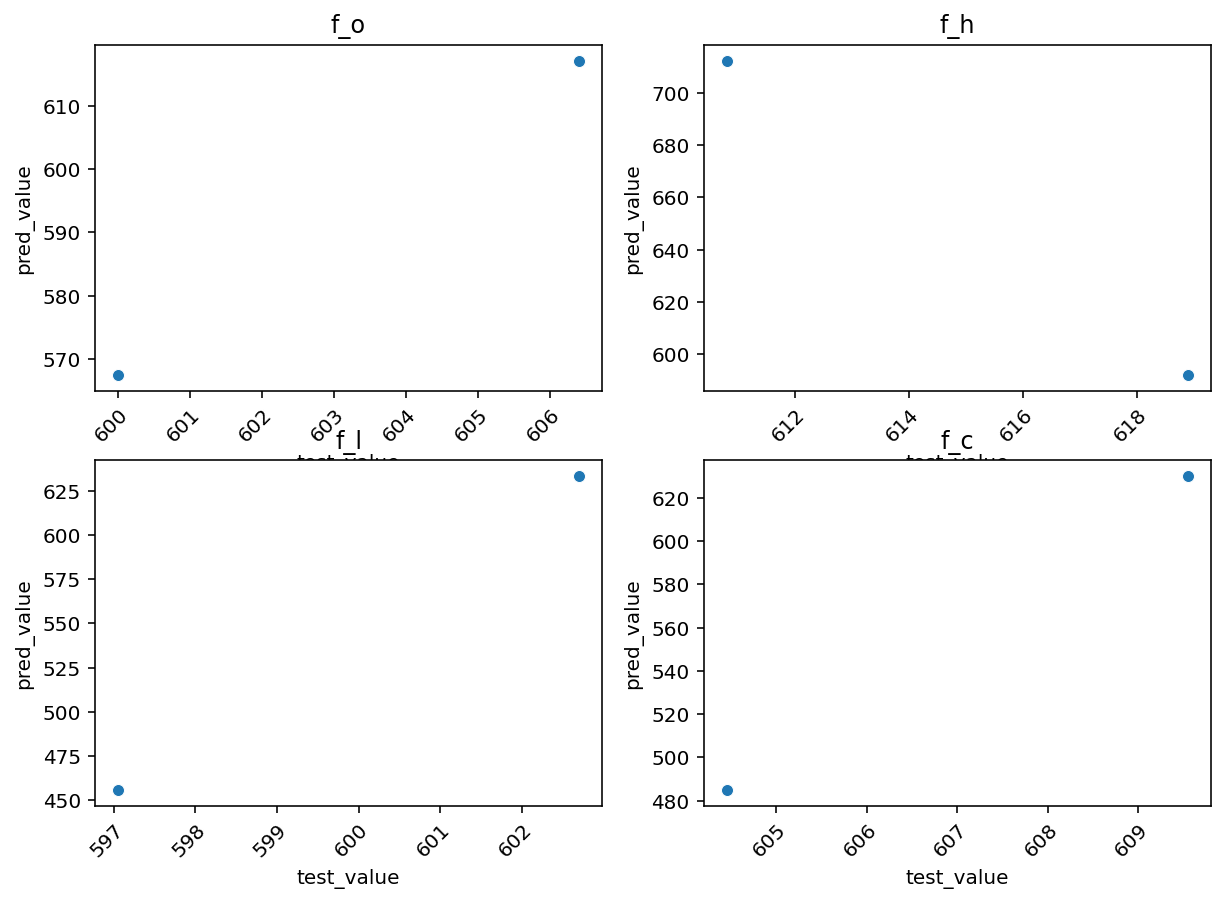

,o,h,l,c,v
f_o,-0.25,0.22,-0.20,1.14,0.00
f_h,0.12,-0.32,-0.30,1.22,0.00
f_l,0.58,-0.87,-0.14,1.23,0.00
f_c,0.36,-0.68,0.14,0.77,0.00


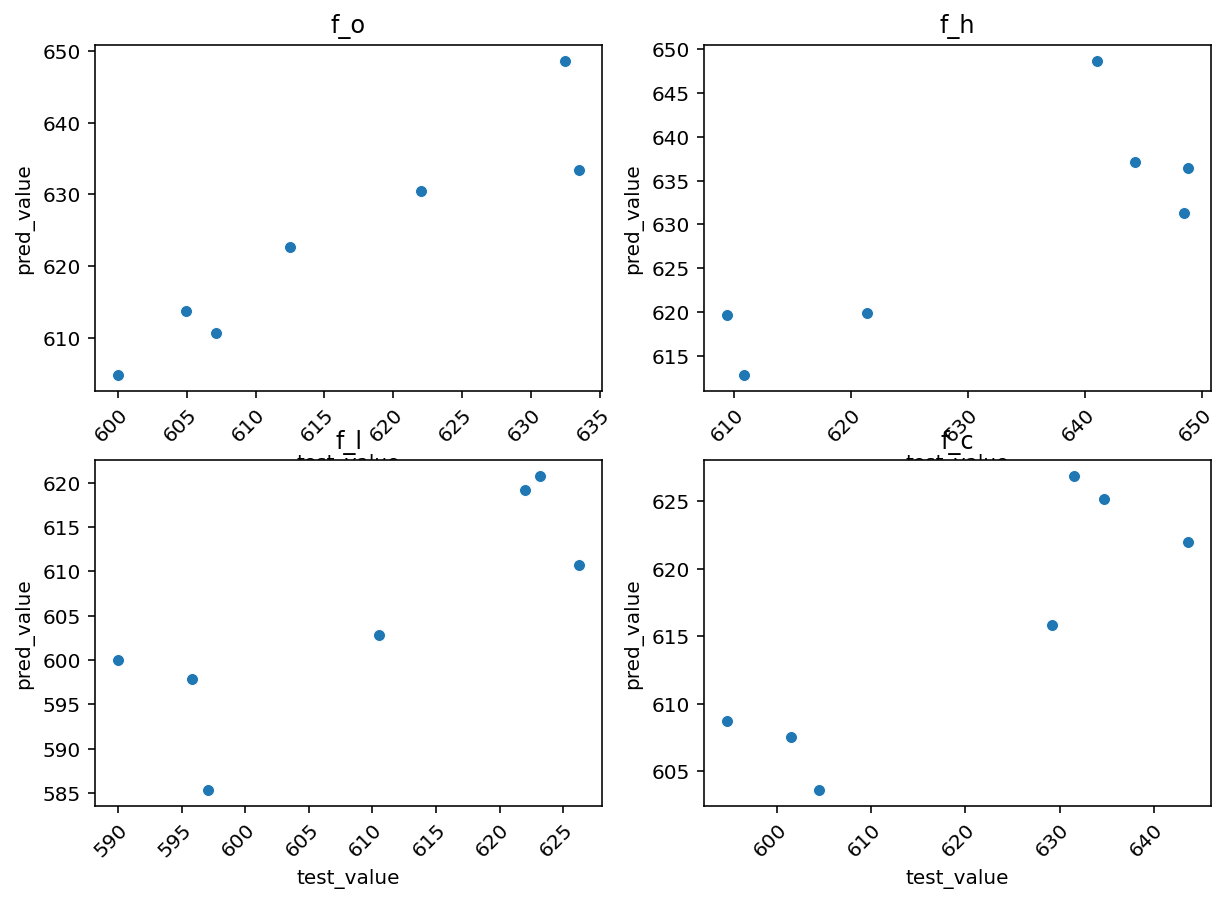

,o,h,l,c,v
f_o,-0.16,0.18,0.04,0.94,-0.00
f_h,0.07,0.14,-0.37,1.16,-0.00
f_l,-0.01,0.06,0.03,0.91,0.00
f_c,0.25,0.10,-0.45,1.07,0.00


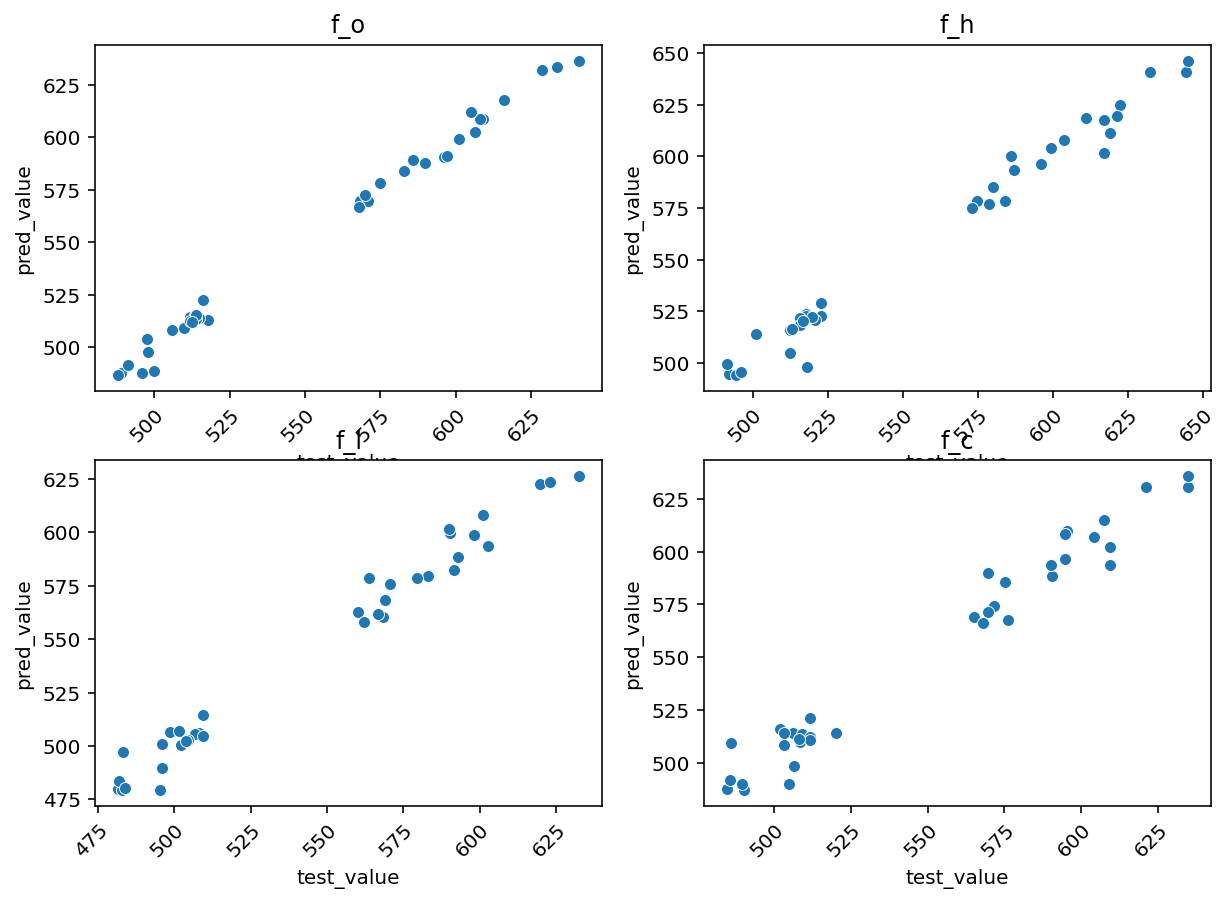

,o,h,l,c,v
f_o,-0.23,0.18,0.15,0.91,0.00
f_h,-0.10,0.32,-0.22,0.99,-0.00
f_l,-0.15,0.13,0.20,0.83,0.00
f_c,-0.04,0.24,-0.07,0.86,0.00


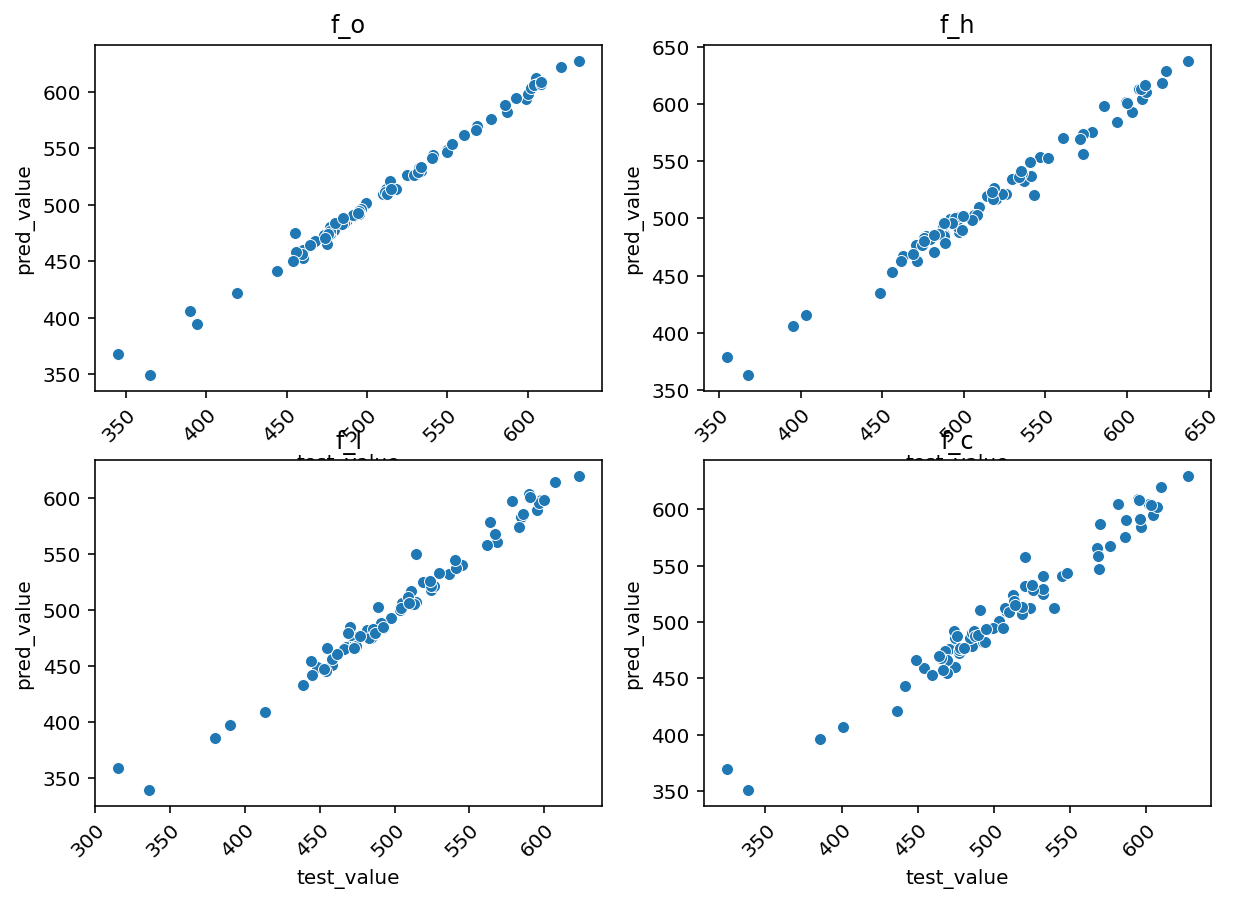

,o,h,l,c,v
f_o,-0.14,0.16,0.02,0.97,0.00
f_h,-0.14,0.30,-0.11,0.94,0.00
f_l,-0.04,-0.19,0.05,1.19,0.00
f_c,-0.05,0.01,-0.05,1.08,0.00


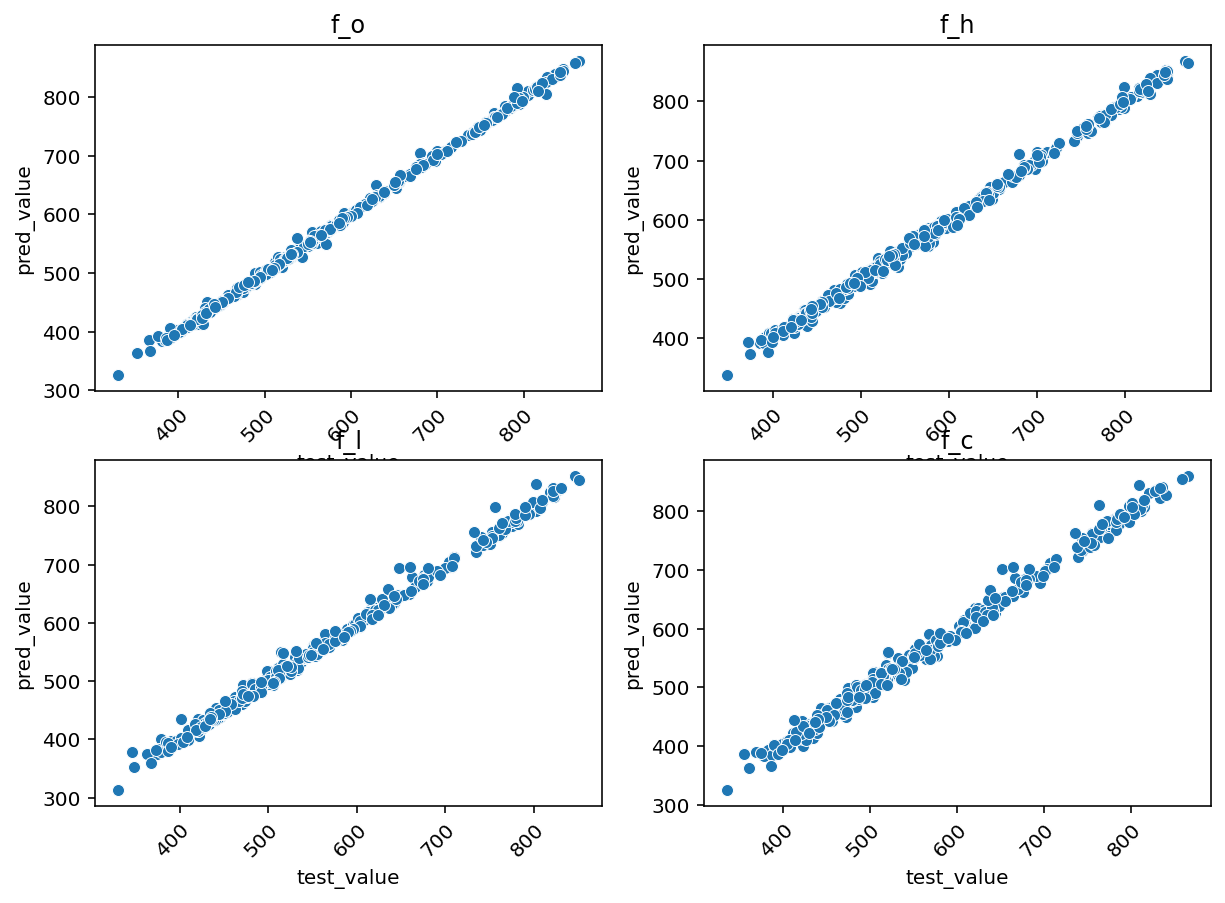

In [10]:
my_data = pd.DataFrame([{'SYMBOL':'SUNPHARMA','QTY':5,'INVESTMENT':1000}])
prediction_details(lm_data)

In [11]:
pred_values = get_predicted_value(lm_data)
prediction_summary(my_data,pred_values)

,SYMBOL,QTY,INVESTMENT
0,SUNPHARMA,5,1000


column                  f_c    f_h    f_l    f_o
SYMBOL    time_frame                            
SUNPHARMA 1 week     646.17 578.48 653.10 622.58
          1 month    607.72 614.38 601.51 605.31
          6 month    604.26 614.46 598.39 607.56
          1 year     604.77 612.51 600.00 607.63
          5 year     605.51 612.77 599.25 607.19

predicted_closing_value = predicted_values[predicted_values['column']=='f_c']
predicted_portfolio =my_port.merge(predicted_closing_value)
predicted_portfolio['predicted_val'] = predicted_portfolio['QTY'] * predicted_portfolio['change']
display(predicted_portfolio)

#update_portfolio_file(predicted_portfolio,'lm_port_'+target_file,False)


predicted_portfolio.columns

for key in time_dims:
    print(key)
    display(predicted_portfolio[predicted_portfolio['time_frame']==key].groupby('SYMBOL')['predicted_val'].agg(['sum']))
    display(predicted_portfolio[predicted_portfolio['time_frame']==key]['predicted_val'].agg(['sum']))